In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os



In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

/home/aban/somu/deep3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading and Spiltting in Train , Val, Test

In [3]:
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:02<00:00, 85220965.82it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# Check the shape of the testset
print("Train set shape:", train_set.data.shape)
print("Test set shape:", test_set.data.shape)

Train set shape: (50000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)


In [5]:
from torch.utils.data import random_split
torch.manual_seed(43)
val_size = 5000
train_size = len(train_set) - val_size
train_set, val_set = random_split(train_set, [train_size, val_size])
len(train_set), len(val_set)

(45000, 5000)

In [6]:
# Create data loaders for batch processing
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64,shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=len(val_set),shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64,shuffle=False, num_workers=2)

In [7]:
for images,labels in val_loader:
    print(images.shape)
    break

torch.Size([5000, 3, 32, 32])


In [ ]:
# calculate the mean and standard deviation of the CIFAR-10 training dataset
mean = train_set.data.mean(axis=(0, 1, 2))/255
std = train_set.data.std(axis=(0, 1, 2))/255
print(mean)
print(std)

# DEFINING A CNN PandaNet1

In [8]:
pip install torch-summary

Note: you may need to restart the kernel to use updated packages.


In [11]:
import torch.nn as nn
from torchsummary import summary

# Define the CNN architecture
class PandaNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1) #(depth of each conv2d,noof conv2d)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(p=0.5)
        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x))) #32*32
        x = self.pool(self.relu(self.conv2(x))) #16*16
        x = self.pool(self.relu(self.conv3(x))) #4*4
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return self.softmax(x)

# Create an instance of the CNN
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PandaNet = PandaNet().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(PandaNet.parameters(), lr=0.001, momentum=0.9)
print(PandaNet)

PandaNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (softmax): Softmax(dim=1)
  (relu): ReLU()
)


# **Counting The No of Parameters**

In [13]:
total = 0
print('Trainable parameters:')
for name, param in PandaNet.named_parameters():
    if param.requires_grad:
        print(name, '\t', param.numel())
        total += param.numel()
print()
print('Total', '\t', total)

Trainable parameters:
conv1.weight 	 864
conv1.bias 	 32
conv2.weight 	 18432
conv2.bias 	 64
conv3.weight 	 73728
conv3.bias 	 128
fc1.weight 	 1048576
fc1.bias 	 512
fc2.weight 	 5120
fc2.bias 	 10

Total 	 1147466


# **Training the CNN**

**Early Stopping Class**

In [12]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

In [51]:
from tqdm import tqdm
import time

start_time = time.time()

train_loss = []
train_accuracy = []
validation_loss = []
validation_accuracy = []

early_stopping = EarlyStopping(tolerance=5, min_delta=10)

for epoch in tqdm(range(5),desc="Loading..."):
    correct = 0
    total = 0
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = PandaNet(images)
        loss = criterion(outputs, labels)
        
        #checking Training Accuracy
        with torch.no_grad():
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    #testing val_acuuracy after each epoch
    total_val = 0
    correct_val = 0
    with torch.no_grad():
        for im_val,label_val in val_loader:
            im_val, label_val = im_val.to(device), label_val.to(device)
            output_val = PandaNet(im_val)
            val_loss = criterion(output_val, label_val)
            _, predicted_val = torch.max(output_val.data, 1)
            total_val += label_val.size(0)
            correct_val += (predicted_val == label_val).sum().item()

            
    print ('Epoch {} | Training Loss {:.2f} | Training Accuracy {:.2f}% | Validation Loss  {:.2f}| Validation Accuracy {}%'.format(epoch+1,running_loss/782,(100 * correct / total),(val_loss.item()),(100*correct_val/total_val)))
        
    train_loss.append(running_loss/782)
    train_accuracy.append(100 * correct / total)
    validation_loss.append(val_loss.item())
    validation_accuracy.append(100*correct_val/total_val)
    
    # early stopping
    early_stopping(running_loss/782, val_loss.item())
    if early_stopping.early_stop:
      print('early stop')
      break
        
torch.save(PandaNet.state_dict(), 'PandaNet1.pth')
    
end_time = time.time()
# Calculate the execution time
execution_time = end_time - start_time
# Print the execution time in seconds
print("Training time:", execution_time, "seconds")

Loading...:  20%|██        | 1/5 [00:19<01:16, 19.13s/it]

Epoch 1 | Training Loss 1.50 | Training Accuracy 79.71% | Validation Loss  1.71| Validation Accuracy 75.1%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff1d1c3fa70>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Loading...:  40%|████      | 2/5 [00:38<00:58, 19.55s/it]

Epoch 2 | Training Loss 1.50 | Training Accuracy 79.66% | Validation Loss  1.72| Validation Accuracy 74.8%


Loading...:  60%|██████    | 3/5 [00:58<00:38, 19.43s/it]

Epoch 3 | Training Loss 1.50 | Training Accuracy 79.92% | Validation Loss  1.71| Validation Accuracy 74.86%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff1d1c3fa70>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Loading...:  80%|████████  | 4/5 [01:17<00:19, 19.34s/it]

Epoch 4 | Training Loss 1.50 | Training Accuracy 80.26% | Validation Loss  1.71| Validation Accuracy 75.54%


Loading...: 100%|██████████| 5/5 [01:36<00:00, 19.38s/it]

Epoch 5 | Training Loss 1.50 | Training Accuracy 80.12% | Validation Loss  1.71| Validation Accuracy 75.6%
Training time: 96.91204833984375 seconds


# Plotting Loss W.R.T. epoch

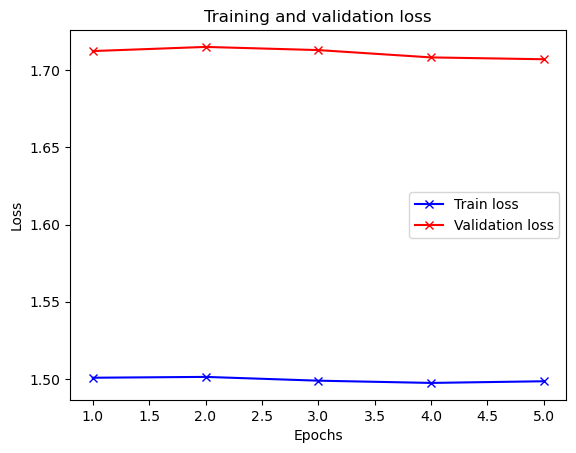

In [52]:
import matplotlib.pyplot as plt

# Define the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the train loss and val loss
plt.plot(epochs, train_loss, '-bx', label='Train loss')
plt.plot(epochs, validation_loss, '-rx', label='Validation loss')


# Set the title and labels for the graph
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()


# Plotting Accuracy w.r.t. epochs

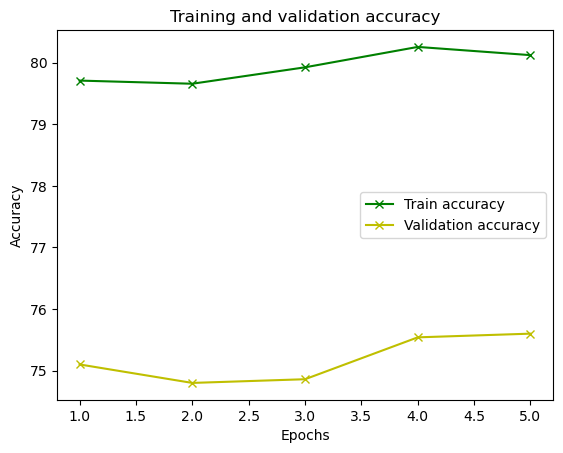

In [53]:
# Define the number of epochs
epochs = range(1, len(train_loss) + 1)
# Plot the train accuracy and val accuracy
plt.plot(epochs, train_accuracy, '-gx', label='Train accuracy')
plt.plot(epochs, validation_accuracy, '-yx', label='Validation accuracy')
# Set the title and labels for the graph
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()

# Testing The Model

In [54]:
# Evaluate the CNN on the test set
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = PandaNet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print the accuracy
print('Accuracy of the pre-trained CNN on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the pre-trained CNN on the 10000 test images: 75.59 %


# PandaNet1 with normal SGD and ReLU

In [17]:
import torch.nn as nn
from torchsummary import summary

# Define the CNN architecture
class PandaNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1) #(depth of each conv2d,noof conv2d)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(p=0.1)
        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x))) #32*32
        x = self.pool(self.relu(self.conv2(x))) #16*16
        x = self.pool(self.relu(self.conv3(x))) #4*4
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return self.softmax(x)

# Create an instance of the CNN
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PandaNet = PandaNet().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(PandaNet.parameters(), lr=0.001)
summary(PandaNet)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            18,496
├─Conv2d: 1-3                            73,856
├─MaxPool2d: 1-4                         --
├─Linear: 1-5                            1,049,088
├─Linear: 1-6                            5,130
├─Dropout: 1-7                           --
├─Softmax: 1-8                           --
├─ReLU: 1-9                              --
Total params: 1,147,466
Trainable params: 1,147,466
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            18,496
├─Conv2d: 1-3                            73,856
├─MaxPool2d: 1-4                         --
├─Linear: 1-5                            1,049,088
├─Linear: 1-6                            5,130
├─Dropout: 1-7                           --
├─Softmax: 1-8                           --
├─ReLU: 1-9                              --
Total params: 1,147,466
Trainable params: 1,147,466
Non-trainable params: 0

In [18]:
from tqdm import tqdm
import time

start_time = time.time()

train_loss = []
train_accuracy = []
validation_loss = []
validation_accuracy = []

early_stopping = EarlyStopping(tolerance=5, min_delta=10)

for epoch in tqdm(range(50),desc="Loading..."):
    correct = 0
    total = 0
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = PandaNet(images)
        loss = criterion(outputs, labels)
        
        #checking Training Accuracy
        with torch.no_grad():
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    #testing val_acuuracy after each epoch
    total_val = 0
    correct_val = 0
    with torch.no_grad():
        for im_val,label_val in val_loader:
            im_val, label_val = im_val.to(device), label_val.to(device)
            output_val = PandaNet(im_val)
            val_loss = criterion(output_val, label_val)
            _, predicted_val = torch.max(output_val.data, 1)
            total_val += label_val.size(0)
            correct_val += (predicted_val == label_val).sum().item()

            
    print ('Epoch {} | Training Loss {:.2f} | Training Accuracy {:.2f}% | Validation Loss  {:.2f}| Validation Accuracy {}%'.format(epoch+1,running_loss/782,(100 * correct / total),(val_loss.item()),(100*correct_val/total_val)))
        
    train_loss.append(running_loss/782)
    train_accuracy.append(100 * correct / total)
    validation_loss.append(val_loss.item())
    validation_accuracy.append(100*correct_val/total_val)
    
    # early stopping
    early_stopping(running_loss/782, val_loss.item())
    if early_stopping.early_stop:
      print('early stop')
      break
        
torch.save(PandaNet.state_dict(), 'PandaNet1.pth')
    
end_time = time.time()
# Calculate the execution time
execution_time = end_time - start_time
# Print the execution time in seconds
print("Training time:", execution_time, "seconds")

Loading...:   2%|▏         | 1/50 [00:18<14:45, 18.07s/it]

Epoch 1 | Training Loss 2.07 | Training Accuracy 10.05% | Validation Loss  2.30| Validation Accuracy 9.94%


Loading...:   4%|▍         | 2/50 [00:36<14:30, 18.14s/it]

Epoch 2 | Training Loss 2.07 | Training Accuracy 10.40% | Validation Loss  2.30| Validation Accuracy 10.22%


Loading...:   6%|▌         | 3/50 [00:54<14:15, 18.19s/it]

Epoch 3 | Training Loss 2.07 | Training Accuracy 10.68% | Validation Loss  2.30| Validation Accuracy 10.62%


Loading...:   8%|▊         | 4/50 [01:12<13:59, 18.25s/it]

Epoch 4 | Training Loss 2.07 | Training Accuracy 10.90% | Validation Loss  2.30| Validation Accuracy 10.48%


Loading...:  10%|█         | 5/50 [01:31<13:41, 18.26s/it]

Epoch 5 | Training Loss 2.07 | Training Accuracy 11.42% | Validation Loss  2.30| Validation Accuracy 11.3%


Loading...:  12%|█▏        | 6/50 [01:49<13:24, 18.29s/it]

Epoch 6 | Training Loss 2.07 | Training Accuracy 11.99% | Validation Loss  2.30| Validation Accuracy 11.1%


Loading...:  14%|█▍        | 7/50 [02:08<13:10, 18.38s/it]

Epoch 7 | Training Loss 2.07 | Training Accuracy 12.64% | Validation Loss  2.30| Validation Accuracy 11.96%


Loading...:  16%|█▌        | 8/50 [02:25<12:42, 18.14s/it]

Epoch 8 | Training Loss 2.07 | Training Accuracy 13.07% | Validation Loss  2.30| Validation Accuracy 12.38%


Loading...:  18%|█▊        | 9/50 [02:44<12:32, 18.35s/it]

Epoch 9 | Training Loss 2.07 | Training Accuracy 13.01% | Validation Loss  2.30| Validation Accuracy 11.76%


Loading...:  20%|██        | 10/50 [03:02<12:14, 18.35s/it]

Epoch 10 | Training Loss 2.07 | Training Accuracy 12.87% | Validation Loss  2.30| Validation Accuracy 11.82%


Loading...:  22%|██▏       | 11/50 [03:20<11:51, 18.24s/it]

Epoch 11 | Training Loss 2.07 | Training Accuracy 12.35% | Validation Loss  2.30| Validation Accuracy 11.62%


Loading...:  24%|██▍       | 12/50 [03:39<11:33, 18.24s/it]

Epoch 12 | Training Loss 2.07 | Training Accuracy 12.02% | Validation Loss  2.30| Validation Accuracy 10.92%


Loading...:  26%|██▌       | 13/50 [03:56<11:09, 18.08s/it]

Epoch 13 | Training Loss 2.07 | Training Accuracy 11.60% | Validation Loss  2.30| Validation Accuracy 11.08%


Loading...:  28%|██▊       | 14/50 [04:14<10:43, 17.89s/it]

Epoch 14 | Training Loss 2.07 | Training Accuracy 11.44% | Validation Loss  2.30| Validation Accuracy 10.74%


Loading...:  30%|███       | 15/50 [04:32<10:25, 17.88s/it]

Epoch 15 | Training Loss 2.07 | Training Accuracy 11.22% | Validation Loss  2.30| Validation Accuracy 10.5%


Loading...:  32%|███▏      | 16/50 [04:50<10:12, 18.00s/it]

Epoch 16 | Training Loss 2.07 | Training Accuracy 10.95% | Validation Loss  2.30| Validation Accuracy 10.22%


Loading...:  34%|███▍      | 17/50 [05:08<09:58, 18.13s/it]

Epoch 17 | Training Loss 2.07 | Training Accuracy 10.81% | Validation Loss  2.30| Validation Accuracy 10.22%


Loading...:  36%|███▌      | 18/50 [05:26<09:34, 17.94s/it]

Epoch 18 | Training Loss 2.07 | Training Accuracy 10.74% | Validation Loss  2.30| Validation Accuracy 10.14%


Loading...:  38%|███▊      | 19/50 [05:43<09:12, 17.81s/it]

Epoch 19 | Training Loss 2.07 | Training Accuracy 10.72% | Validation Loss  2.30| Validation Accuracy 10.12%


Loading...:  40%|████      | 20/50 [06:01<08:51, 17.71s/it]

Epoch 20 | Training Loss 2.07 | Training Accuracy 10.78% | Validation Loss  2.30| Validation Accuracy 10.26%


Loading...:  42%|████▏     | 21/50 [06:19<08:40, 17.94s/it]

Epoch 21 | Training Loss 2.07 | Training Accuracy 10.78% | Validation Loss  2.30| Validation Accuracy 10.44%


Loading...:  44%|████▍     | 22/50 [06:37<08:21, 17.93s/it]

Epoch 22 | Training Loss 2.07 | Training Accuracy 11.00% | Validation Loss  2.30| Validation Accuracy 10.5%


Loading...:  46%|████▌     | 23/50 [06:56<08:09, 18.13s/it]

Epoch 23 | Training Loss 2.07 | Training Accuracy 11.09% | Validation Loss  2.30| Validation Accuracy 10.94%


Loading...:  48%|████▊     | 24/50 [07:14<07:54, 18.24s/it]

Epoch 24 | Training Loss 2.07 | Training Accuracy 11.89% | Validation Loss  2.30| Validation Accuracy 12.02%


Loading...:  50%|█████     | 25/50 [07:32<07:33, 18.14s/it]

Epoch 25 | Training Loss 2.07 | Training Accuracy 13.35% | Validation Loss  2.30| Validation Accuracy 12.7%


Loading...:  52%|█████▏    | 26/50 [07:51<07:18, 18.27s/it]

Epoch 26 | Training Loss 2.07 | Training Accuracy 13.89% | Validation Loss  2.29| Validation Accuracy 13.74%


Loading...:  54%|█████▍    | 27/50 [08:09<07:02, 18.38s/it]

Epoch 27 | Training Loss 2.06 | Training Accuracy 14.42% | Validation Loss  2.29| Validation Accuracy 14.08%


Loading...:  56%|█████▌    | 28/50 [08:27<06:42, 18.30s/it]

Epoch 28 | Training Loss 2.06 | Training Accuracy 14.44% | Validation Loss  2.29| Validation Accuracy 13.74%


Loading...:  58%|█████▊    | 29/50 [08:47<06:29, 18.53s/it]

Epoch 29 | Training Loss 2.06 | Training Accuracy 13.89% | Validation Loss  2.29| Validation Accuracy 13.22%


Loading...:  60%|██████    | 30/50 [09:05<06:08, 18.43s/it]

Epoch 30 | Training Loss 2.06 | Training Accuracy 13.59% | Validation Loss  2.29| Validation Accuracy 12.88%


Loading...:  62%|██████▏   | 31/50 [09:23<05:49, 18.40s/it]

Epoch 31 | Training Loss 2.06 | Training Accuracy 13.32% | Validation Loss  2.28| Validation Accuracy 13.24%


Loading...:  64%|██████▍   | 32/50 [09:42<05:31, 18.42s/it]

Epoch 32 | Training Loss 2.05 | Training Accuracy 13.70% | Validation Loss  2.28| Validation Accuracy 13.56%


Loading...:  66%|██████▌   | 33/50 [10:00<05:13, 18.46s/it]

Epoch 33 | Training Loss 2.05 | Training Accuracy 13.98% | Validation Loss  2.28| Validation Accuracy 13.98%


Loading...:  68%|██████▊   | 34/50 [10:19<04:56, 18.55s/it]

Epoch 34 | Training Loss 2.05 | Training Accuracy 14.54% | Validation Loss  2.27| Validation Accuracy 14.9%


Loading...:  70%|███████   | 35/50 [10:37<04:35, 18.34s/it]

Epoch 35 | Training Loss 2.04 | Training Accuracy 15.91% | Validation Loss  2.27| Validation Accuracy 16.56%


Loading...:  72%|███████▏  | 36/50 [10:55<04:18, 18.46s/it]

Epoch 36 | Training Loss 2.04 | Training Accuracy 17.68% | Validation Loss  2.26| Validation Accuracy 18.28%


Loading...:  74%|███████▍  | 37/50 [11:13<03:55, 18.14s/it]

Epoch 37 | Training Loss 2.03 | Training Accuracy 18.95% | Validation Loss  2.26| Validation Accuracy 19.74%


Loading...:  76%|███████▌  | 38/50 [11:31<03:39, 18.29s/it]

Epoch 38 | Training Loss 2.03 | Training Accuracy 20.48% | Validation Loss  2.25| Validation Accuracy 20.64%


Loading...:  78%|███████▊  | 39/50 [11:50<03:21, 18.35s/it]

Epoch 39 | Training Loss 2.02 | Training Accuracy 21.30% | Validation Loss  2.25| Validation Accuracy 21.82%


Loading...:  80%|████████  | 40/50 [12:08<03:02, 18.21s/it]

Epoch 40 | Training Loss 2.02 | Training Accuracy 22.25% | Validation Loss  2.24| Validation Accuracy 22.2%


Loading...:  82%|████████▏ | 41/50 [12:26<02:44, 18.32s/it]

Epoch 41 | Training Loss 2.01 | Training Accuracy 22.63% | Validation Loss  2.24| Validation Accuracy 22.42%


Loading...:  84%|████████▍ | 42/50 [12:45<02:26, 18.34s/it]

Epoch 42 | Training Loss 2.01 | Training Accuracy 22.98% | Validation Loss  2.23| Validation Accuracy 22.32%


Loading...:  86%|████████▌ | 43/50 [13:04<02:10, 18.58s/it]

Epoch 43 | Training Loss 2.00 | Training Accuracy 23.20% | Validation Loss  2.23| Validation Accuracy 22.38%


Loading...:  88%|████████▊ | 44/50 [13:22<01:50, 18.36s/it]

Epoch 44 | Training Loss 2.00 | Training Accuracy 23.19% | Validation Loss  2.22| Validation Accuracy 22.9%


Loading...:  90%|█████████ | 45/50 [13:41<01:32, 18.49s/it]

Epoch 45 | Training Loss 2.00 | Training Accuracy 23.47% | Validation Loss  2.22| Validation Accuracy 23.28%


Loading...:  92%|█████████▏| 46/50 [13:59<01:13, 18.48s/it]

Epoch 46 | Training Loss 1.99 | Training Accuracy 23.58% | Validation Loss  2.22| Validation Accuracy 23.06%


Loading...:  94%|█████████▍| 47/50 [14:17<00:54, 18.23s/it]

Epoch 47 | Training Loss 1.99 | Training Accuracy 23.82% | Validation Loss  2.21| Validation Accuracy 23.7%


Loading...:  96%|█████████▌| 48/50 [14:35<00:36, 18.32s/it]

Epoch 48 | Training Loss 1.99 | Training Accuracy 24.02% | Validation Loss  2.21| Validation Accuracy 23.16%


Loading...:  98%|█████████▊| 49/50 [14:53<00:18, 18.25s/it]

Epoch 49 | Training Loss 1.98 | Training Accuracy 24.29% | Validation Loss  2.21| Validation Accuracy 23.9%


Loading...: 100%|██████████| 50/50 [15:12<00:00, 18.25s/it]

Epoch 50 | Training Loss 1.98 | Training Accuracy 24.90% | Validation Loss  2.21| Validation Accuracy 24.86%
Training time: 912.5163173675537 seconds


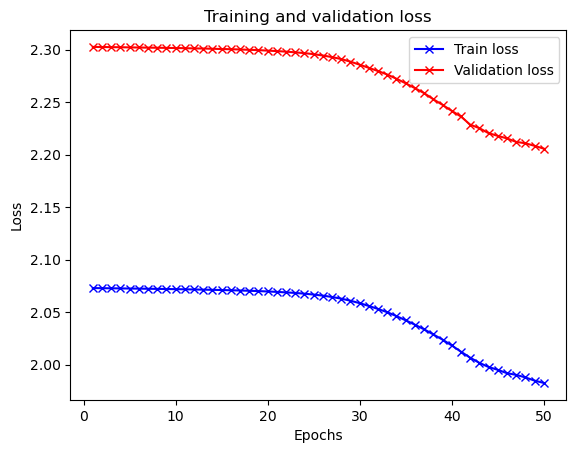

In [19]:
import matplotlib.pyplot as plt

# Define the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the train loss and val loss
plt.plot(epochs, train_loss, '-bx', label='Train loss')
plt.plot(epochs, validation_loss, '-rx', label='Validation loss')


# Set the title and labels for the graph
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()


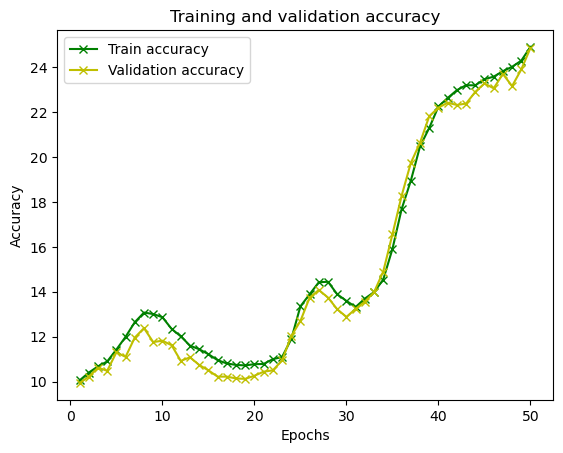

In [20]:
# Define the number of epochs
epochs = range(1, len(train_loss) + 1)
# Plot the train accuracy and val accuracy
plt.plot(epochs, train_accuracy, '-gx', label='Train accuracy')
plt.plot(epochs, validation_accuracy, '-yx', label='Validation accuracy')
# Set the title and labels for the graph
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()

In [21]:
# Evaluate the CNN on the test set
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = PandaNet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print the accuracy
print('Accuracy of the pre-trained CNN on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the pre-trained CNN on the 10000 test images: 25.55 %


# PandaNet1 using Sigmoid and normal SGD

In [13]:
import torch.nn as nn
from torchsummary import summary

# Define the CNN architecture
class PandaNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1) #(depth of each conv2d,noof conv2d)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(p=0.1)
        self.softmax = nn.Softmax(dim=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(self.sigmoid(self.conv1(x))) #32*32
        x = self.pool(self.sigmoid(self.conv2(x))) #16*16
        x = self.pool(self.sigmoid(self.conv3(x))) #4*4
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(self.sigmoid(self.fc1(x)))
        x = self.fc2(x)
        return self.softmax(x)

# Create an instance of the CNN
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PandaNet = PandaNet().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(PandaNet.parameters(), lr=0.001)
print(PandaNet)

PandaNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (softmax): Softmax(dim=1)
  (sigmoid): Sigmoid()
)


In [14]:
from tqdm import tqdm
import time

start_time = time.time()

train_loss = []
train_accuracy = []
validation_loss = []
validation_accuracy = []

early_stopping = EarlyStopping(tolerance=5, min_delta=10)

for epoch in tqdm(range(50),desc="Loading..."):
    correct = 0
    total = 0
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = PandaNet(images)
        loss = criterion(outputs, labels)
        
        #checking Training Accuracy
        with torch.no_grad():
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    #testing val_acuuracy after each epoch
    total_val = 0
    correct_val = 0
    with torch.no_grad():
        for im_val,label_val in val_loader:
            im_val, label_val = im_val.to(device), label_val.to(device)
            output_val = PandaNet(im_val)
            val_loss = criterion(output_val, label_val)
            _, predicted_val = torch.max(output_val.data, 1)
            total_val += label_val.size(0)
            correct_val += (predicted_val == label_val).sum().item()

            
    print ('Epoch {} | Training Loss {:.2f} | Training Accuracy {:.2f}% | Validation Loss  {:.2f}| Validation Accuracy {}%'.format(epoch+1,running_loss/782,(100 * correct / total),(val_loss.item()),(100*correct_val/total_val)))
        
    train_loss.append(running_loss/782)
    train_accuracy.append(100 * correct / total)
    validation_loss.append(val_loss.item())
    validation_accuracy.append(100*correct_val/total_val)
    
    # early stopping
    early_stopping(running_loss/782, val_loss.item())
    if early_stopping.early_stop:
      print('early stop')
      break
        
torch.save(PandaNet.state_dict(), 'PandaNet1.pth')
    
end_time = time.time()
# Calculate the execution time
execution_time = end_time - start_time
# Print the execution time in seconds
print("Training time:", execution_time, "seconds")

Loading...:   2%|▏         | 1/50 [00:09<07:21,  9.01s/it]

Epoch 1 | Training Loss 2.07 | Training Accuracy 9.99% | Validation Loss  2.30| Validation Accuracy 9.76%


Loading...:   4%|▍         | 2/50 [00:16<06:42,  8.38s/it]

Epoch 2 | Training Loss 2.07 | Training Accuracy 10.02% | Validation Loss  2.30| Validation Accuracy 10.04%


Loading...:   6%|▌         | 3/50 [00:24<06:26,  8.22s/it]

Epoch 3 | Training Loss 2.07 | Training Accuracy 9.97% | Validation Loss  2.30| Validation Accuracy 9.56%


Loading...:   8%|▊         | 4/50 [00:33<06:16,  8.18s/it]

Epoch 4 | Training Loss 2.07 | Training Accuracy 10.10% | Validation Loss  2.30| Validation Accuracy 10.06%


Loading...:  10%|█         | 5/50 [00:41<06:04,  8.10s/it]

Epoch 5 | Training Loss 2.07 | Training Accuracy 10.08% | Validation Loss  2.30| Validation Accuracy 10.5%


Loading...:  12%|█▏        | 6/50 [00:49<05:55,  8.09s/it]

Epoch 6 | Training Loss 2.07 | Training Accuracy 9.93% | Validation Loss  2.30| Validation Accuracy 9.92%


Loading...:  14%|█▍        | 7/50 [00:57<05:46,  8.07s/it]

Epoch 7 | Training Loss 2.07 | Training Accuracy 10.00% | Validation Loss  2.30| Validation Accuracy 9.6%


Loading...:  16%|█▌        | 8/50 [01:05<05:38,  8.06s/it]

Epoch 8 | Training Loss 2.07 | Training Accuracy 9.80% | Validation Loss  2.30| Validation Accuracy 9.96%


Loading...:  18%|█▊        | 9/50 [01:13<05:27,  7.98s/it]

Epoch 9 | Training Loss 2.07 | Training Accuracy 10.30% | Validation Loss  2.30| Validation Accuracy 9.64%


Loading...:  20%|██        | 10/50 [01:21<05:20,  8.02s/it]

Epoch 10 | Training Loss 2.07 | Training Accuracy 10.24% | Validation Loss  2.30| Validation Accuracy 9.6%


Loading...:  22%|██▏       | 11/50 [01:29<05:11,  7.99s/it]

Epoch 11 | Training Loss 2.07 | Training Accuracy 10.12% | Validation Loss  2.30| Validation Accuracy 10.04%


Loading...:  24%|██▍       | 12/50 [01:37<05:03,  8.00s/it]

Epoch 12 | Training Loss 2.07 | Training Accuracy 9.94% | Validation Loss  2.30| Validation Accuracy 9.82%


Loading...:  26%|██▌       | 13/50 [01:44<04:55,  7.97s/it]

Epoch 13 | Training Loss 2.07 | Training Accuracy 10.11% | Validation Loss  2.30| Validation Accuracy 9.92%


Loading...:  28%|██▊       | 14/50 [01:52<04:47,  7.99s/it]

Epoch 14 | Training Loss 2.07 | Training Accuracy 10.12% | Validation Loss  2.30| Validation Accuracy 10.24%


Loading...:  30%|███       | 15/50 [02:00<04:39,  7.99s/it]

Epoch 15 | Training Loss 2.07 | Training Accuracy 9.86% | Validation Loss  2.30| Validation Accuracy 10.5%


Loading...:  32%|███▏      | 16/50 [02:09<04:32,  8.02s/it]

Epoch 16 | Training Loss 2.07 | Training Accuracy 10.15% | Validation Loss  2.30| Validation Accuracy 9.84%


Loading...:  34%|███▍      | 17/50 [02:17<04:25,  8.03s/it]

Epoch 17 | Training Loss 2.07 | Training Accuracy 9.98% | Validation Loss  2.30| Validation Accuracy 9.56%


Loading...:  36%|███▌      | 18/50 [02:25<04:16,  8.03s/it]

Epoch 18 | Training Loss 2.07 | Training Accuracy 10.19% | Validation Loss  2.30| Validation Accuracy 9.78%


Loading...:  38%|███▊      | 19/50 [02:33<04:07,  7.99s/it]

Epoch 19 | Training Loss 2.07 | Training Accuracy 10.06% | Validation Loss  2.30| Validation Accuracy 10.14%


Loading...:  40%|████      | 20/50 [02:41<04:00,  8.01s/it]

Epoch 20 | Training Loss 2.07 | Training Accuracy 9.97% | Validation Loss  2.30| Validation Accuracy 9.74%


Loading...:  42%|████▏     | 21/50 [02:49<03:52,  8.02s/it]

Epoch 21 | Training Loss 2.07 | Training Accuracy 9.96% | Validation Loss  2.30| Validation Accuracy 10.26%


Loading...:  44%|████▍     | 22/50 [02:57<03:44,  8.02s/it]

Epoch 22 | Training Loss 2.07 | Training Accuracy 9.88% | Validation Loss  2.30| Validation Accuracy 10.14%


Loading...:  46%|████▌     | 23/50 [03:05<03:36,  8.03s/it]

Epoch 23 | Training Loss 2.07 | Training Accuracy 10.12% | Validation Loss  2.30| Validation Accuracy 8.82%


Loading...:  48%|████▊     | 24/50 [03:13<03:28,  8.02s/it]

Epoch 24 | Training Loss 2.07 | Training Accuracy 10.11% | Validation Loss  2.30| Validation Accuracy 9.42%


Loading...:  50%|█████     | 25/50 [03:21<03:21,  8.05s/it]

Epoch 25 | Training Loss 2.07 | Training Accuracy 10.12% | Validation Loss  2.30| Validation Accuracy 10.02%


Loading...:  52%|█████▏    | 26/50 [03:29<03:12,  8.00s/it]

Epoch 26 | Training Loss 2.07 | Training Accuracy 9.90% | Validation Loss  2.30| Validation Accuracy 9.8%


Loading...:  54%|█████▍    | 27/50 [03:37<03:05,  8.06s/it]

Epoch 27 | Training Loss 2.07 | Training Accuracy 9.80% | Validation Loss  2.30| Validation Accuracy 9.08%


Loading...:  56%|█████▌    | 28/50 [03:45<02:56,  8.04s/it]

Epoch 28 | Training Loss 2.07 | Training Accuracy 10.21% | Validation Loss  2.30| Validation Accuracy 10.78%


Loading...:  58%|█████▊    | 29/50 [03:53<02:49,  8.08s/it]

Epoch 29 | Training Loss 2.07 | Training Accuracy 10.04% | Validation Loss  2.30| Validation Accuracy 9.3%


Loading...:  60%|██████    | 30/50 [04:01<02:41,  8.06s/it]

Epoch 30 | Training Loss 2.07 | Training Accuracy 9.89% | Validation Loss  2.30| Validation Accuracy 9.3%


Loading...:  62%|██████▏   | 31/50 [04:09<02:32,  8.02s/it]

Epoch 31 | Training Loss 2.07 | Training Accuracy 9.92% | Validation Loss  2.30| Validation Accuracy 9.9%


Loading...:  64%|██████▍   | 32/50 [04:17<02:24,  8.03s/it]

Epoch 32 | Training Loss 2.07 | Training Accuracy 9.90% | Validation Loss  2.30| Validation Accuracy 9.96%


Loading...:  66%|██████▌   | 33/50 [04:25<02:16,  8.02s/it]

Epoch 33 | Training Loss 2.07 | Training Accuracy 10.08% | Validation Loss  2.30| Validation Accuracy 9.64%


Loading...:  68%|██████▊   | 34/50 [04:33<02:08,  8.02s/it]

Epoch 34 | Training Loss 2.07 | Training Accuracy 9.94% | Validation Loss  2.30| Validation Accuracy 9.74%


Loading...:  70%|███████   | 35/50 [04:41<02:00,  8.03s/it]

Epoch 35 | Training Loss 2.07 | Training Accuracy 9.92% | Validation Loss  2.30| Validation Accuracy 9.42%


Loading...:  72%|███████▏  | 36/50 [04:49<01:52,  8.04s/it]

Epoch 36 | Training Loss 2.07 | Training Accuracy 10.08% | Validation Loss  2.30| Validation Accuracy 10.22%


Loading...:  74%|███████▍  | 37/50 [04:57<01:44,  8.03s/it]

Epoch 37 | Training Loss 2.07 | Training Accuracy 10.01% | Validation Loss  2.30| Validation Accuracy 10.1%


Loading...:  76%|███████▌  | 38/50 [05:05<01:36,  8.00s/it]

Epoch 38 | Training Loss 2.07 | Training Accuracy 9.79% | Validation Loss  2.30| Validation Accuracy 9.92%


Loading...:  78%|███████▊  | 39/50 [05:13<01:28,  8.01s/it]

Epoch 39 | Training Loss 2.07 | Training Accuracy 9.86% | Validation Loss  2.30| Validation Accuracy 10.06%


Loading...:  80%|████████  | 40/50 [05:21<01:20,  8.03s/it]

Epoch 40 | Training Loss 2.07 | Training Accuracy 10.06% | Validation Loss  2.30| Validation Accuracy 10.16%


Loading...:  82%|████████▏ | 41/50 [05:29<01:12,  8.03s/it]

Epoch 41 | Training Loss 2.07 | Training Accuracy 9.88% | Validation Loss  2.30| Validation Accuracy 9.96%


Loading...:  84%|████████▍ | 42/50 [05:37<01:04,  8.03s/it]

Epoch 42 | Training Loss 2.07 | Training Accuracy 9.89% | Validation Loss  2.30| Validation Accuracy 9.66%


Loading...:  86%|████████▌ | 43/50 [05:45<00:56,  8.01s/it]

Epoch 43 | Training Loss 2.07 | Training Accuracy 9.89% | Validation Loss  2.30| Validation Accuracy 9.84%


Loading...:  88%|████████▊ | 44/50 [05:53<00:48,  8.04s/it]

Epoch 44 | Training Loss 2.07 | Training Accuracy 10.08% | Validation Loss  2.30| Validation Accuracy 8.94%


Loading...:  90%|█████████ | 45/50 [06:01<00:40,  8.05s/it]

Epoch 45 | Training Loss 2.07 | Training Accuracy 10.06% | Validation Loss  2.30| Validation Accuracy 9.44%


Loading...:  92%|█████████▏| 46/50 [06:09<00:32,  8.04s/it]

Epoch 46 | Training Loss 2.07 | Training Accuracy 9.94% | Validation Loss  2.30| Validation Accuracy 9.4%


Loading...:  94%|█████████▍| 47/50 [06:17<00:23,  7.99s/it]

Epoch 47 | Training Loss 2.07 | Training Accuracy 10.01% | Validation Loss  2.30| Validation Accuracy 9.04%


Loading...:  96%|█████████▌| 48/50 [06:25<00:16,  8.01s/it]

Epoch 48 | Training Loss 2.07 | Training Accuracy 9.86% | Validation Loss  2.30| Validation Accuracy 9.28%


Loading...:  98%|█████████▊| 49/50 [06:33<00:08,  8.00s/it]

Epoch 49 | Training Loss 2.07 | Training Accuracy 10.38% | Validation Loss  2.30| Validation Accuracy 9.64%


Loading...: 100%|██████████| 50/50 [06:41<00:00,  8.04s/it]

Epoch 50 | Training Loss 2.07 | Training Accuracy 9.98% | Validation Loss  2.30| Validation Accuracy 10.28%
Training time: 401.81323170661926 seconds


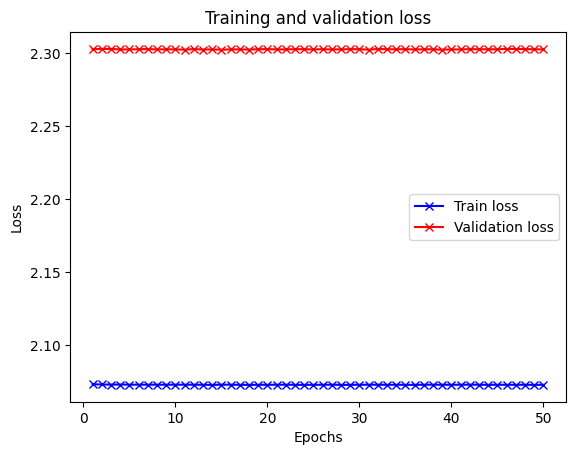

In [15]:
import matplotlib.pyplot as plt

# Define the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the train loss and val loss
plt.plot(epochs, train_loss, '-bx', label='Train loss')
plt.plot(epochs, validation_loss, '-rx', label='Validation loss')


# Set the title and labels for the graph
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()


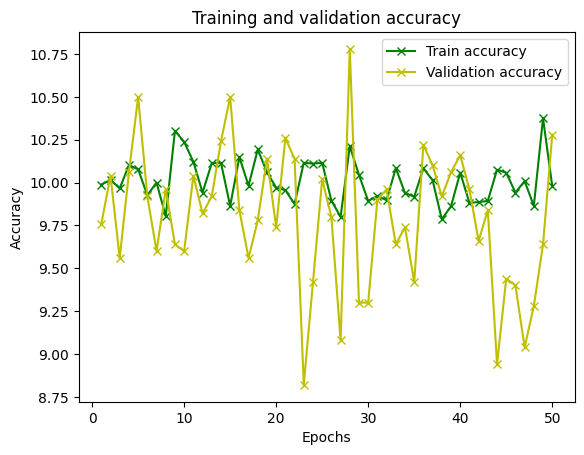

In [16]:
# Define the number of epochs
epochs = range(1, len(train_loss) + 1)
# Plot the train accuracy and val accuracy
plt.plot(epochs, train_accuracy, '-gx', label='Train accuracy')
plt.plot(epochs, validation_accuracy, '-yx', label='Validation accuracy')
# Set the title and labels for the graph
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()

# PandaNet1 using TanH and normal SGD

In [17]:
import torch.nn as nn
from torchsummary import summary

# Define the CNN architecture
class PandaNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1) #(depth of each conv2d,noof conv2d)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(p=0.1)
        self.softmax = nn.Softmax(dim=1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.pool(self.tanh(self.conv1(x))) #32*32
        x = self.pool(self.tanh(self.conv2(x))) #16*16
        x = self.pool(self.tanh(self.conv3(x))) #4*4
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(self.tanh(self.fc1(x)))
        x = self.fc2(x)
        return self.softmax(x)

# Create an instance of the CNN
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PandaNet = PandaNet().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(PandaNet.parameters(), lr=0.001)
print(PandaNet)

PandaNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (softmax): Softmax(dim=1)
  (tanh): Tanh()
)


In [18]:
from tqdm import tqdm
import time

start_time = time.time()

train_loss = []
train_accuracy = []
validation_loss = []
validation_accuracy = []

early_stopping = EarlyStopping(tolerance=5, min_delta=10)

for epoch in tqdm(range(50),desc="Loading..."):
    correct = 0
    total = 0
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = PandaNet(images)
        loss = criterion(outputs, labels)
        
        #checking Training Accuracy
        with torch.no_grad():
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    #testing val_acuuracy after each epoch
    total_val = 0
    correct_val = 0
    with torch.no_grad():
        for im_val,label_val in val_loader:
            im_val, label_val = im_val.to(device), label_val.to(device)
            output_val = PandaNet(im_val)
            val_loss = criterion(output_val, label_val)
            _, predicted_val = torch.max(output_val.data, 1)
            total_val += label_val.size(0)
            correct_val += (predicted_val == label_val).sum().item()

            
    print ('Epoch {} | Training Loss {:.2f} | Training Accuracy {:.2f}% | Validation Loss  {:.2f}| Validation Accuracy {}%'.format(epoch+1,running_loss/782,(100 * correct / total),(val_loss.item()),(100*correct_val/total_val)))
        
    train_loss.append(running_loss/782)
    train_accuracy.append(100 * correct / total)
    validation_loss.append(val_loss.item())
    validation_accuracy.append(100*correct_val/total_val)
    
    # early stopping
    early_stopping(running_loss/782, val_loss.item())
    if early_stopping.early_stop:
      print('early stop')
      break
        
torch.save(PandaNet.state_dict(), 'PandaNet1.pth')
    
end_time = time.time()
# Calculate the execution time
execution_time = end_time - start_time
# Print the execution time in seconds
print("Training time:", execution_time, "seconds")

Loading...:   2%|▏         | 1/50 [00:08<06:39,  8.15s/it]

Epoch 1 | Training Loss 2.07 | Training Accuracy 8.93% | Validation Loss  2.30| Validation Accuracy 10.0%


Loading...:   4%|▍         | 2/50 [00:16<06:29,  8.12s/it]

Epoch 2 | Training Loss 2.07 | Training Accuracy 10.08% | Validation Loss  2.30| Validation Accuracy 10.72%


Loading...:   6%|▌         | 3/50 [00:24<06:24,  8.17s/it]

Epoch 3 | Training Loss 2.07 | Training Accuracy 11.70% | Validation Loss  2.30| Validation Accuracy 12.92%


Loading...:   8%|▊         | 4/50 [00:32<06:09,  8.03s/it]

Epoch 4 | Training Loss 2.07 | Training Accuracy 13.71% | Validation Loss  2.30| Validation Accuracy 14.84%


Loading...:  10%|█         | 5/50 [00:40<06:02,  8.04s/it]

Epoch 5 | Training Loss 2.07 | Training Accuracy 15.96% | Validation Loss  2.30| Validation Accuracy 17.5%


Loading...:  12%|█▏        | 6/50 [00:48<05:55,  8.07s/it]

Epoch 6 | Training Loss 2.07 | Training Accuracy 17.66% | Validation Loss  2.30| Validation Accuracy 18.48%


Loading...:  14%|█▍        | 7/50 [00:56<05:47,  8.09s/it]

Epoch 7 | Training Loss 2.07 | Training Accuracy 18.91% | Validation Loss  2.30| Validation Accuracy 19.38%


Loading...:  16%|█▌        | 8/50 [01:04<05:41,  8.14s/it]

Epoch 8 | Training Loss 2.07 | Training Accuracy 19.41% | Validation Loss  2.30| Validation Accuracy 19.84%


Loading...:  18%|█▊        | 9/50 [01:13<05:33,  8.14s/it]

Epoch 9 | Training Loss 2.07 | Training Accuracy 19.99% | Validation Loss  2.29| Validation Accuracy 20.34%


Loading...:  20%|██        | 10/50 [01:20<05:23,  8.09s/it]

Epoch 10 | Training Loss 2.07 | Training Accuracy 19.96% | Validation Loss  2.29| Validation Accuracy 20.18%


Loading...:  22%|██▏       | 11/50 [01:28<05:14,  8.06s/it]

Epoch 11 | Training Loss 2.06 | Training Accuracy 19.84% | Validation Loss  2.29| Validation Accuracy 19.58%


Loading...:  24%|██▍       | 12/50 [01:37<05:07,  8.09s/it]

Epoch 12 | Training Loss 2.06 | Training Accuracy 19.37% | Validation Loss  2.29| Validation Accuracy 19.12%


Loading...:  26%|██▌       | 13/50 [01:45<04:59,  8.09s/it]

Epoch 13 | Training Loss 2.06 | Training Accuracy 19.02% | Validation Loss  2.28| Validation Accuracy 18.94%


Loading...:  28%|██▊       | 14/50 [01:53<04:50,  8.08s/it]

Epoch 14 | Training Loss 2.05 | Training Accuracy 18.78% | Validation Loss  2.28| Validation Accuracy 18.56%


Loading...:  30%|███       | 15/50 [02:01<04:41,  8.04s/it]

Epoch 15 | Training Loss 2.05 | Training Accuracy 18.34% | Validation Loss  2.27| Validation Accuracy 18.54%


Loading...:  32%|███▏      | 16/50 [02:09<04:34,  8.08s/it]

Epoch 16 | Training Loss 2.04 | Training Accuracy 18.08% | Validation Loss  2.26| Validation Accuracy 18.2%


Loading...:  34%|███▍      | 17/50 [02:17<04:26,  8.06s/it]

Epoch 17 | Training Loss 2.04 | Training Accuracy 18.33% | Validation Loss  2.26| Validation Accuracy 18.48%


Loading...:  36%|███▌      | 18/50 [02:25<04:18,  8.07s/it]

Epoch 18 | Training Loss 2.03 | Training Accuracy 18.67% | Validation Loss  2.25| Validation Accuracy 18.78%


Loading...:  38%|███▊      | 19/50 [02:33<04:10,  8.09s/it]

Epoch 19 | Training Loss 2.03 | Training Accuracy 19.09% | Validation Loss  2.25| Validation Accuracy 18.7%


Loading...:  40%|████      | 20/50 [02:41<04:02,  8.08s/it]

Epoch 20 | Training Loss 2.02 | Training Accuracy 19.57% | Validation Loss  2.25| Validation Accuracy 20.14%


Loading...:  42%|████▏     | 21/50 [02:49<03:54,  8.09s/it]

Epoch 21 | Training Loss 2.02 | Training Accuracy 20.28% | Validation Loss  2.24| Validation Accuracy 20.06%


Loading...:  44%|████▍     | 22/50 [02:57<03:45,  8.05s/it]

Epoch 22 | Training Loss 2.02 | Training Accuracy 20.79% | Validation Loss  2.24| Validation Accuracy 21.14%


Loading...:  46%|████▌     | 23/50 [03:05<03:37,  8.06s/it]

Epoch 23 | Training Loss 2.01 | Training Accuracy 21.11% | Validation Loss  2.24| Validation Accuracy 21.22%


Loading...:  48%|████▊     | 24/50 [03:13<03:29,  8.07s/it]

Epoch 24 | Training Loss 2.01 | Training Accuracy 21.45% | Validation Loss  2.23| Validation Accuracy 21.36%


Loading...:  50%|█████     | 25/50 [03:22<03:22,  8.08s/it]

Epoch 25 | Training Loss 2.01 | Training Accuracy 21.84% | Validation Loss  2.23| Validation Accuracy 21.4%


Loading...:  52%|█████▏    | 26/50 [03:30<03:14,  8.09s/it]

Epoch 26 | Training Loss 2.00 | Training Accuracy 21.89% | Validation Loss  2.23| Validation Accuracy 21.7%


Loading...:  54%|█████▍    | 27/50 [03:38<03:05,  8.08s/it]

Epoch 27 | Training Loss 2.00 | Training Accuracy 22.20% | Validation Loss  2.23| Validation Accuracy 21.9%


Loading...:  56%|█████▌    | 28/50 [03:46<02:58,  8.10s/it]

Epoch 28 | Training Loss 2.00 | Training Accuracy 22.19% | Validation Loss  2.22| Validation Accuracy 22.04%


Loading...:  58%|█████▊    | 29/50 [03:54<02:50,  8.10s/it]

Epoch 29 | Training Loss 2.00 | Training Accuracy 22.64% | Validation Loss  2.22| Validation Accuracy 22.1%


Loading...:  60%|██████    | 30/50 [04:02<02:41,  8.07s/it]

Epoch 30 | Training Loss 2.00 | Training Accuracy 22.74% | Validation Loss  2.22| Validation Accuracy 21.84%


Loading...:  62%|██████▏   | 31/50 [04:10<02:34,  8.13s/it]

Epoch 31 | Training Loss 2.00 | Training Accuracy 22.89% | Validation Loss  2.22| Validation Accuracy 22.96%


Loading...:  64%|██████▍   | 32/50 [04:18<02:26,  8.14s/it]

Epoch 32 | Training Loss 1.99 | Training Accuracy 23.18% | Validation Loss  2.22| Validation Accuracy 22.8%


Loading...:  66%|██████▌   | 33/50 [04:27<02:18,  8.13s/it]

Epoch 33 | Training Loss 1.99 | Training Accuracy 23.19% | Validation Loss  2.22| Validation Accuracy 22.28%


Loading...:  68%|██████▊   | 34/50 [04:35<02:10,  8.13s/it]

Epoch 34 | Training Loss 1.99 | Training Accuracy 23.62% | Validation Loss  2.22| Validation Accuracy 22.76%


Loading...:  70%|███████   | 35/50 [04:43<02:01,  8.12s/it]

Epoch 35 | Training Loss 1.99 | Training Accuracy 23.75% | Validation Loss  2.21| Validation Accuracy 23.5%


Loading...:  72%|███████▏  | 36/50 [04:51<01:53,  8.11s/it]

Epoch 36 | Training Loss 1.99 | Training Accuracy 23.93% | Validation Loss  2.21| Validation Accuracy 23.52%


Loading...:  74%|███████▍  | 37/50 [04:59<01:45,  8.08s/it]

Epoch 37 | Training Loss 1.99 | Training Accuracy 24.20% | Validation Loss  2.21| Validation Accuracy 23.32%


Loading...:  76%|███████▌  | 38/50 [05:07<01:37,  8.10s/it]

Epoch 38 | Training Loss 1.99 | Training Accuracy 24.33% | Validation Loss  2.21| Validation Accuracy 23.62%


Loading...:  78%|███████▊  | 39/50 [05:15<01:29,  8.10s/it]

Epoch 39 | Training Loss 1.98 | Training Accuracy 24.41% | Validation Loss  2.21| Validation Accuracy 23.72%


Loading...:  80%|████████  | 40/50 [05:23<01:20,  8.08s/it]

Epoch 40 | Training Loss 1.98 | Training Accuracy 24.96% | Validation Loss  2.21| Validation Accuracy 24.12%


Loading...:  82%|████████▏ | 41/50 [05:31<01:12,  8.10s/it]

Epoch 41 | Training Loss 1.98 | Training Accuracy 24.90% | Validation Loss  2.20| Validation Accuracy 24.34%


Loading...:  84%|████████▍ | 42/50 [05:39<01:04,  8.08s/it]

Epoch 42 | Training Loss 1.98 | Training Accuracy 25.04% | Validation Loss  2.21| Validation Accuracy 24.22%


Loading...:  86%|████████▌ | 43/50 [05:47<00:56,  8.05s/it]

Epoch 43 | Training Loss 1.98 | Training Accuracy 25.24% | Validation Loss  2.20| Validation Accuracy 24.74%


Loading...:  88%|████████▊ | 44/50 [05:55<00:48,  8.07s/it]

Epoch 44 | Training Loss 1.98 | Training Accuracy 25.49% | Validation Loss  2.20| Validation Accuracy 24.54%


Loading...:  90%|█████████ | 45/50 [06:04<00:40,  8.08s/it]

Epoch 45 | Training Loss 1.98 | Training Accuracy 25.48% | Validation Loss  2.20| Validation Accuracy 24.8%


Loading...:  92%|█████████▏| 46/50 [06:12<00:32,  8.09s/it]

Epoch 46 | Training Loss 1.98 | Training Accuracy 25.75% | Validation Loss  2.20| Validation Accuracy 25.16%


Loading...:  94%|█████████▍| 47/50 [06:20<00:24,  8.07s/it]

Epoch 47 | Training Loss 1.97 | Training Accuracy 26.14% | Validation Loss  2.20| Validation Accuracy 25.18%


Loading...:  96%|█████████▌| 48/50 [06:28<00:16,  8.08s/it]

Epoch 48 | Training Loss 1.97 | Training Accuracy 26.40% | Validation Loss  2.20| Validation Accuracy 25.52%


Loading...:  98%|█████████▊| 49/50 [06:36<00:08,  8.09s/it]

Epoch 49 | Training Loss 1.97 | Training Accuracy 26.47% | Validation Loss  2.20| Validation Accuracy 24.94%


Loading...: 100%|██████████| 50/50 [06:44<00:00,  8.09s/it]

Epoch 50 | Training Loss 1.97 | Training Accuracy 26.61% | Validation Loss  2.20| Validation Accuracy 25.3%
Training time: 404.41752433776855 seconds


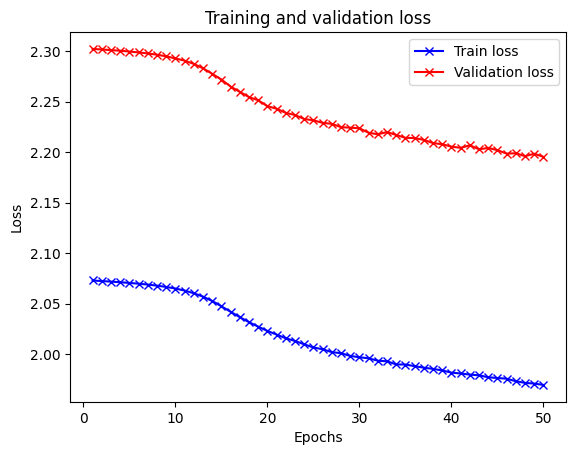

In [19]:
import matplotlib.pyplot as plt

# Define the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the train loss and val loss
plt.plot(epochs, train_loss, '-bx', label='Train loss')
plt.plot(epochs, validation_loss, '-rx', label='Validation loss')


# Set the title and labels for the graph
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()


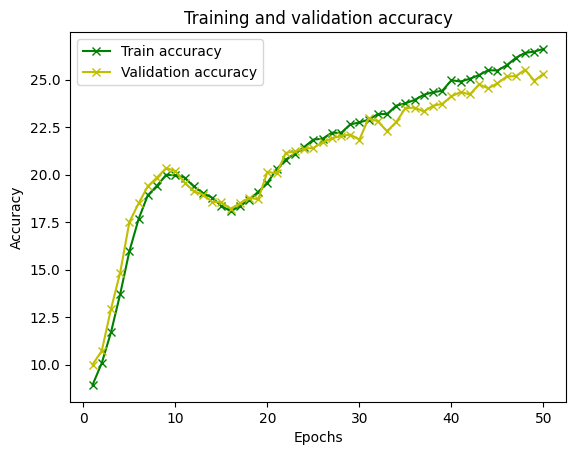

In [20]:
# Define the number of epochs
epochs = range(1, len(train_loss) + 1)
# Plot the train accuracy and val accuracy
plt.plot(epochs, train_accuracy, '-gx', label='Train accuracy')
plt.plot(epochs, validation_accuracy, '-yx', label='Validation accuracy')
# Set the title and labels for the graph
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()

# PandaNet1 using adam optimizer and ReLU activation

In [15]:
import torch.nn as nn
from torchsummary import summary

# Define the CNN architecture
class PandaNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1) #(depth of each conv2d,noof conv2d)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(p=0.5)
        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x))) #32*32
        x = self.pool(self.relu(self.conv2(x))) #16*16
        x = self.pool(self.relu(self.conv3(x))) #4*4
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return self.softmax(x)

# Create an instance of the CNN
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PandaNet = PandaNet().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(PandaNet.parameters(), lr=0.001)
summary(PandaNet)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            18,496
├─Conv2d: 1-3                            73,856
├─MaxPool2d: 1-4                         --
├─Linear: 1-5                            1,049,088
├─Linear: 1-6                            5,130
├─Dropout: 1-7                           --
├─Softmax: 1-8                           --
├─ReLU: 1-9                              --
Total params: 1,147,466
Trainable params: 1,147,466
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            18,496
├─Conv2d: 1-3                            73,856
├─MaxPool2d: 1-4                         --
├─Linear: 1-5                            1,049,088
├─Linear: 1-6                            5,130
├─Dropout: 1-7                           --
├─Softmax: 1-8                           --
├─ReLU: 1-9                              --
Total params: 1,147,466
Trainable params: 1,147,466
Non-trainable params: 0

In [16]:
from tqdm import tqdm
import time

start_time = time.time()

train_loss = []
train_accuracy = []
validation_loss = []
validation_accuracy = []

early_stopping = EarlyStopping(tolerance=5, min_delta=10)

for epoch in tqdm(range(20),desc="Loading..."):
    correct = 0
    total = 0
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = PandaNet(images)
        loss = criterion(outputs, labels)
        
        #checking Training Accuracy
        with torch.no_grad():
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    #testing val_acuuracy after each epoch
    total_val = 0
    correct_val = 0
    with torch.no_grad():
        for im_val,label_val in val_loader:
            im_val, label_val = im_val.to(device), label_val.to(device)
            output_val = PandaNet(im_val)
            val_loss = criterion(output_val, label_val)
            _, predicted_val = torch.max(output_val.data, 1)
            total_val += label_val.size(0)
            correct_val += (predicted_val == label_val).sum().item()

            
    print ('Epoch {} | Training Loss {:.2f} | Training Accuracy {:.2f}% | Validation Loss  {:.2f}| Validation Accuracy {}%'.format(epoch+1,running_loss/782,(100 * correct / total),(val_loss.item()),(100*correct_val/total_val)))
        
    train_loss.append(running_loss/782)
    train_accuracy.append(100 * correct / total)
    validation_loss.append(val_loss.item())
    validation_accuracy.append(100*correct_val/total_val)
    
    # early stopping
    early_stopping(running_loss/782, val_loss.item())
    if early_stopping.early_stop:
      print('early stop')
      break
        
torch.save(PandaNet.state_dict(), 'PandaNet2.pth')
    
end_time = time.time()
# Calculate the execution time
execution_time = end_time - start_time
# Print the execution time in seconds
print("Training time:", execution_time, "seconds")

Loading...:   5%|▌         | 1/20 [00:18<05:56, 18.77s/it]

Epoch 1 | Training Loss 1.91 | Training Accuracy 32.83% | Validation Loss  2.06| Validation Accuracy 39.16%


Loading...:  10%|█         | 2/20 [00:37<05:35, 18.62s/it]

Epoch 2 | Training Loss 1.81 | Training Accuracy 44.49% | Validation Loss  2.01| Validation Accuracy 44.52%


Loading...:  15%|█▌        | 3/20 [00:56<05:18, 18.73s/it]

Epoch 3 | Training Loss 1.76 | Training Accuracy 49.61% | Validation Loss  1.95| Validation Accuracy 50.0%


Loading...:  20%|██        | 4/20 [01:15<05:01, 18.84s/it]

Epoch 4 | Training Loss 1.73 | Training Accuracy 53.90% | Validation Loss  1.92| Validation Accuracy 53.8%


Loading...:  25%|██▌       | 5/20 [01:33<04:39, 18.66s/it]

Epoch 5 | Training Loss 1.71 | Training Accuracy 55.72% | Validation Loss  1.90| Validation Accuracy 55.82%


Loading...:  30%|███       | 6/20 [01:52<04:22, 18.75s/it]

Epoch 6 | Training Loss 1.69 | Training Accuracy 58.09% | Validation Loss  1.87| Validation Accuracy 58.6%


Loading...:  35%|███▌      | 7/20 [02:10<04:01, 18.60s/it]

Epoch 7 | Training Loss 1.68 | Training Accuracy 59.03% | Validation Loss  1.88| Validation Accuracy 57.62%


Loading...:  40%|████      | 8/20 [02:29<03:43, 18.58s/it]

Epoch 8 | Training Loss 1.66 | Training Accuracy 61.14% | Validation Loss  1.84| Validation Accuracy 61.76%


Loading...:  45%|████▌     | 9/20 [02:47<03:23, 18.48s/it]

Epoch 9 | Training Loss 1.65 | Training Accuracy 62.36% | Validation Loss  1.85| Validation Accuracy 61.08%


Loading...:  50%|█████     | 10/20 [03:06<03:06, 18.60s/it]

Epoch 10 | Training Loss 1.64 | Training Accuracy 63.36% | Validation Loss  1.88| Validation Accuracy 58.14%


Loading...:  55%|█████▌    | 11/20 [03:25<02:47, 18.64s/it]

Epoch 11 | Training Loss 1.64 | Training Accuracy 63.78% | Validation Loss  1.85| Validation Accuracy 61.42%


Loading...:  60%|██████    | 12/20 [03:43<02:28, 18.52s/it]

Epoch 12 | Training Loss 1.64 | Training Accuracy 63.79% | Validation Loss  1.84| Validation Accuracy 61.7%


Loading...:  65%|██████▌   | 13/20 [04:02<02:10, 18.68s/it]

Epoch 13 | Training Loss 1.64 | Training Accuracy 63.96% | Validation Loss  1.84| Validation Accuracy 61.8%


Loading...:  70%|███████   | 14/20 [04:20<01:51, 18.52s/it]

Epoch 14 | Training Loss 1.64 | Training Accuracy 63.44% | Validation Loss  1.84| Validation Accuracy 62.12%


Loading...:  75%|███████▌  | 15/20 [04:39<01:33, 18.68s/it]

Epoch 15 | Training Loss 1.63 | Training Accuracy 64.85% | Validation Loss  1.83| Validation Accuracy 62.86%


Loading...:  80%|████████  | 16/20 [04:58<01:14, 18.68s/it]

Epoch 16 | Training Loss 1.63 | Training Accuracy 65.01% | Validation Loss  1.83| Validation Accuracy 63.4%


Loading...:  85%|████████▌ | 17/20 [05:16<00:55, 18.57s/it]

Epoch 17 | Training Loss 1.63 | Training Accuracy 65.35% | Validation Loss  1.84| Validation Accuracy 62.0%


Loading...:  90%|█████████ | 18/20 [05:35<00:37, 18.66s/it]

Epoch 18 | Training Loss 1.63 | Training Accuracy 64.67% | Validation Loss  1.84| Validation Accuracy 62.4%


Loading...:  95%|█████████▌| 19/20 [05:54<00:18, 18.63s/it]

Epoch 19 | Training Loss 1.63 | Training Accuracy 64.81% | Validation Loss  1.83| Validation Accuracy 62.78%


Loading...: 100%|██████████| 20/20 [06:12<00:00, 18.65s/it]

Epoch 20 | Training Loss 1.63 | Training Accuracy 64.78% | Validation Loss  1.83| Validation Accuracy 62.74%
Training time: 372.99023723602295 seconds


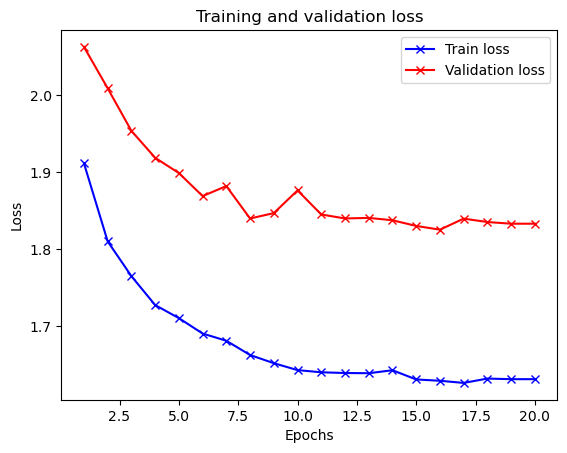

In [17]:
import matplotlib.pyplot as plt

# Define the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the train loss and val loss
plt.plot(epochs, train_loss, '-bx', label='Train loss')
plt.plot(epochs, validation_loss, '-rx', label='Validation loss')


# Set the title and labels for the graph
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()

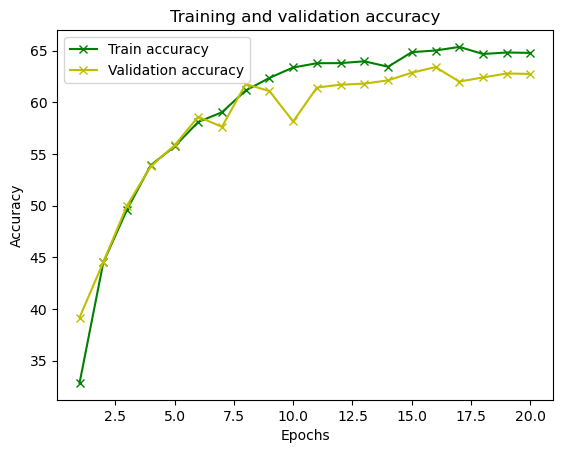

In [18]:
# Define the number of epochs
epochs = range(1, len(train_loss) + 1)
# Plot the train accuracy and val accuracy
plt.plot(epochs, train_accuracy, '-gx', label='Train accuracy')
plt.plot(epochs, validation_accuracy, '-yx', label='Validation accuracy')
# Set the title and labels for the graph
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()

In [19]:
# Evaluate the CNN on the test set
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = PandaNet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print the accuracy
print('Accuracy of the pre-trained CNN on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the pre-trained CNN on the 10000 test images: 63.12 %


# PandaNet1 using adam optimizer and tanh activation

In [23]:
import torch.nn as nn
from torchsummary import summary

# Define the CNN architecture
class PandaNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1) #(depth of each conv2d,noof conv2d)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(p=0.5)
        self.softmax = nn.Softmax(dim=1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.pool(self.tanh(self.conv1(x))) #32*32
        x = self.pool(self.tanh(self.conv2(x))) #16*16
        x = self.pool(self.tanh(self.conv3(x))) #4*4
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(self.tanh(self.fc1(x)))
        x = self.fc2(x)
        return self.softmax(x)

# Create an instance of the CNN
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PandaNet = PandaNet().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(PandaNet.parameters(), lr=0.001)
summary(PandaNet)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            18,496
├─Conv2d: 1-3                            73,856
├─MaxPool2d: 1-4                         --
├─Linear: 1-5                            1,049,088
├─Linear: 1-6                            5,130
├─Dropout: 1-7                           --
├─Softmax: 1-8                           --
├─Tanh: 1-9                              --
Total params: 1,147,466
Trainable params: 1,147,466
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            18,496
├─Conv2d: 1-3                            73,856
├─MaxPool2d: 1-4                         --
├─Linear: 1-5                            1,049,088
├─Linear: 1-6                            5,130
├─Dropout: 1-7                           --
├─Softmax: 1-8                           --
├─Tanh: 1-9                              --
Total params: 1,147,466
Trainable params: 1,147,466
Non-trainable params: 0

In [24]:
from tqdm import tqdm
import time

start_time = time.time()

train_loss = []
train_accuracy = []
validation_loss = []
validation_accuracy = []

early_stopping = EarlyStopping(tolerance=5, min_delta=10)

for epoch in tqdm(range(20),desc="Loading..."):
    correct = 0
    total = 0
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = PandaNet(images)
        loss = criterion(outputs, labels)
        
        #checking Training Accuracy
        with torch.no_grad():
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    #testing val_acuuracy after each epoch
    total_val = 0
    correct_val = 0
    with torch.no_grad():
        for im_val,label_val in val_loader:
            im_val, label_val = im_val.to(device), label_val.to(device)
            output_val = PandaNet(im_val)
            val_loss = criterion(output_val, label_val)
            _, predicted_val = torch.max(output_val.data, 1)
            total_val += label_val.size(0)
            correct_val += (predicted_val == label_val).sum().item()

            
    print ('Epoch {} | Training Loss {:.2f} | Training Accuracy {:.2f}% | Validation Loss  {:.2f}| Validation Accuracy {}%'.format(epoch+1,running_loss/782,(100 * correct / total),(val_loss.item()),(100*correct_val/total_val)))
        
    train_loss.append(running_loss/782)
    train_accuracy.append(100 * correct / total)
    validation_loss.append(val_loss.item())
    validation_accuracy.append(100*correct_val/total_val)
    
    # early stopping
    early_stopping(running_loss/782, val_loss.item())
    if early_stopping.early_stop:
      print('early stop')
      break
        
torch.save(PandaNet.state_dict(), 'PandaNet2.pth')
    
end_time = time.time()
# Calculate the execution time
execution_time = end_time - start_time
# Print the execution time in seconds
print("Training time:", execution_time, "seconds")

Loading...:   5%|▌         | 1/20 [00:19<06:06, 19.31s/it]

Epoch 1 | Training Loss 1.87 | Training Accuracy 37.49% | Validation Loss  2.02| Validation Accuracy 43.68%


Loading...:  10%|█         | 2/20 [00:39<05:57, 19.87s/it]

Epoch 2 | Training Loss 1.78 | Training Accuracy 47.85% | Validation Loss  1.95| Validation Accuracy 51.08%


Loading...:  15%|█▌        | 3/20 [00:59<05:36, 19.78s/it]

Epoch 3 | Training Loss 1.74 | Training Accuracy 52.22% | Validation Loss  1.93| Validation Accuracy 52.76%


Loading...:  20%|██        | 4/20 [01:18<05:10, 19.40s/it]

Epoch 4 | Training Loss 1.71 | Training Accuracy 55.72% | Validation Loss  1.91| Validation Accuracy 55.14%


Loading...:  25%|██▌       | 5/20 [01:37<04:51, 19.43s/it]

Epoch 5 | Training Loss 1.69 | Training Accuracy 58.10% | Validation Loss  1.88| Validation Accuracy 57.72%


Loading...:  30%|███       | 6/20 [01:56<04:30, 19.30s/it]

Epoch 6 | Training Loss 1.68 | Training Accuracy 59.93% | Validation Loss  1.86| Validation Accuracy 60.28%


Loading...:  35%|███▌      | 7/20 [02:15<04:11, 19.32s/it]

Epoch 7 | Training Loss 1.66 | Training Accuracy 61.59% | Validation Loss  1.85| Validation Accuracy 61.2%


Loading...:  40%|████      | 8/20 [02:35<03:51, 19.31s/it]

Epoch 8 | Training Loss 1.65 | Training Accuracy 62.57% | Validation Loss  1.85| Validation Accuracy 60.36%


Loading...:  45%|████▌     | 9/20 [02:53<03:30, 19.10s/it]

Epoch 9 | Training Loss 1.64 | Training Accuracy 63.68% | Validation Loss  1.85| Validation Accuracy 61.46%


Loading...:  50%|█████     | 10/20 [03:13<03:12, 19.23s/it]

Epoch 10 | Training Loss 1.64 | Training Accuracy 64.22% | Validation Loss  1.82| Validation Accuracy 64.18%


Loading...:  55%|█████▌    | 11/20 [03:32<02:51, 19.10s/it]

Epoch 11 | Training Loss 1.63 | Training Accuracy 65.16% | Validation Loss  1.82| Validation Accuracy 63.82%


Loading...:  60%|██████    | 12/20 [03:51<02:33, 19.16s/it]

Epoch 12 | Training Loss 1.63 | Training Accuracy 65.67% | Validation Loss  1.83| Validation Accuracy 63.34%


Loading...:  65%|██████▌   | 13/20 [04:10<02:13, 19.13s/it]

Epoch 13 | Training Loss 1.62 | Training Accuracy 65.78% | Validation Loss  1.83| Validation Accuracy 62.74%


Loading...:  70%|███████   | 14/20 [04:29<01:54, 19.05s/it]

Epoch 14 | Training Loss 1.62 | Training Accuracy 66.29% | Validation Loss  1.81| Validation Accuracy 65.04%


Loading...:  75%|███████▌  | 15/20 [04:49<01:36, 19.23s/it]

Epoch 15 | Training Loss 1.62 | Training Accuracy 66.55% | Validation Loss  1.82| Validation Accuracy 63.72%


Loading...:  80%|████████  | 16/20 [05:07<01:16, 19.10s/it]

Epoch 16 | Training Loss 1.62 | Training Accuracy 66.68% | Validation Loss  1.81| Validation Accuracy 65.4%


Loading...:  85%|████████▌ | 17/20 [05:27<00:57, 19.14s/it]

Epoch 17 | Training Loss 1.61 | Training Accuracy 67.39% | Validation Loss  1.81| Validation Accuracy 65.26%


Loading...:  90%|█████████ | 18/20 [05:46<00:38, 19.35s/it]

Epoch 18 | Training Loss 1.61 | Training Accuracy 67.35% | Validation Loss  1.81| Validation Accuracy 65.02%


Loading...:  95%|█████████▌| 19/20 [06:05<00:19, 19.15s/it]

Epoch 19 | Training Loss 1.61 | Training Accuracy 67.06% | Validation Loss  1.80| Validation Accuracy 66.46%


Loading...: 100%|██████████| 20/20 [06:24<00:00, 19.23s/it]

Epoch 20 | Training Loss 1.60 | Training Accuracy 67.88% | Validation Loss  1.79| Validation Accuracy 66.88%
Training time: 384.6999101638794 seconds


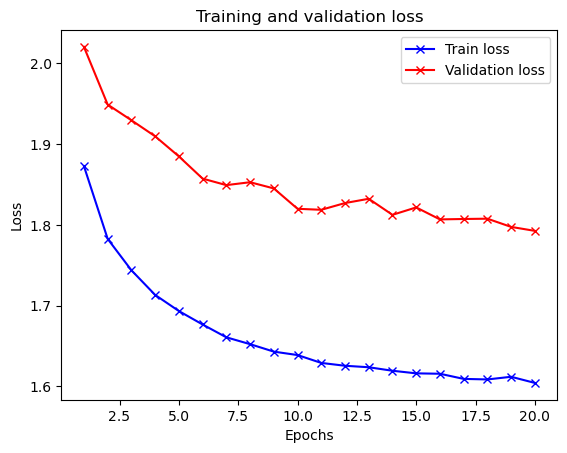

In [25]:
import matplotlib.pyplot as plt

# Define the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the train loss and val loss
plt.plot(epochs, train_loss, '-bx', label='Train loss')
plt.plot(epochs, validation_loss, '-rx', label='Validation loss')


# Set the title and labels for the graph
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()

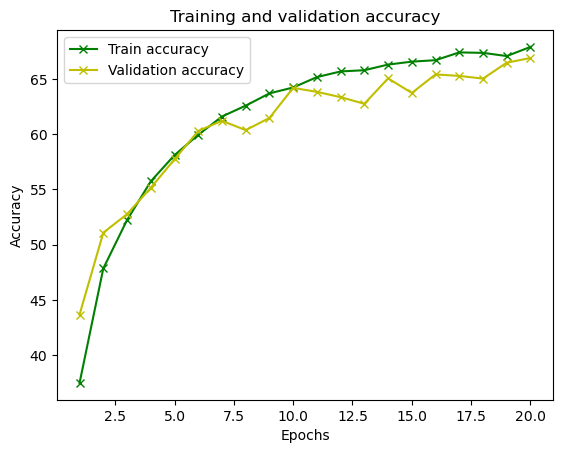

In [26]:
# Define the number of epochs
epochs = range(1, len(train_loss) + 1)
# Plot the train accuracy and val accuracy
plt.plot(epochs, train_accuracy, '-gx', label='Train accuracy')
plt.plot(epochs, validation_accuracy, '-yx', label='Validation accuracy')
# Set the title and labels for the graph
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()

In [27]:
# Evaluate the CNN on the test set
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = PandaNet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print the accuracy
print('Accuracy of the pre-trained CNN on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the pre-trained CNN on the 10000 test images: 67.59 %


# PandaNet1 using adam optimizer and sigmoid activation and xavier weight initialization

In [29]:
import torch.nn as nn
from torchsummary import summary

# Define the CNN architecture
class PandaNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1) #(depth of each conv2d,noof conv2d)
        nn.init.xavier_uniform_(self.conv1.weight, gain=nn.init.calculate_gain('sigmoid'))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        nn.init.xavier_uniform_(self.conv2.weight, gain=nn.init.calculate_gain('sigmoid'))
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        nn.init.xavier_uniform_(self.conv3.weight, gain=nn.init.calculate_gain('sigmoid'))
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        nn.init.xavier_uniform_(self.fc1.weight, gain=nn.init.calculate_gain('sigmoid'))
        self.fc2 = nn.Linear(512, 10)
        nn.init.xavier_uniform_(self.fc2.weight, gain=nn.init.calculate_gain('sigmoid'))
        self.dropout = nn.Dropout(p=0.5)
        self.softmax = nn.Softmax(dim=1)
        self.Sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(self.Sigmoid(self.conv1(x))) #32*32
        x = self.pool(self.Sigmoid(self.conv2(x))) #16*16
        x = self.pool(self.Sigmoid(self.conv3(x))) #4*4
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(self.Sigmoid(self.fc1(x)))
        x = self.fc2(x)
        return self.softmax(x)

# Create an instance of the CNN
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PandaNet = PandaNet().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(PandaNet.parameters(), lr=0.001)
summary(PandaNet)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            18,496
├─Conv2d: 1-3                            73,856
├─MaxPool2d: 1-4                         --
├─Linear: 1-5                            1,049,088
├─Linear: 1-6                            5,130
├─Dropout: 1-7                           --
├─Softmax: 1-8                           --
├─Sigmoid: 1-9                           --
Total params: 1,147,466
Trainable params: 1,147,466
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            18,496
├─Conv2d: 1-3                            73,856
├─MaxPool2d: 1-4                         --
├─Linear: 1-5                            1,049,088
├─Linear: 1-6                            5,130
├─Dropout: 1-7                           --
├─Softmax: 1-8                           --
├─Sigmoid: 1-9                           --
Total params: 1,147,466
Trainable params: 1,147,466
Non-trainable params: 0

In [30]:
from tqdm import tqdm
import time

start_time = time.time()

train_loss = []
train_accuracy = []
validation_loss = []
validation_accuracy = []

early_stopping = EarlyStopping(tolerance=5, min_delta=10)

for epoch in tqdm(range(20),desc="Loading..."):
    correct = 0
    total = 0
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = PandaNet(images)
        loss = criterion(outputs, labels)
        
        #checking Training Accuracy
        with torch.no_grad():
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    #testing val_acuuracy after each epoch
    total_val = 0
    correct_val = 0
    with torch.no_grad():
        for im_val,label_val in val_loader:
            im_val, label_val = im_val.to(device), label_val.to(device)
            output_val = PandaNet(im_val)
            val_loss = criterion(output_val, label_val)
            _, predicted_val = torch.max(output_val.data, 1)
            total_val += label_val.size(0)
            correct_val += (predicted_val == label_val).sum().item()

            
    print ('Epoch {} | Training Loss {:.2f} | Training Accuracy {:.2f}% | Validation Loss  {:.2f}| Validation Accuracy {}%'.format(epoch+1,running_loss/782,(100 * correct / total),(val_loss.item()),(100*correct_val/total_val)))
        
    train_loss.append(running_loss/782)
    train_accuracy.append(100 * correct / total)
    validation_loss.append(val_loss.item())
    validation_accuracy.append(100*correct_val/total_val)
    
    # early stopping
    early_stopping(running_loss/782, val_loss.item())
    if early_stopping.early_stop:
      print('early stop')
      break
        
torch.save(PandaNet.state_dict(), 'PandaNet3.pth')
    
end_time = time.time()
# Calculate the execution time
execution_time = end_time - start_time
# Print the execution time in seconds
print("Training time:", execution_time, "seconds")

Loading...:   5%|▌         | 1/20 [00:28<09:07, 28.81s/it]

Epoch 1 | Training Loss 2.00 | Training Accuracy 22.35% | Validation Loss  2.17| Validation Accuracy 27.98%


Loading...:  10%|█         | 2/20 [00:57<08:40, 28.90s/it]

Epoch 2 | Training Loss 1.93 | Training Accuracy 31.19% | Validation Loss  2.13| Validation Accuracy 32.06%


Loading...:  15%|█▌        | 3/20 [01:25<08:04, 28.51s/it]

Epoch 3 | Training Loss 1.90 | Training Accuracy 34.92% | Validation Loss  2.10| Validation Accuracy 35.48%


Loading...:  20%|██        | 4/20 [01:53<07:32, 28.28s/it]

Epoch 4 | Training Loss 1.87 | Training Accuracy 37.74% | Validation Loss  2.09| Validation Accuracy 36.66%


Loading...:  25%|██▌       | 5/20 [02:21<07:03, 28.22s/it]

Epoch 5 | Training Loss 1.85 | Training Accuracy 40.31% | Validation Loss  2.05| Validation Accuracy 40.56%


Loading...:  30%|███       | 6/20 [02:50<06:37, 28.39s/it]

Epoch 6 | Training Loss 1.83 | Training Accuracy 42.27% | Validation Loss  2.05| Validation Accuracy 40.54%


Loading...:  35%|███▌      | 7/20 [03:19<06:09, 28.45s/it]

Epoch 7 | Training Loss 1.82 | Training Accuracy 43.81% | Validation Loss  2.03| Validation Accuracy 42.7%


Loading...:  40%|████      | 8/20 [03:47<05:40, 28.36s/it]

Epoch 8 | Training Loss 1.81 | Training Accuracy 45.15% | Validation Loss  2.02| Validation Accuracy 44.2%


Loading...:  45%|████▌     | 9/20 [04:15<05:12, 28.44s/it]

Epoch 9 | Training Loss 1.80 | Training Accuracy 45.86% | Validation Loss  2.01| Validation Accuracy 44.34%


Loading...:  50%|█████     | 10/20 [04:43<04:42, 28.30s/it]

Epoch 10 | Training Loss 1.79 | Training Accuracy 47.08% | Validation Loss  2.00| Validation Accuracy 45.4%


Loading...:  55%|█████▌    | 11/20 [05:12<04:15, 28.38s/it]

Epoch 11 | Training Loss 1.78 | Training Accuracy 47.97% | Validation Loss  1.99| Validation Accuracy 46.86%


Loading...:  60%|██████    | 12/20 [05:40<03:45, 28.13s/it]

Epoch 12 | Training Loss 1.78 | Training Accuracy 48.71% | Validation Loss  1.99| Validation Accuracy 47.1%


Loading...:  65%|██████▌   | 13/20 [06:07<03:16, 28.03s/it]

Epoch 13 | Training Loss 1.77 | Training Accuracy 49.47% | Validation Loss  1.98| Validation Accuracy 47.58%


Loading...:  70%|███████   | 14/20 [06:36<02:48, 28.15s/it]

Epoch 14 | Training Loss 1.76 | Training Accuracy 50.34% | Validation Loss  1.96| Validation Accuracy 49.2%


Loading...:  75%|███████▌  | 15/20 [07:04<02:21, 28.21s/it]

Epoch 15 | Training Loss 1.75 | Training Accuracy 50.96% | Validation Loss  1.96| Validation Accuracy 50.22%


Loading...:  80%|████████  | 16/20 [07:32<01:52, 28.23s/it]

Epoch 16 | Training Loss 1.75 | Training Accuracy 52.22% | Validation Loss  1.95| Validation Accuracy 50.68%


Loading...:  85%|████████▌ | 17/20 [08:01<01:24, 28.21s/it]

Epoch 17 | Training Loss 1.74 | Training Accuracy 52.78% | Validation Loss  1.96| Validation Accuracy 50.2%


Loading...:  90%|█████████ | 18/20 [08:29<00:56, 28.28s/it]

Epoch 18 | Training Loss 1.73 | Training Accuracy 53.36% | Validation Loss  1.95| Validation Accuracy 51.4%


Loading...:  95%|█████████▌| 19/20 [08:57<00:28, 28.12s/it]

Epoch 19 | Training Loss 1.73 | Training Accuracy 54.02% | Validation Loss  1.94| Validation Accuracy 52.34%


Loading...: 100%|██████████| 20/20 [09:24<00:00, 28.23s/it]

Epoch 20 | Training Loss 1.72 | Training Accuracy 55.22% | Validation Loss  1.93| Validation Accuracy 53.32%
Training time: 564.7130672931671 seconds


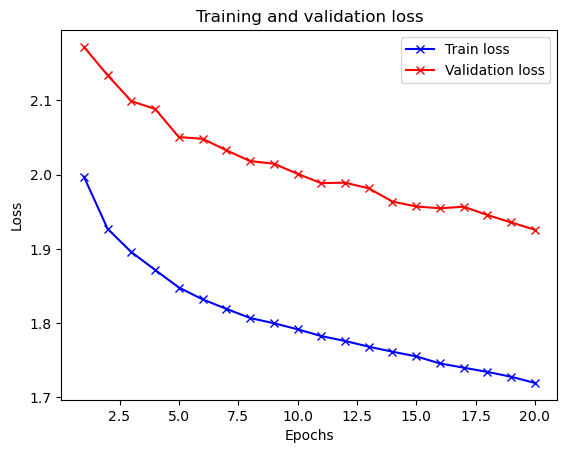

In [31]:
import matplotlib.pyplot as plt

# Define the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the train loss and val loss
plt.plot(epochs, train_loss, '-bx', label='Train loss')
plt.plot(epochs, validation_loss, '-rx', label='Validation loss')


# Set the title and labels for the graph
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()

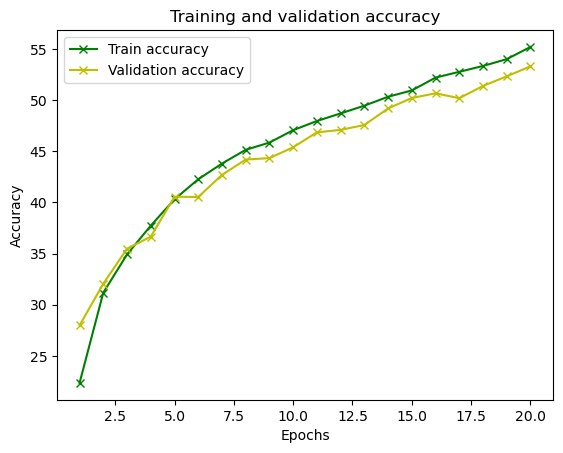

In [32]:
# Define the number of epochs
epochs = range(1, len(train_loss) + 1)
# Plot the train accuracy and val accuracy
plt.plot(epochs, train_accuracy, '-gx', label='Train accuracy')
plt.plot(epochs, validation_accuracy, '-yx', label='Validation accuracy')
# Set the title and labels for the graph
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()

In [33]:
# Evaluate the CNN on the test set
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = PandaNet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print the accuracy
print('Accuracy of the pre-trained CNN on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the pre-trained CNN on the 10000 test images: 54.02 %


# PandaNet1 using adam optimizer and ReLU activation and He weight initialization¶

In [37]:
import torch.nn as nn
from torchsummary import summary

# Define the CNN architecture
class PandaNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1) #(depth of each conv2d,noof conv2d)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(p=0.5)
        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()
        
        # Initialize the weights using He initialization
        nn.init.kaiming_normal_(self.conv1.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv3.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x))) #32*32
        x = self.pool(self.relu(self.conv2(x))) #16*16
        x = self.pool(self.relu(self.conv3(x))) #4*4
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return self.softmax(x)

# Create an instance of the CNN
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PandaNet = PandaNet().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(PandaNet.parameters(), lr=0.001)
summary(PandaNet)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            18,496
├─Conv2d: 1-3                            73,856
├─MaxPool2d: 1-4                         --
├─Linear: 1-5                            1,049,088
├─Linear: 1-6                            5,130
├─Dropout: 1-7                           --
├─Softmax: 1-8                           --
├─ReLU: 1-9                              --
Total params: 1,147,466
Trainable params: 1,147,466
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            18,496
├─Conv2d: 1-3                            73,856
├─MaxPool2d: 1-4                         --
├─Linear: 1-5                            1,049,088
├─Linear: 1-6                            5,130
├─Dropout: 1-7                           --
├─Softmax: 1-8                           --
├─ReLU: 1-9                              --
Total params: 1,147,466
Trainable params: 1,147,466
Non-trainable params: 0

In [38]:
from tqdm import tqdm
import time

start_time = time.time()

train_loss = []
train_accuracy = []
validation_loss = []
validation_accuracy = []

early_stopping = EarlyStopping(tolerance=5, min_delta=10)

for epoch in tqdm(range(20),desc="Loading..."):
    correct = 0
    total = 0
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = PandaNet(images)
        loss = criterion(outputs, labels)
        
        #checking Training Accuracy
        with torch.no_grad():
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    #testing val_acuuracy after each epoch
    total_val = 0
    correct_val = 0
    with torch.no_grad():
        for im_val,label_val in val_loader:
            im_val, label_val = im_val.to(device), label_val.to(device)
            output_val = PandaNet(im_val)
            val_loss = criterion(output_val, label_val)
            _, predicted_val = torch.max(output_val.data, 1)
            total_val += label_val.size(0)
            correct_val += (predicted_val == label_val).sum().item()

            
    print ('Epoch {} | Training Loss {:.2f} | Training Accuracy {:.2f}% | Validation Loss  {:.2f}| Validation Accuracy {}%'.format(epoch+1,running_loss/782,(100 * correct / total),(val_loss.item()),(100*correct_val/total_val)))
        
    train_loss.append(running_loss/782)
    train_accuracy.append(100 * correct / total)
    validation_loss.append(val_loss.item())
    validation_accuracy.append(100*correct_val/total_val)
    
    # early stopping
    early_stopping(running_loss/782, val_loss.item())
    if early_stopping.early_stop:
      print('early stop')
      break
        
torch.save(PandaNet.state_dict(), 'PandaNet4.pth')
    
end_time = time.time()
# Calculate the execution time
execution_time = end_time - start_time
# Print the execution time in seconds
print("Training time:", execution_time, "seconds")

Loading...:   0%|          | 0/20 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f064e701a70>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Loading...:   5%|▌         | 1/20 [00:29<09:17, 29.32s/it]

Epoch 1 | Training Loss 2.13 | Training Accuracy 9.98% | Validation Loss  2.36| Validation Accuracy 10.1%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f064e701a70>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Loading...:  10%|█         | 2/20 [00:58<08:50, 29.49s/it]

Epoch 2 | Training Loss 2.13 | Training Accuracy 9.99% | Validation Loss  2.36| Validation Accuracy 10.1%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f064e701a70>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Loading...:  15%|█▌        | 3/20 [01:27<08:13, 29.03s/it]

Epoch 3 | Training Loss 2.13 | Training Accuracy 9.99% | Validation Loss  2.36| Validation Accuracy 10.1%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f064e701a70>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Loading...:  20%|██        | 4/20 [01:55<07:41, 28.85s/it]

Epoch 4 | Training Loss 2.13 | Training Accuracy 9.99% | Validation Loss  2.36| Validation Accuracy 10.1%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f064e701a70>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Loading...:  25%|██▌       | 5/20 [02:23<07:03, 28.25s/it]

Epoch 5 | Training Loss 2.13 | Training Accuracy 9.99% | Validation Loss  2.36| Validation Accuracy 10.1%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f064e701a70>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Loading...:  30%|███       | 6/20 [02:51<06:36, 28.32s/it]

Epoch 6 | Training Loss 2.13 | Training Accuracy 9.99% | Validation Loss  2.36| Validation Accuracy 10.1%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f064e701a70>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Loading...:  35%|███▌      | 7/20 [03:19<06:08, 28.31s/it]

Epoch 7 | Training Loss 2.13 | Training Accuracy 9.99% | Validation Loss  2.36| Validation Accuracy 10.1%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f064e701a70>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Loading...:  40%|████      | 8/20 [03:48<05:39, 28.31s/it]

Epoch 8 | Training Loss 2.13 | Training Accuracy 9.99% | Validation Loss  2.36| Validation Accuracy 10.1%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f064e701a70>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Loading...:  45%|████▌     | 9/20 [04:16<05:12, 28.39s/it]

Epoch 9 | Training Loss 2.13 | Training Accuracy 9.99% | Validation Loss  2.36| Validation Accuracy 10.1%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f064e701a70>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Loading...:  50%|█████     | 10/20 [04:44<04:41, 28.19s/it]

Epoch 10 | Training Loss 2.13 | Training Accuracy 9.99% | Validation Loss  2.36| Validation Accuracy 10.1%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f064e701a70>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Loading...:  55%|█████▌    | 11/20 [05:13<04:14, 28.28s/it]

Epoch 11 | Training Loss 2.13 | Training Accuracy 9.99% | Validation Loss  2.36| Validation Accuracy 10.1%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f064e701a70>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Loading...:  60%|██████    | 12/20 [05:40<03:45, 28.15s/it]

Epoch 12 | Training Loss 2.13 | Training Accuracy 9.99% | Validation Loss  2.36| Validation Accuracy 10.1%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f064e701a70>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Loading...:  65%|██████▌   | 13/20 [06:08<03:15, 27.94s/it]

Epoch 13 | Training Loss 2.13 | Training Accuracy 9.99% | Validation Loss  2.36| Validation Accuracy 10.1%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f064e701a70>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Loading...:  70%|███████   | 14/20 [06:36<02:48, 28.04s/it]

Epoch 14 | Training Loss 2.13 | Training Accuracy 9.99% | Validation Loss  2.36| Validation Accuracy 10.1%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f064e701a70>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Loading...:  75%|███████▌  | 15/20 [07:05<02:21, 28.24s/it]

Epoch 15 | Training Loss 2.13 | Training Accuracy 9.99% | Validation Loss  2.36| Validation Accuracy 10.1%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f064e701a70>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Loading...:  80%|████████  | 16/20 [07:33<01:53, 28.32s/it]

Epoch 16 | Training Loss 2.13 | Training Accuracy 9.99% | Validation Loss  2.36| Validation Accuracy 10.1%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f064e701a70>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Loading...:  85%|████████▌ | 17/20 [08:01<01:24, 28.25s/it]

Epoch 17 | Training Loss 2.13 | Training Accuracy 9.99% | Validation Loss  2.36| Validation Accuracy 10.1%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f064e701a70>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Loading...:  90%|█████████ | 18/20 [08:30<00:56, 28.31s/it]

Epoch 18 | Training Loss 2.13 | Training Accuracy 9.99% | Validation Loss  2.36| Validation Accuracy 10.1%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f064e701a70>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Loading...:  95%|█████████▌| 19/20 [08:59<00:28, 28.47s/it]

Epoch 19 | Training Loss 2.13 | Training Accuracy 9.99% | Validation Loss  2.36| Validation Accuracy 10.1%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f064e701a70>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Loading...: 100%|██████████| 20/20 [09:27<00:00, 28.38s/it]

Epoch 20 | Training Loss 2.13 | Training Accuracy 9.99% | Validation Loss  2.36| Validation Accuracy 10.1%
Training time: 567.5785703659058 seconds


Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


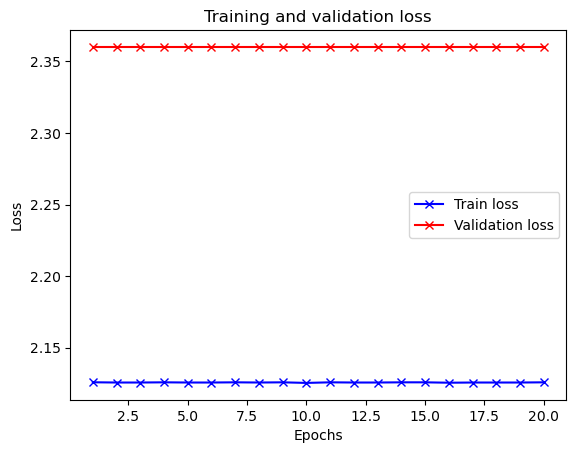

In [39]:
import matplotlib.pyplot as plt

# Define the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the train loss and val loss
plt.plot(epochs, train_loss, '-bx', label='Train loss')
plt.plot(epochs, validation_loss, '-rx', label='Validation loss')


# Set the title and labels for the graph
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()

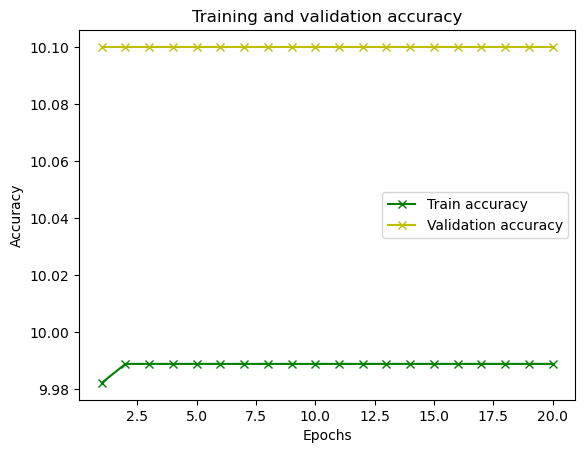

In [40]:
# Define the number of epochs
epochs = range(1, len(train_loss) + 1)
# Plot the train accuracy and val accuracy
plt.plot(epochs, train_accuracy, '-gx', label='Train accuracy')
plt.plot(epochs, validation_accuracy, '-yx', label='Validation accuracy')
# Set the title and labels for the graph
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()

In [41]:
# Evaluate the CNN on the test set
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = PandaNet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print the accuracy
print('Accuracy of the pre-trained CNN on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the pre-trained CNN on the 10000 test images: 10.0 %


# Using Skip Connections in PandaNet

In [52]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input
    
    
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)


class PandaNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out
    
# Create an instance of the CNN
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PandaNet = PandaNet(3,10).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(PandaNet.parameters(), lr=0.001,momentum =0.9)
summary(PandaNet)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-4                       73,856
|    └─BatchNorm2d: 2-5                  256
|    └─ReLU: 2-6                         --
|    └─MaxPool2d: 2-7                    --
├─Sequential: 1-3                        --
|    └─Sequential: 2-8                   --
|    |    └─Conv2d: 3-1                  147,584
|    |    └─BatchNorm2d: 3-2             256
|    |    └─ReLU: 3-3                    --
|    └─Sequential: 2-9                   --
|    |    └─Conv2d: 3-4                  147,584
|    |    └─BatchNorm2d: 3-5             256
|    |    └─ReLU: 3-6                    --
├─Sequential: 1-4                        --
|    └─Conv2d: 2-10                      295,168
|    └─BatchNorm2d: 2-11                 512


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-4                       73,856
|    └─BatchNorm2d: 2-5                  256
|    └─ReLU: 2-6                         --
|    └─MaxPool2d: 2-7                    --
├─Sequential: 1-3                        --
|    └─Sequential: 2-8                   --
|    |    └─Conv2d: 3-1                  147,584
|    |    └─BatchNorm2d: 3-2             256
|    |    └─ReLU: 3-3                    --
|    └─Sequential: 2-9                   --
|    |    └─Conv2d: 3-4                  147,584
|    |    └─BatchNorm2d: 3-5             256
|    |    └─ReLU: 3-6                    --
├─Sequential: 1-4                        --
|    └─Conv2d: 2-10                      295,168
|    └─BatchNorm2d: 2-11                 512


In [53]:
from tqdm import tqdm
import time

start_time = time.time()

train_loss = []
train_accuracy = []
validation_loss = []
validation_accuracy = []

early_stopping = EarlyStopping(tolerance=5, min_delta=10)

for epoch in tqdm(range(40),desc="Loading..."):
    correct = 0
    total = 0
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = PandaNet(images)
        loss = criterion(outputs, labels)
        
        #checking Training Accuracy
        with torch.no_grad():
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    #testing val_acuuracy after each epoch
    total_val = 0
    correct_val = 0
    with torch.no_grad():
        for im_val,label_val in val_loader:
            im_val, label_val = im_val.to(device), label_val.to(device)
            output_val = PandaNet(im_val)
            val_loss = criterion(output_val, label_val)
            _, predicted_val = torch.max(output_val.data, 1)
            total_val += label_val.size(0)
            correct_val += (predicted_val == label_val).sum().item()

            
    print ('Epoch {} | Training Loss {:.2f} | Training Accuracy {:.2f}% | Validation Loss  {:.2f}| Validation Accuracy {}%'.format(epoch+1,running_loss/782,(100 * correct / total),(val_loss.item()),(100*correct_val/total_val)))
        
    train_loss.append(running_loss/782)
    train_accuracy.append(100 * correct / total)
    validation_loss.append(val_loss.item())
    validation_accuracy.append(100*correct_val/total_val)
    
    # early stopping
    early_stopping(running_loss/782, val_loss.item())
    if early_stopping.early_stop:
      print('early stop')
      break
        
torch.save(PandaNet.state_dict(), 'PandaNet5.pth')
    
end_time = time.time()
# Calculate the execution time
execution_time = end_time - start_time
# Print the execution time in seconds
print("Training time:", execution_time, "seconds")

Loading...:   2%|▎         | 1/40 [00:33<21:47, 33.53s/it]

Epoch 1 | Training Loss 1.93 | Training Accuracy 21.08% | Validation Loss  1.97| Validation Accuracy 29.54%


Loading...:   5%|▌         | 2/40 [01:06<21:06, 33.33s/it]

Epoch 2 | Training Loss 1.63 | Training Accuracy 34.91% | Validation Loss  1.72| Validation Accuracy 37.02%


Loading...:   8%|▊         | 3/40 [01:40<20:33, 33.33s/it]

Epoch 3 | Training Loss 1.44 | Training Accuracy 41.86% | Validation Loss  1.64| Validation Accuracy 41.18%


Loading...:  10%|█         | 4/40 [02:13<19:59, 33.31s/it]

Epoch 4 | Training Loss 1.34 | Training Accuracy 46.28% | Validation Loss  1.47| Validation Accuracy 46.9%


Loading...:  12%|█▎        | 5/40 [02:46<19:21, 33.18s/it]

Epoch 5 | Training Loss 1.25 | Training Accuracy 49.90% | Validation Loss  1.37| Validation Accuracy 50.6%


Loading...:  15%|█▌        | 6/40 [03:19<18:45, 33.11s/it]

Epoch 6 | Training Loss 1.16 | Training Accuracy 53.99% | Validation Loss  1.34| Validation Accuracy 51.48%


Loading...:  18%|█▊        | 7/40 [03:52<18:16, 33.24s/it]

Epoch 7 | Training Loss 1.09 | Training Accuracy 56.68% | Validation Loss  1.21| Validation Accuracy 56.34%


Loading...:  20%|██        | 8/40 [04:26<17:44, 33.26s/it]

Epoch 8 | Training Loss 1.02 | Training Accuracy 60.01% | Validation Loss  1.21| Validation Accuracy 56.36%


Loading...:  22%|██▎       | 9/40 [04:59<17:09, 33.21s/it]

Epoch 9 | Training Loss 0.95 | Training Accuracy 62.94% | Validation Loss  1.10| Validation Accuracy 60.6%


Loading...:  25%|██▌       | 10/40 [05:32<16:38, 33.30s/it]

Epoch 10 | Training Loss 0.88 | Training Accuracy 65.39% | Validation Loss  1.03| Validation Accuracy 64.68%


Loading...:  28%|██▊       | 11/40 [06:05<16:03, 33.23s/it]

Epoch 11 | Training Loss 0.82 | Training Accuracy 67.88% | Validation Loss  0.92| Validation Accuracy 67.56%


Loading...:  30%|███       | 12/40 [06:38<15:26, 33.08s/it]

Epoch 12 | Training Loss 0.76 | Training Accuracy 70.54% | Validation Loss  0.89| Validation Accuracy 68.28%


Loading...:  32%|███▎      | 13/40 [07:11<14:50, 32.97s/it]

Epoch 13 | Training Loss 0.71 | Training Accuracy 72.59% | Validation Loss  0.90| Validation Accuracy 68.56%


Loading...:  35%|███▌      | 14/40 [07:44<14:18, 33.03s/it]

Epoch 14 | Training Loss 0.67 | Training Accuracy 74.45% | Validation Loss  0.78| Validation Accuracy 72.92%


Loading...:  38%|███▊      | 15/40 [08:17<13:44, 32.97s/it]

Epoch 15 | Training Loss 0.63 | Training Accuracy 75.77% | Validation Loss  0.75| Validation Accuracy 74.06%


Loading...:  40%|████      | 16/40 [08:50<13:12, 33.00s/it]

Epoch 16 | Training Loss 0.59 | Training Accuracy 77.24% | Validation Loss  0.72| Validation Accuracy 74.7%


Loading...:  42%|████▎     | 17/40 [09:23<12:39, 33.01s/it]

Epoch 17 | Training Loss 0.57 | Training Accuracy 78.12% | Validation Loss  0.69| Validation Accuracy 76.22%


Loading...:  45%|████▌     | 18/40 [09:56<12:06, 33.01s/it]

Epoch 18 | Training Loss 0.54 | Training Accuracy 79.38% | Validation Loss  0.66| Validation Accuracy 77.12%


Loading...:  48%|████▊     | 19/40 [10:29<11:32, 32.99s/it]

Epoch 19 | Training Loss 0.51 | Training Accuracy 80.26% | Validation Loss  0.71| Validation Accuracy 76.12%


Loading...:  50%|█████     | 20/40 [11:01<10:57, 32.89s/it]

Epoch 20 | Training Loss 0.49 | Training Accuracy 81.30% | Validation Loss  0.62| Validation Accuracy 79.62%


Loading...:  52%|█████▎    | 21/40 [11:35<10:26, 32.98s/it]

Epoch 21 | Training Loss 0.47 | Training Accuracy 82.07% | Validation Loss  0.61| Validation Accuracy 78.74%


Loading...:  55%|█████▌    | 22/40 [12:07<09:53, 32.96s/it]

Epoch 22 | Training Loss 0.45 | Training Accuracy 83.06% | Validation Loss  0.58| Validation Accuracy 80.46%


Loading...:  57%|█████▊    | 23/40 [12:40<09:19, 32.93s/it]

Epoch 23 | Training Loss 0.44 | Training Accuracy 83.01% | Validation Loss  0.64| Validation Accuracy 78.3%


Loading...:  60%|██████    | 24/40 [13:13<08:46, 32.88s/it]

Epoch 24 | Training Loss 0.41 | Training Accuracy 84.12% | Validation Loss  0.60| Validation Accuracy 79.88%


Loading...:  62%|██████▎   | 25/40 [13:46<08:14, 32.96s/it]

Epoch 25 | Training Loss 0.39 | Training Accuracy 85.00% | Validation Loss  0.55| Validation Accuracy 81.54%


Loading...:  65%|██████▌   | 26/40 [14:19<07:41, 32.96s/it]

Epoch 26 | Training Loss 0.38 | Training Accuracy 85.42% | Validation Loss  0.56| Validation Accuracy 80.96%


Loading...:  68%|██████▊   | 27/40 [14:52<07:08, 32.99s/it]

Epoch 27 | Training Loss 0.37 | Training Accuracy 85.86% | Validation Loss  0.54| Validation Accuracy 82.08%


Loading...:  70%|███████   | 28/40 [15:25<06:35, 32.95s/it]

Epoch 28 | Training Loss 0.35 | Training Accuracy 86.67% | Validation Loss  0.62| Validation Accuracy 78.72%


Loading...:  72%|███████▎  | 29/40 [15:59<06:04, 33.12s/it]

Epoch 29 | Training Loss 0.34 | Training Accuracy 86.96% | Validation Loss  0.50| Validation Accuracy 83.28%


Loading...:  75%|███████▌  | 30/40 [16:31<05:29, 32.98s/it]

Epoch 30 | Training Loss 0.32 | Training Accuracy 87.66% | Validation Loss  0.50| Validation Accuracy 82.42%


Loading...:  78%|███████▊  | 31/40 [17:04<04:55, 32.86s/it]

Epoch 31 | Training Loss 0.31 | Training Accuracy 88.05% | Validation Loss  0.50| Validation Accuracy 83.78%


Loading...:  80%|████████  | 32/40 [17:37<04:22, 32.87s/it]

Epoch 32 | Training Loss 0.30 | Training Accuracy 88.54% | Validation Loss  0.50| Validation Accuracy 83.78%


Loading...:  82%|████████▎ | 33/40 [18:09<03:49, 32.80s/it]

Epoch 33 | Training Loss 0.29 | Training Accuracy 88.90% | Validation Loss  0.48| Validation Accuracy 84.42%


Loading...:  85%|████████▌ | 34/40 [18:42<03:16, 32.75s/it]

Epoch 34 | Training Loss 0.28 | Training Accuracy 89.26% | Validation Loss  0.48| Validation Accuracy 84.12%


Loading...:  88%|████████▊ | 35/40 [19:15<02:43, 32.73s/it]

Epoch 35 | Training Loss 0.26 | Training Accuracy 89.74% | Validation Loss  0.52| Validation Accuracy 83.02%


Loading...:  90%|█████████ | 36/40 [19:48<02:11, 32.87s/it]

Epoch 36 | Training Loss 0.25 | Training Accuracy 90.08% | Validation Loss  0.50| Validation Accuracy 83.66%


Loading...:  92%|█████████▎| 37/40 [20:21<01:38, 32.90s/it]

Epoch 37 | Training Loss 0.24 | Training Accuracy 90.46% | Validation Loss  0.49| Validation Accuracy 84.86%


Loading...:  95%|█████████▌| 38/40 [20:54<01:05, 32.93s/it]

Epoch 38 | Training Loss 0.24 | Training Accuracy 90.80% | Validation Loss  0.50| Validation Accuracy 83.38%


Loading...:  98%|█████████▊| 39/40 [21:27<00:32, 32.93s/it]

Epoch 39 | Training Loss 0.22 | Training Accuracy 91.40% | Validation Loss  0.48| Validation Accuracy 84.12%


Loading...: 100%|██████████| 40/40 [22:00<00:00, 33.01s/it]

Epoch 40 | Training Loss 0.21 | Training Accuracy 91.60% | Validation Loss  0.51| Validation Accuracy 84.04%
Training time: 1320.6343920230865 seconds


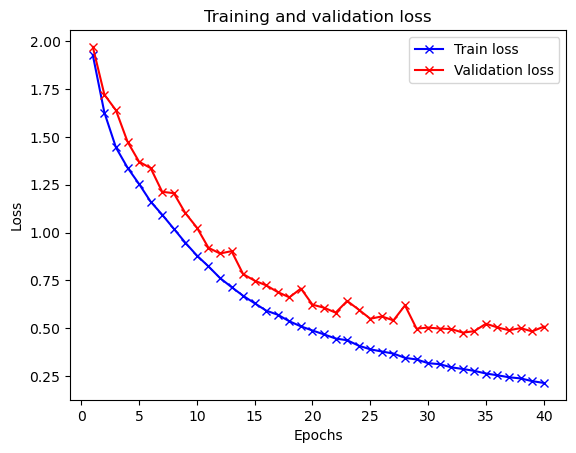

In [54]:
import matplotlib.pyplot as plt

# Define the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the train loss and val loss
plt.plot(epochs, train_loss, '-bx', label='Train loss')
plt.plot(epochs, validation_loss, '-rx', label='Validation loss')


# Set the title and labels for the graph
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()

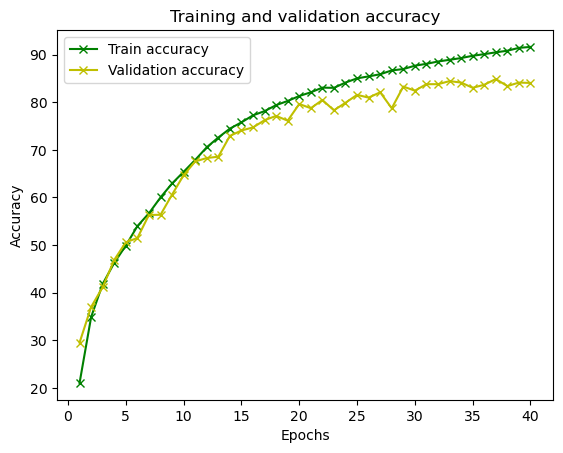

In [55]:
epochs = range(1, len(train_loss) + 1)
# Plot the train accuracy and val accuracy
plt.plot(epochs, train_accuracy, '-gx', label='Train accuracy')
plt.plot(epochs, validation_accuracy, '-yx', label='Validation accuracy')
# Set the title and labels for the graph
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()

In [56]:
# Evaluate the CNN on the test set
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = PandaNet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print the accuracy
print('Accuracy of the pre-trained CNN on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the pre-trained CNN on the 10000 test images: 83.64 %


# PandaNet2 with ReLU and SGD with momentum

In [68]:
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F

# Define the CNN architecture
class PandaNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1) #(depth of each conv2d,noof conv2d)
        self.conv2 = nn.Conv2d(64,128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 4 * 4,128)
        self.fc2 = nn.Linear(128,256)
        self.fc3 = nn.Linear(256, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x))) #32*32
        x = self.pool(self.relu(self.conv2(x))) #16*16
        x = self.pool(self.relu(self.conv3(x))) #4*4
        x = x.view(-1, 256 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)

# Create an instance of the CNN
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PandaNet = PandaNet().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(PandaNet.parameters(), lr=0.001, momentum=0.9)
summary(PandaNet)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            1,792
├─Conv2d: 1-2                            73,856
├─Conv2d: 1-3                            295,168
├─MaxPool2d: 1-4                         --
├─Linear: 1-5                            524,416
├─Linear: 1-6                            33,024
├─Linear: 1-7                            2,570
├─ReLU: 1-8                              --
Total params: 930,826
Trainable params: 930,826
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            1,792
├─Conv2d: 1-2                            73,856
├─Conv2d: 1-3                            295,168
├─MaxPool2d: 1-4                         --
├─Linear: 1-5                            524,416
├─Linear: 1-6                            33,024
├─Linear: 1-7                            2,570
├─ReLU: 1-8                              --
Total params: 930,826
Trainable params: 930,826
Non-trainable params: 0

In [69]:
from tqdm import tqdm
import time

start_time = time.time()

train_loss = []
train_accuracy = []
validation_loss = []
validation_accuracy = []

early_stopping = EarlyStopping(tolerance=5, min_delta=10)

for epoch in tqdm(range(40),desc="Loading..."):
    correct = 0
    total = 0
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = PandaNet(images)
        loss = criterion(outputs, labels)
        
        #checking Training Accuracy
        with torch.no_grad():
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    #testing val_acuuracy after each epoch
    total_val = 0
    correct_val = 0
    with torch.no_grad():
        for im_val,label_val in val_loader:
            im_val, label_val = im_val.to(device), label_val.to(device)
            output_val = PandaNet(im_val)
            val_loss = criterion(output_val, label_val)
            _, predicted_val = torch.max(output_val.data, 1)
            total_val += label_val.size(0)
            correct_val += (predicted_val == label_val).sum().item()

            
    print ('Epoch {} | Training Loss {:.2f} | Training Accuracy {:.2f}% | Validation Loss  {:.2f}| Validation Accuracy {}%'.format(epoch+1,running_loss/782,(100 * correct / total),(val_loss.item()),(100*correct_val/total_val)))
        
    train_loss.append(running_loss/782)
    train_accuracy.append(100 * correct / total)
    validation_loss.append(val_loss.item())
    validation_accuracy.append(100*correct_val/total_val)
    
    # early stopping
    early_stopping(running_loss/782, val_loss.item())
    if early_stopping.early_stop:
      print('early stop')
      break
        
torch.save(PandaNet.state_dict(), 'PandaNet3.pth')
    
end_time = time.time()
# Calculate the execution time
execution_time = end_time - start_time
# Print the execution time in seconds
print("Training time:", execution_time, "seconds")

Loading...:   2%|▎         | 1/40 [00:28<18:40, 28.74s/it]

Epoch 1 | Training Loss 1.98 | Training Accuracy 19.97% | Validation Loss  2.00| Validation Accuracy 27.32%


Loading...:   5%|▌         | 2/40 [00:57<18:07, 28.61s/it]

Epoch 2 | Training Loss 1.68 | Training Accuracy 30.96% | Validation Loss  1.75| Validation Accuracy 35.36%


Loading...:   8%|▊         | 3/40 [01:26<17:41, 28.70s/it]

Epoch 3 | Training Loss 1.50 | Training Accuracy 38.44% | Validation Loss  1.66| Validation Accuracy 38.26%


Loading...:  10%|█         | 4/40 [01:54<17:09, 28.59s/it]

Epoch 4 | Training Loss 1.38 | Training Accuracy 43.62% | Validation Loss  1.56| Validation Accuracy 43.32%


Loading...:  12%|█▎        | 5/40 [02:23<16:44, 28.71s/it]

Epoch 5 | Training Loss 1.31 | Training Accuracy 46.83% | Validation Loss  1.43| Validation Accuracy 47.1%


Loading...:  15%|█▌        | 6/40 [02:52<16:15, 28.68s/it]

Epoch 6 | Training Loss 1.24 | Training Accuracy 50.14% | Validation Loss  1.37| Validation Accuracy 50.16%


Loading...:  18%|█▊        | 7/40 [03:20<15:41, 28.53s/it]

Epoch 7 | Training Loss 1.17 | Training Accuracy 53.00% | Validation Loss  1.28| Validation Accuracy 53.74%


Loading...:  20%|██        | 8/40 [03:49<15:15, 28.62s/it]

Epoch 8 | Training Loss 1.10 | Training Accuracy 56.03% | Validation Loss  1.25| Validation Accuracy 55.38%


Loading...:  22%|██▎       | 9/40 [04:14<14:15, 27.61s/it]

Epoch 9 | Training Loss 1.04 | Training Accuracy 58.46% | Validation Loss  1.15| Validation Accuracy 58.66%


Loading...:  25%|██▌       | 10/40 [04:40<13:30, 27.03s/it]

Epoch 10 | Training Loss 0.99 | Training Accuracy 60.94% | Validation Loss  1.15| Validation Accuracy 59.02%


Loading...:  28%|██▊       | 11/40 [05:09<13:20, 27.60s/it]

Epoch 11 | Training Loss 0.95 | Training Accuracy 62.66% | Validation Loss  1.07| Validation Accuracy 62.48%


Loading...:  30%|███       | 12/40 [05:37<13:02, 27.94s/it]

Epoch 12 | Training Loss 0.90 | Training Accuracy 64.55% | Validation Loss  1.13| Validation Accuracy 60.92%


Loading...:  32%|███▎      | 13/40 [06:05<12:35, 27.99s/it]

Epoch 13 | Training Loss 0.88 | Training Accuracy 65.68% | Validation Loss  1.03| Validation Accuracy 63.74%


Loading...:  35%|███▌      | 14/40 [06:33<12:05, 27.92s/it]

Epoch 14 | Training Loss 0.84 | Training Accuracy 67.21% | Validation Loss  0.94| Validation Accuracy 67.38%


Loading...:  38%|███▊      | 15/40 [07:01<11:40, 28.02s/it]

Epoch 15 | Training Loss 0.81 | Training Accuracy 68.56% | Validation Loss  0.94| Validation Accuracy 66.8%


Loading...:  40%|████      | 16/40 [07:30<11:18, 28.25s/it]

Epoch 16 | Training Loss 0.78 | Training Accuracy 69.63% | Validation Loss  0.92| Validation Accuracy 67.98%


Loading...:  42%|████▎     | 17/40 [07:59<10:50, 28.27s/it]

Epoch 17 | Training Loss 0.75 | Training Accuracy 70.71% | Validation Loss  0.89| Validation Accuracy 69.36%


Loading...:  45%|████▌     | 18/40 [08:27<10:23, 28.34s/it]

Epoch 18 | Training Loss 0.73 | Training Accuracy 71.69% | Validation Loss  0.88| Validation Accuracy 69.34%


Loading...:  48%|████▊     | 19/40 [08:55<09:55, 28.35s/it]

Epoch 19 | Training Loss 0.70 | Training Accuracy 72.64% | Validation Loss  0.88| Validation Accuracy 69.5%


Loading...:  50%|█████     | 20/40 [09:24<09:26, 28.30s/it]

Epoch 20 | Training Loss 0.69 | Training Accuracy 73.36% | Validation Loss  0.82| Validation Accuracy 71.72%


Loading...:  52%|█████▎    | 21/40 [09:52<08:57, 28.29s/it]

Epoch 21 | Training Loss 0.67 | Training Accuracy 73.93% | Validation Loss  0.81| Validation Accuracy 71.64%


Loading...:  55%|█████▌    | 22/40 [10:19<08:23, 27.96s/it]

Epoch 22 | Training Loss 0.65 | Training Accuracy 74.61% | Validation Loss  0.79| Validation Accuracy 72.48%


Loading...:  57%|█████▊    | 23/40 [10:47<07:57, 28.09s/it]

Epoch 23 | Training Loss 0.63 | Training Accuracy 75.44% | Validation Loss  0.77| Validation Accuracy 73.38%


Loading...:  60%|██████    | 24/40 [11:15<07:28, 28.00s/it]

Epoch 24 | Training Loss 0.62 | Training Accuracy 75.80% | Validation Loss  0.79| Validation Accuracy 73.02%


Loading...:  62%|██████▎   | 25/40 [11:44<07:01, 28.10s/it]

Epoch 25 | Training Loss 0.60 | Training Accuracy 76.46% | Validation Loss  0.76| Validation Accuracy 74.0%


Loading...:  65%|██████▌   | 26/40 [12:12<06:32, 28.06s/it]

Epoch 26 | Training Loss 0.59 | Training Accuracy 76.85% | Validation Loss  0.71| Validation Accuracy 75.14%


Loading...:  68%|██████▊   | 27/40 [12:40<06:04, 28.06s/it]

Epoch 27 | Training Loss 0.58 | Training Accuracy 77.24% | Validation Loss  0.72| Validation Accuracy 75.16%


Loading...:  70%|███████   | 28/40 [13:07<05:35, 27.99s/it]

Epoch 28 | Training Loss 0.57 | Training Accuracy 77.86% | Validation Loss  0.72| Validation Accuracy 74.18%


Loading...:  72%|███████▎  | 29/40 [13:34<05:03, 27.63s/it]

Epoch 29 | Training Loss 0.55 | Training Accuracy 78.44% | Validation Loss  0.70| Validation Accuracy 75.56%


Loading...:  75%|███████▌  | 30/40 [14:02<04:36, 27.69s/it]

Epoch 30 | Training Loss 0.54 | Training Accuracy 78.70% | Validation Loss  0.73| Validation Accuracy 74.52%


Loading...:  78%|███████▊  | 31/40 [14:30<04:08, 27.63s/it]

Epoch 31 | Training Loss 0.53 | Training Accuracy 79.34% | Validation Loss  0.70| Validation Accuracy 76.44%


Loading...:  80%|████████  | 32/40 [14:58<03:41, 27.73s/it]

Epoch 32 | Training Loss 0.52 | Training Accuracy 79.66% | Validation Loss  0.66| Validation Accuracy 77.22%


Loading...:  82%|████████▎ | 33/40 [15:25<03:13, 27.65s/it]

Epoch 33 | Training Loss 0.51 | Training Accuracy 80.07% | Validation Loss  0.67| Validation Accuracy 77.08%


Loading...:  85%|████████▌ | 34/40 [15:53<02:46, 27.75s/it]

Epoch 34 | Training Loss 0.50 | Training Accuracy 80.30% | Validation Loss  0.65| Validation Accuracy 77.36%


Loading...:  88%|████████▊ | 35/40 [16:20<02:18, 27.63s/it]

Epoch 35 | Training Loss 0.49 | Training Accuracy 80.75% | Validation Loss  0.64| Validation Accuracy 78.3%


Loading...:  90%|█████████ | 36/40 [16:47<01:49, 27.50s/it]

Epoch 36 | Training Loss 0.49 | Training Accuracy 80.87% | Validation Loss  0.66| Validation Accuracy 76.9%


Loading...:  92%|█████████▎| 37/40 [17:15<01:22, 27.52s/it]

Epoch 37 | Training Loss 0.48 | Training Accuracy 81.44% | Validation Loss  0.63| Validation Accuracy 78.46%


Loading...:  95%|█████████▌| 38/40 [17:43<00:55, 27.64s/it]

Epoch 38 | Training Loss 0.46 | Training Accuracy 81.95% | Validation Loss  0.64| Validation Accuracy 77.4%


Loading...:  98%|█████████▊| 39/40 [18:10<00:27, 27.57s/it]

Epoch 39 | Training Loss 0.46 | Training Accuracy 82.31% | Validation Loss  0.64| Validation Accuracy 78.42%


Loading...: 100%|██████████| 40/40 [18:38<00:00, 27.97s/it]

Epoch 40 | Training Loss 0.45 | Training Accuracy 82.46% | Validation Loss  0.64| Validation Accuracy 78.36%
Training time: 1118.9790573120117 seconds


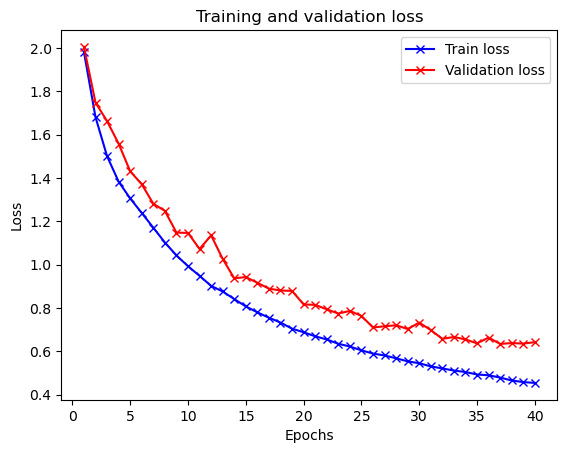

In [70]:
import matplotlib.pyplot as plt

# Define the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the train loss and val loss
plt.plot(epochs, train_loss, '-bx', label='Train loss')
plt.plot(epochs, validation_loss, '-rx', label='Validation loss')


# Set the title and labels for the graph
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()

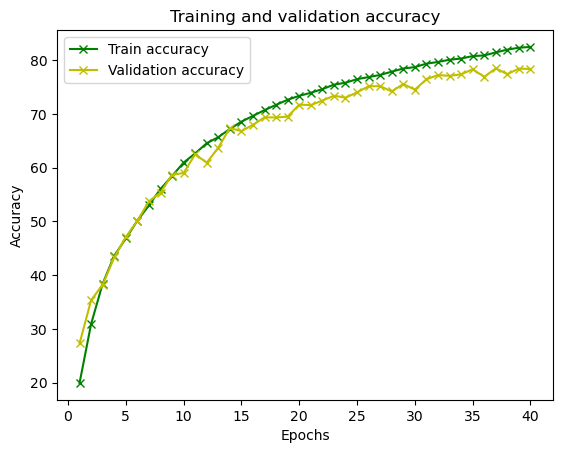

In [71]:
epochs = range(1, len(train_loss) + 1)
# Plot the train accuracy and val accuracy
plt.plot(epochs, train_accuracy, '-gx', label='Train accuracy')
plt.plot(epochs, validation_accuracy, '-yx', label='Validation accuracy')
# Set the title and labels for the graph
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()

In [72]:
# Evaluate the CNN on the test set
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = PandaNet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print the accuracy
print('Accuracy of the pre-trained CNN on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the pre-trained CNN on the 10000 test images: 78.34 %


# PandaNet2 using TanH activation and SGD with momentum

In [22]:
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F

# Define the CNN architecture
class PandaNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1) #(depth of each conv2d,noof conv2d)
        self.conv2 = nn.Conv2d(64,128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 4 * 4,128)
        self.fc2 = nn.Linear(128,256)
        self.fc3 = nn.Linear(256, 10)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.pool(self.tanh(self.conv1(x))) #32*32
        x = self.pool(self.tanh(self.conv2(x))) #16*16
        x = self.pool(self.tanh(self.conv3(x))) #4*4
        x = x.view(-1, 256 * 4 * 4)
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)

# Create an instance of the CNN
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PandaNet = PandaNet().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(PandaNet.parameters(), lr=0.001, momentum=0.9)
print(PandaNet)

PandaNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (tanh): Tanh()
)


In [23]:
from tqdm import tqdm
import time

start_time = time.time()

train_loss = []
train_accuracy = []
validation_loss = []
validation_accuracy = []

early_stopping = EarlyStopping(tolerance=5, min_delta=10)

for epoch in tqdm(range(40),desc="Loading..."):
    correct = 0
    total = 0
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = PandaNet(images)
        loss = criterion(outputs, labels)
        
        #checking Training Accuracy
        with torch.no_grad():
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    #testing val_acuuracy after each epoch
    total_val = 0
    correct_val = 0
    with torch.no_grad():
        for im_val,label_val in val_loader:
            im_val, label_val = im_val.to(device), label_val.to(device)
            output_val = PandaNet(im_val)
            val_loss = criterion(output_val, label_val)
            _, predicted_val = torch.max(output_val.data, 1)
            total_val += label_val.size(0)
            correct_val += (predicted_val == label_val).sum().item()

            
    print ('Epoch {} | Training Loss {:.2f} | Training Accuracy {:.2f}% | Validation Loss  {:.2f}| Validation Accuracy {}%'.format(epoch+1,running_loss/782,(100 * correct / total),(val_loss.item()),(100*correct_val/total_val)))
        
    train_loss.append(running_loss/782)
    train_accuracy.append(100 * correct / total)
    validation_loss.append(val_loss.item())
    validation_accuracy.append(100*correct_val/total_val)
    
    # early stopping
    early_stopping(running_loss/782, val_loss.item())
    if early_stopping.early_stop:
      print('early stop')
      break
        
torch.save(PandaNet.state_dict(), 'PandaNet3.pth')
    
end_time = time.time()
# Calculate the execution time
execution_time = end_time - start_time
# Print the execution time in seconds
print("Training time:", execution_time, "seconds")

Loading...:   2%|▎         | 1/40 [00:08<05:25,  8.34s/it]

Epoch 1 | Training Loss 1.85 | Training Accuracy 25.06% | Validation Loss  1.94| Validation Accuracy 30.04%


Loading...:   5%|▌         | 2/40 [00:16<05:10,  8.17s/it]

Epoch 2 | Training Loss 1.61 | Training Accuracy 35.30% | Validation Loss  1.68| Validation Accuracy 38.5%


Loading...:   8%|▊         | 3/40 [00:24<05:01,  8.14s/it]

Epoch 3 | Training Loss 1.42 | Training Accuracy 42.44% | Validation Loss  1.54| Validation Accuracy 43.86%


Loading...:  10%|█         | 4/40 [00:32<04:52,  8.11s/it]

Epoch 4 | Training Loss 1.31 | Training Accuracy 46.53% | Validation Loss  1.46| Validation Accuracy 46.62%


Loading...:  12%|█▎        | 5/40 [00:40<04:43,  8.09s/it]

Epoch 5 | Training Loss 1.25 | Training Accuracy 49.56% | Validation Loss  1.39| Validation Accuracy 49.64%


Loading...:  15%|█▌        | 6/40 [00:48<04:34,  8.08s/it]

Epoch 6 | Training Loss 1.19 | Training Accuracy 52.16% | Validation Loss  1.31| Validation Accuracy 52.98%


Loading...:  18%|█▊        | 7/40 [00:56<04:27,  8.09s/it]

Epoch 7 | Training Loss 1.13 | Training Accuracy 54.99% | Validation Loss  1.27| Validation Accuracy 54.6%


Loading...:  20%|██        | 8/40 [01:04<04:19,  8.11s/it]

Epoch 8 | Training Loss 1.07 | Training Accuracy 57.62% | Validation Loss  1.20| Validation Accuracy 57.22%


Loading...:  22%|██▎       | 9/40 [01:13<04:11,  8.10s/it]

Epoch 9 | Training Loss 1.02 | Training Accuracy 59.98% | Validation Loss  1.12| Validation Accuracy 59.72%


Loading...:  25%|██▌       | 10/40 [01:21<04:03,  8.13s/it]

Epoch 10 | Training Loss 0.97 | Training Accuracy 61.80% | Validation Loss  1.10| Validation Accuracy 60.88%


Loading...:  28%|██▊       | 11/40 [01:29<03:55,  8.11s/it]

Epoch 11 | Training Loss 0.93 | Training Accuracy 63.38% | Validation Loss  1.09| Validation Accuracy 61.56%


Loading...:  30%|███       | 12/40 [01:37<03:47,  8.14s/it]

Epoch 12 | Training Loss 0.90 | Training Accuracy 64.72% | Validation Loss  1.01| Validation Accuracy 64.22%


Loading...:  32%|███▎      | 13/40 [01:45<03:40,  8.17s/it]

Epoch 13 | Training Loss 0.87 | Training Accuracy 65.97% | Validation Loss  0.98| Validation Accuracy 64.96%


Loading...:  35%|███▌      | 14/40 [01:53<03:32,  8.17s/it]

Epoch 14 | Training Loss 0.84 | Training Accuracy 66.82% | Validation Loss  0.95| Validation Accuracy 66.6%


Loading...:  38%|███▊      | 15/40 [02:02<03:24,  8.19s/it]

Epoch 15 | Training Loss 0.82 | Training Accuracy 68.10% | Validation Loss  0.96| Validation Accuracy 65.8%


Loading...:  40%|████      | 16/40 [02:10<03:17,  8.22s/it]

Epoch 16 | Training Loss 0.80 | Training Accuracy 68.76% | Validation Loss  0.93| Validation Accuracy 66.9%


Loading...:  42%|████▎     | 17/40 [02:18<03:08,  8.18s/it]

Epoch 17 | Training Loss 0.78 | Training Accuracy 69.67% | Validation Loss  0.89| Validation Accuracy 68.36%


Loading...:  45%|████▌     | 18/40 [02:26<02:59,  8.17s/it]

Epoch 18 | Training Loss 0.76 | Training Accuracy 70.43% | Validation Loss  0.89| Validation Accuracy 68.48%


Loading...:  48%|████▊     | 19/40 [02:34<02:51,  8.15s/it]

Epoch 19 | Training Loss 0.74 | Training Accuracy 71.22% | Validation Loss  0.86| Validation Accuracy 70.0%


Loading...:  50%|█████     | 20/40 [02:42<02:43,  8.16s/it]

Epoch 20 | Training Loss 0.72 | Training Accuracy 72.00% | Validation Loss  0.86| Validation Accuracy 69.98%


Loading...:  52%|█████▎    | 21/40 [02:51<02:34,  8.15s/it]

Epoch 21 | Training Loss 0.71 | Training Accuracy 72.45% | Validation Loss  0.83| Validation Accuracy 70.42%


Loading...:  55%|█████▌    | 22/40 [02:59<02:26,  8.15s/it]

Epoch 22 | Training Loss 0.69 | Training Accuracy 72.99% | Validation Loss  0.83| Validation Accuracy 70.6%


Loading...:  57%|█████▊    | 23/40 [03:07<02:18,  8.15s/it]

Epoch 23 | Training Loss 0.68 | Training Accuracy 73.44% | Validation Loss  0.83| Validation Accuracy 71.0%


Loading...:  60%|██████    | 24/40 [03:15<02:10,  8.18s/it]

Epoch 24 | Training Loss 0.66 | Training Accuracy 74.06% | Validation Loss  0.80| Validation Accuracy 71.84%


Loading...:  62%|██████▎   | 25/40 [03:23<02:02,  8.17s/it]

Epoch 25 | Training Loss 0.65 | Training Accuracy 74.97% | Validation Loss  0.78| Validation Accuracy 72.9%


Loading...:  65%|██████▌   | 26/40 [03:31<01:54,  8.17s/it]

Epoch 26 | Training Loss 0.64 | Training Accuracy 75.14% | Validation Loss  0.77| Validation Accuracy 72.38%


Loading...:  68%|██████▊   | 27/40 [03:40<01:46,  8.18s/it]

Epoch 27 | Training Loss 0.63 | Training Accuracy 75.66% | Validation Loss  0.78| Validation Accuracy 73.0%


Loading...:  70%|███████   | 28/40 [03:48<01:37,  8.15s/it]

Epoch 28 | Training Loss 0.61 | Training Accuracy 76.35% | Validation Loss  0.75| Validation Accuracy 73.66%


Loading...:  72%|███████▎  | 29/40 [03:56<01:29,  8.16s/it]

Epoch 29 | Training Loss 0.61 | Training Accuracy 76.59% | Validation Loss  0.75| Validation Accuracy 73.94%


Loading...:  75%|███████▌  | 30/40 [04:04<01:21,  8.15s/it]

Epoch 30 | Training Loss 0.59 | Training Accuracy 76.78% | Validation Loss  0.73| Validation Accuracy 74.1%


Loading...:  78%|███████▊  | 31/40 [04:12<01:13,  8.15s/it]

Epoch 31 | Training Loss 0.59 | Training Accuracy 77.34% | Validation Loss  0.73| Validation Accuracy 74.06%


Loading...:  80%|████████  | 32/40 [04:21<01:05,  8.24s/it]

Epoch 32 | Training Loss 0.57 | Training Accuracy 77.69% | Validation Loss  0.71| Validation Accuracy 75.52%


Loading...:  82%|████████▎ | 33/40 [04:29<00:57,  8.25s/it]

Epoch 33 | Training Loss 0.56 | Training Accuracy 78.12% | Validation Loss  0.71| Validation Accuracy 74.84%


Loading...:  85%|████████▌ | 34/40 [04:37<00:49,  8.21s/it]

Epoch 34 | Training Loss 0.56 | Training Accuracy 78.45% | Validation Loss  0.69| Validation Accuracy 76.0%


Loading...:  88%|████████▊ | 35/40 [04:45<00:41,  8.25s/it]

Epoch 35 | Training Loss 0.55 | Training Accuracy 78.56% | Validation Loss  0.68| Validation Accuracy 76.18%


Loading...:  90%|█████████ | 36/40 [04:53<00:32,  8.19s/it]

Epoch 36 | Training Loss 0.54 | Training Accuracy 79.09% | Validation Loss  0.69| Validation Accuracy 75.76%


Loading...:  92%|█████████▎| 37/40 [05:02<00:24,  8.18s/it]

Epoch 37 | Training Loss 0.53 | Training Accuracy 79.19% | Validation Loss  0.71| Validation Accuracy 75.38%


Loading...:  95%|█████████▌| 38/40 [05:10<00:16,  8.18s/it]

Epoch 38 | Training Loss 0.52 | Training Accuracy 79.97% | Validation Loss  0.67| Validation Accuracy 76.4%


Loading...:  98%|█████████▊| 39/40 [05:18<00:08,  8.19s/it]

Epoch 39 | Training Loss 0.51 | Training Accuracy 80.10% | Validation Loss  0.67| Validation Accuracy 76.72%


Loading...: 100%|██████████| 40/40 [05:26<00:00,  8.16s/it]

Epoch 40 | Training Loss 0.51 | Training Accuracy 80.04% | Validation Loss  0.66| Validation Accuracy 76.88%
Training time: 326.46226048469543 seconds


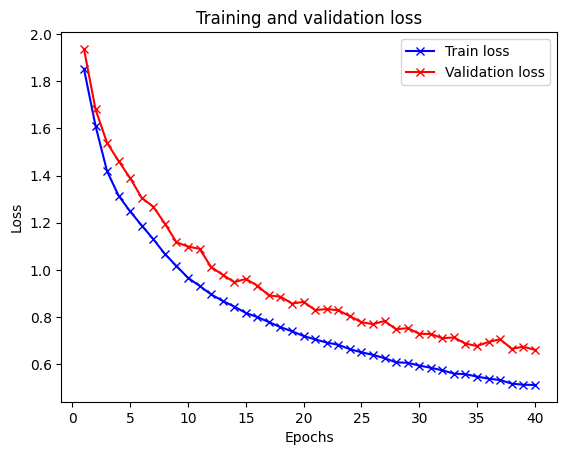

In [24]:
import matplotlib.pyplot as plt

# Define the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the train loss and val loss
plt.plot(epochs, train_loss, '-bx', label='Train loss')
plt.plot(epochs, validation_loss, '-rx', label='Validation loss')


# Set the title and labels for the graph
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()

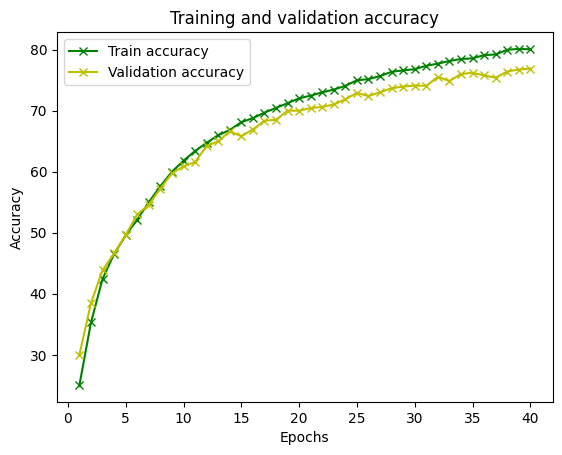

In [25]:
epochs = range(1, len(train_loss) + 1)
# Plot the train accuracy and val accuracy
plt.plot(epochs, train_accuracy, '-gx', label='Train accuracy')
plt.plot(epochs, validation_accuracy, '-yx', label='Validation accuracy')
# Set the title and labels for the graph
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()

In [26]:
# Evaluate the CNN on the test set
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = PandaNet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print the accuracy
print('Accuracy of the pre-trained CNN on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the pre-trained CNN on the 10000 test images: 77.51 %


# PandaNet2 using Sigmoid activation and SGD with momentum

In [27]:
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F

# Define the CNN architecture
class PandaNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1) #(depth of each conv2d,noof conv2d)
        self.conv2 = nn.Conv2d(64,128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 4 * 4,128)
        self.fc2 = nn.Linear(128,256)
        self.fc3 = nn.Linear(256, 10)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(self.sigmoid(self.conv1(x))) #32*32
        x = self.pool(self.sigmoid(self.conv2(x))) #16*16
        x = self.pool(self.sigmoid(self.conv3(x))) #4*4
        x = x.view(-1, 256 * 4 * 4)
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)

# Create an instance of the CNN
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PandaNet = PandaNet().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(PandaNet.parameters(), lr=0.001, momentum=0.9)
print(PandaNet)

PandaNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
)


In [28]:
from tqdm import tqdm
import time

start_time = time.time()

train_loss = []
train_accuracy = []
validation_loss = []
validation_accuracy = []

early_stopping = EarlyStopping(tolerance=5, min_delta=10)

for epoch in tqdm(range(40),desc="Loading..."):
    correct = 0
    total = 0
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = PandaNet(images)
        loss = criterion(outputs, labels)
        
        #checking Training Accuracy
        with torch.no_grad():
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    #testing val_acuuracy after each epoch
    total_val = 0
    correct_val = 0
    with torch.no_grad():
        for im_val,label_val in val_loader:
            im_val, label_val = im_val.to(device), label_val.to(device)
            output_val = PandaNet(im_val)
            val_loss = criterion(output_val, label_val)
            _, predicted_val = torch.max(output_val.data, 1)
            total_val += label_val.size(0)
            correct_val += (predicted_val == label_val).sum().item()

            
    print ('Epoch {} | Training Loss {:.2f} | Training Accuracy {:.2f}% | Validation Loss  {:.2f}| Validation Accuracy {}%'.format(epoch+1,running_loss/782,(100 * correct / total),(val_loss.item()),(100*correct_val/total_val)))
        
    train_loss.append(running_loss/782)
    train_accuracy.append(100 * correct / total)
    validation_loss.append(val_loss.item())
    validation_accuracy.append(100*correct_val/total_val)
    
    # early stopping
    early_stopping(running_loss/782, val_loss.item())
    if early_stopping.early_stop:
      print('early stop')
      break
        
torch.save(PandaNet.state_dict(), 'PandaNet3.pth')
    
end_time = time.time()
# Calculate the execution time
execution_time = end_time - start_time
# Print the execution time in seconds
print("Training time:", execution_time, "seconds")

Loading...:   2%|▎         | 1/40 [00:08<05:21,  8.24s/it]

Epoch 1 | Training Loss 2.08 | Training Accuracy 9.87% | Validation Loss  2.31| Validation Accuracy 9.96%


Loading...:   5%|▌         | 2/40 [00:16<05:12,  8.22s/it]

Epoch 2 | Training Loss 2.07 | Training Accuracy 9.87% | Validation Loss  2.31| Validation Accuracy 9.96%


Loading...:   8%|▊         | 3/40 [00:24<04:58,  8.06s/it]

Epoch 3 | Training Loss 2.08 | Training Accuracy 9.82% | Validation Loss  2.30| Validation Accuracy 9.96%


Loading...:  10%|█         | 4/40 [00:32<04:50,  8.08s/it]

Epoch 4 | Training Loss 2.08 | Training Accuracy 10.26% | Validation Loss  2.31| Validation Accuracy 9.78%


Loading...:  12%|█▎        | 5/40 [00:40<04:42,  8.08s/it]

Epoch 5 | Training Loss 2.08 | Training Accuracy 9.95% | Validation Loss  2.30| Validation Accuracy 9.44%


Loading...:  15%|█▌        | 6/40 [00:48<04:34,  8.06s/it]

Epoch 6 | Training Loss 2.08 | Training Accuracy 10.15% | Validation Loss  2.30| Validation Accuracy 10.4%


Loading...:  18%|█▊        | 7/40 [00:56<04:27,  8.10s/it]

Epoch 7 | Training Loss 2.08 | Training Accuracy 9.91% | Validation Loss  2.30| Validation Accuracy 9.78%


Loading...:  20%|██        | 8/40 [01:04<04:19,  8.10s/it]

Epoch 8 | Training Loss 2.07 | Training Accuracy 9.98% | Validation Loss  2.30| Validation Accuracy 10.2%


Loading...:  22%|██▎       | 9/40 [01:12<04:11,  8.10s/it]

Epoch 9 | Training Loss 2.07 | Training Accuracy 10.01% | Validation Loss  2.30| Validation Accuracy 9.88%


Loading...:  25%|██▌       | 10/40 [01:21<04:03,  8.12s/it]

Epoch 10 | Training Loss 2.08 | Training Accuracy 9.91% | Validation Loss  2.31| Validation Accuracy 10.4%


Loading...:  28%|██▊       | 11/40 [01:29<03:57,  8.18s/it]

Epoch 11 | Training Loss 2.07 | Training Accuracy 9.92% | Validation Loss  2.31| Validation Accuracy 9.78%


Loading...:  30%|███       | 12/40 [01:37<03:48,  8.17s/it]

Epoch 12 | Training Loss 2.07 | Training Accuracy 10.03% | Validation Loss  2.30| Validation Accuracy 10.68%


Loading...:  32%|███▎      | 13/40 [01:45<03:40,  8.15s/it]

Epoch 13 | Training Loss 2.07 | Training Accuracy 9.93% | Validation Loss  2.30| Validation Accuracy 9.6%


Loading...:  35%|███▌      | 14/40 [01:54<03:33,  8.22s/it]

Epoch 14 | Training Loss 2.08 | Training Accuracy 9.89% | Validation Loss  2.31| Validation Accuracy 10.1%


Loading...:  38%|███▊      | 15/40 [02:02<03:24,  8.18s/it]

Epoch 15 | Training Loss 2.08 | Training Accuracy 9.95% | Validation Loss  2.30| Validation Accuracy 10.2%


Loading...:  40%|████      | 16/40 [02:10<03:16,  8.20s/it]

Epoch 16 | Training Loss 2.07 | Training Accuracy 10.03% | Validation Loss  2.30| Validation Accuracy 9.78%


Loading...:  42%|████▎     | 17/40 [02:18<03:08,  8.18s/it]

Epoch 17 | Training Loss 2.07 | Training Accuracy 9.91% | Validation Loss  2.31| Validation Accuracy 10.1%


Loading...:  45%|████▌     | 18/40 [02:26<02:59,  8.15s/it]

Epoch 18 | Training Loss 2.08 | Training Accuracy 9.89% | Validation Loss  2.30| Validation Accuracy 10.2%


Loading...:  48%|████▊     | 19/40 [02:34<02:51,  8.18s/it]

Epoch 19 | Training Loss 2.08 | Training Accuracy 9.74% | Validation Loss  2.30| Validation Accuracy 10.68%


Loading...:  50%|█████     | 20/40 [02:42<02:43,  8.17s/it]

Epoch 20 | Training Loss 2.08 | Training Accuracy 9.82% | Validation Loss  2.31| Validation Accuracy 9.44%


Loading...:  52%|█████▎    | 21/40 [02:51<02:34,  8.15s/it]

Epoch 21 | Training Loss 2.07 | Training Accuracy 9.83% | Validation Loss  2.30| Validation Accuracy 10.1%


Loading...:  55%|█████▌    | 22/40 [02:59<02:26,  8.14s/it]

Epoch 22 | Training Loss 2.08 | Training Accuracy 9.79% | Validation Loss  2.30| Validation Accuracy 10.2%


Loading...:  57%|█████▊    | 23/40 [03:07<02:18,  8.15s/it]

Epoch 23 | Training Loss 2.08 | Training Accuracy 9.92% | Validation Loss  2.31| Validation Accuracy 10.68%


Loading...:  60%|██████    | 24/40 [03:15<02:10,  8.14s/it]

Epoch 24 | Training Loss 2.08 | Training Accuracy 10.22% | Validation Loss  2.30| Validation Accuracy 9.96%


Loading...:  62%|██████▎   | 25/40 [03:23<02:02,  8.17s/it]

Epoch 25 | Training Loss 2.07 | Training Accuracy 9.99% | Validation Loss  2.30| Validation Accuracy 9.96%


Loading...:  65%|██████▌   | 26/40 [03:31<01:54,  8.20s/it]

Epoch 26 | Training Loss 2.08 | Training Accuracy 9.82% | Validation Loss  2.30| Validation Accuracy 9.78%


Loading...:  68%|██████▊   | 27/40 [03:40<01:46,  8.19s/it]

Epoch 27 | Training Loss 2.08 | Training Accuracy 9.86% | Validation Loss  2.30| Validation Accuracy 9.44%


Loading...:  70%|███████   | 28/40 [03:48<01:38,  8.20s/it]

Epoch 28 | Training Loss 2.08 | Training Accuracy 9.91% | Validation Loss  2.31| Validation Accuracy 10.2%


Loading...:  72%|███████▎  | 29/40 [03:56<01:30,  8.19s/it]

Epoch 29 | Training Loss 2.07 | Training Accuracy 9.96% | Validation Loss  2.30| Validation Accuracy 9.78%


Loading...:  75%|███████▌  | 30/40 [04:04<01:21,  8.15s/it]

Epoch 30 | Training Loss 2.08 | Training Accuracy 9.86% | Validation Loss  2.30| Validation Accuracy 9.96%


Loading...:  78%|███████▊  | 31/40 [04:12<01:13,  8.17s/it]

Epoch 31 | Training Loss 2.08 | Training Accuracy 9.93% | Validation Loss  2.30| Validation Accuracy 10.4%


Loading...:  80%|████████  | 32/40 [04:20<01:05,  8.17s/it]

Epoch 32 | Training Loss 2.07 | Training Accuracy 9.87% | Validation Loss  2.31| Validation Accuracy 9.96%


Loading...:  82%|████████▎ | 33/40 [04:28<00:56,  8.11s/it]

Epoch 33 | Training Loss 2.08 | Training Accuracy 9.94% | Validation Loss  2.31| Validation Accuracy 10.2%


Loading...:  85%|████████▌ | 34/40 [04:37<00:48,  8.13s/it]

Epoch 34 | Training Loss 2.08 | Training Accuracy 9.81% | Validation Loss  2.31| Validation Accuracy 9.6%


Loading...:  88%|████████▊ | 35/40 [04:45<00:40,  8.06s/it]

Epoch 35 | Training Loss 2.07 | Training Accuracy 10.18% | Validation Loss  2.30| Validation Accuracy 10.4%


Loading...:  90%|█████████ | 36/40 [04:53<00:32,  8.07s/it]

Epoch 36 | Training Loss 2.07 | Training Accuracy 9.95% | Validation Loss  2.30| Validation Accuracy 9.96%


Loading...:  92%|█████████▎| 37/40 [05:01<00:24,  8.08s/it]

Epoch 37 | Training Loss 2.07 | Training Accuracy 9.95% | Validation Loss  2.30| Validation Accuracy 9.96%


Loading...:  95%|█████████▌| 38/40 [05:09<00:16,  8.09s/it]

Epoch 38 | Training Loss 2.08 | Training Accuracy 9.81% | Validation Loss  2.31| Validation Accuracy 10.1%


Loading...:  98%|█████████▊| 39/40 [05:17<00:08,  8.11s/it]

Epoch 39 | Training Loss 2.07 | Training Accuracy 10.06% | Validation Loss  2.30| Validation Accuracy 10.2%


Loading...: 100%|██████████| 40/40 [05:25<00:00,  8.14s/it]

Epoch 40 | Training Loss 2.07 | Training Accuracy 9.90% | Validation Loss  2.30| Validation Accuracy 10.2%
Training time: 325.72707629203796 seconds


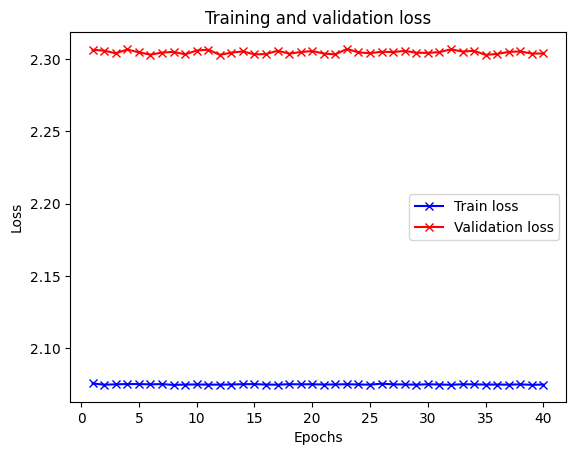

In [29]:
import matplotlib.pyplot as plt

# Define the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the train loss and val loss
plt.plot(epochs, train_loss, '-bx', label='Train loss')
plt.plot(epochs, validation_loss, '-rx', label='Validation loss')


# Set the title and labels for the graph
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()

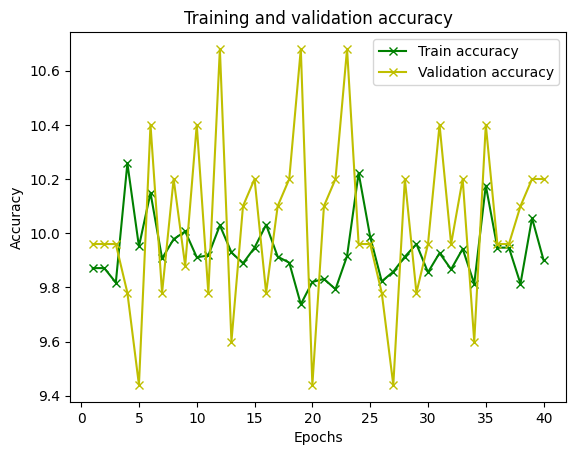

In [30]:
epochs = range(1, len(train_loss) + 1)
# Plot the train accuracy and val accuracy
plt.plot(epochs, train_accuracy, '-gx', label='Train accuracy')
plt.plot(epochs, validation_accuracy, '-yx', label='Validation accuracy')
# Set the title and labels for the graph
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()

In [31]:
# Evaluate the CNN on the test set
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = PandaNet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print the accuracy
print('Accuracy of the pre-trained CNN on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the pre-trained CNN on the 10000 test images: 10.0 %


# PandaNet2 with ReLU and Adam optimizer

In [33]:
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F

# Define the CNN architecture
class PandaNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1) #(depth of each conv2d,noof conv2d)
        self.conv2 = nn.Conv2d(64,128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 4 * 4,128)
        self.fc2 = nn.Linear(128,256)
        self.fc3 = nn.Linear(256, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x))) #32*32
        x = self.pool(self.relu(self.conv2(x))) #16*16
        x = self.pool(self.relu(self.conv3(x))) #4*4
        x = x.view(-1, 256 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)

# Create an instance of the CNN
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PandaNet = PandaNet().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(PandaNet.parameters(), lr=0.001)
print(PandaNet)

PandaNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)


In [34]:
from tqdm import tqdm
import time

start_time = time.time()

train_loss = []
train_accuracy = []
validation_loss = []
validation_accuracy = []

early_stopping = EarlyStopping(tolerance=5, min_delta=10)

for epoch in tqdm(range(40),desc="Loading..."):
    correct = 0
    total = 0
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = PandaNet(images)
        loss = criterion(outputs, labels)
        
        #checking Training Accuracy
        with torch.no_grad():
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    #testing val_acuuracy after each epoch
    total_val = 0
    correct_val = 0
    with torch.no_grad():
        for im_val,label_val in val_loader:
            im_val, label_val = im_val.to(device), label_val.to(device)
            output_val = PandaNet(im_val)
            val_loss = criterion(output_val, label_val)
            _, predicted_val = torch.max(output_val.data, 1)
            total_val += label_val.size(0)
            correct_val += (predicted_val == label_val).sum().item()

            
    print ('Epoch {} | Training Loss {:.2f} | Training Accuracy {:.2f}% | Validation Loss  {:.2f}| Validation Accuracy {}%'.format(epoch+1,running_loss/782,(100 * correct / total),(val_loss.item()),(100*correct_val/total_val)))
        
    train_loss.append(running_loss/782)
    train_accuracy.append(100 * correct / total)
    validation_loss.append(val_loss.item())
    validation_accuracy.append(100*correct_val/total_val)
    
    # early stopping
    early_stopping(running_loss/782, val_loss.item())
    if early_stopping.early_stop:
      print('early stop')
      break
        
torch.save(PandaNet.state_dict(), 'PandaNet3.pth')
    
end_time = time.time()
# Calculate the execution time
execution_time = end_time - start_time
# Print the execution time in seconds
print("Training time:", execution_time, "seconds")

Loading...:   2%|▎         | 1/40 [00:08<05:23,  8.30s/it]

Epoch 1 | Training Loss 1.41 | Training Accuracy 42.09% | Validation Loss  1.27| Validation Accuracy 53.86%


Loading...:   5%|▌         | 2/40 [00:16<05:10,  8.17s/it]

Epoch 2 | Training Loss 1.02 | Training Accuracy 59.40% | Validation Loss  1.06| Validation Accuracy 61.54%


Loading...:   8%|▊         | 3/40 [00:24<05:03,  8.20s/it]

Epoch 3 | Training Loss 0.85 | Training Accuracy 66.49% | Validation Loss  0.93| Validation Accuracy 67.74%


Loading...:  10%|█         | 4/40 [00:32<04:54,  8.18s/it]

Epoch 4 | Training Loss 0.76 | Training Accuracy 70.25% | Validation Loss  0.86| Validation Accuracy 69.82%


Loading...:  12%|█▎        | 5/40 [00:40<04:46,  8.19s/it]

Epoch 5 | Training Loss 0.69 | Training Accuracy 72.94% | Validation Loss  0.82| Validation Accuracy 71.34%


Loading...:  15%|█▌        | 6/40 [00:49<04:37,  8.15s/it]

Epoch 6 | Training Loss 0.65 | Training Accuracy 74.72% | Validation Loss  0.80| Validation Accuracy 72.4%


Loading...:  18%|█▊        | 7/40 [00:57<04:28,  8.14s/it]

Epoch 7 | Training Loss 0.62 | Training Accuracy 75.96% | Validation Loss  0.72| Validation Accuracy 75.3%


Loading...:  20%|██        | 8/40 [01:05<04:21,  8.16s/it]

Epoch 8 | Training Loss 0.58 | Training Accuracy 77.11% | Validation Loss  0.73| Validation Accuracy 75.2%


Loading...:  22%|██▎       | 9/40 [01:13<04:11,  8.12s/it]

Epoch 9 | Training Loss 0.56 | Training Accuracy 78.12% | Validation Loss  0.68| Validation Accuracy 77.14%


Loading...:  25%|██▌       | 10/40 [01:21<04:04,  8.14s/it]

Epoch 10 | Training Loss 0.55 | Training Accuracy 78.87% | Validation Loss  0.69| Validation Accuracy 76.12%


Loading...:  28%|██▊       | 11/40 [01:29<03:56,  8.16s/it]

Epoch 11 | Training Loss 0.52 | Training Accuracy 79.89% | Validation Loss  0.71| Validation Accuracy 76.06%


Loading...:  30%|███       | 12/40 [01:37<03:47,  8.13s/it]

Epoch 12 | Training Loss 0.51 | Training Accuracy 80.27% | Validation Loss  0.66| Validation Accuracy 77.26%


Loading...:  32%|███▎      | 13/40 [01:45<03:38,  8.10s/it]

Epoch 13 | Training Loss 0.49 | Training Accuracy 81.13% | Validation Loss  0.62| Validation Accuracy 78.72%


Loading...:  35%|███▌      | 14/40 [01:53<03:30,  8.10s/it]

Epoch 14 | Training Loss 0.48 | Training Accuracy 81.44% | Validation Loss  0.68| Validation Accuracy 77.42%


Loading...:  38%|███▊      | 15/40 [02:02<03:22,  8.10s/it]

Epoch 15 | Training Loss 0.47 | Training Accuracy 81.81% | Validation Loss  0.65| Validation Accuracy 78.14%


Loading...:  40%|████      | 16/40 [02:10<03:14,  8.11s/it]

Epoch 16 | Training Loss 0.45 | Training Accuracy 82.53% | Validation Loss  0.65| Validation Accuracy 78.22%


Loading...:  42%|████▎     | 17/40 [02:18<03:06,  8.11s/it]

Epoch 17 | Training Loss 0.45 | Training Accuracy 82.68% | Validation Loss  0.65| Validation Accuracy 78.62%


Loading...:  45%|████▌     | 18/40 [02:26<02:58,  8.10s/it]

Epoch 18 | Training Loss 0.44 | Training Accuracy 82.76% | Validation Loss  0.65| Validation Accuracy 77.9%


Loading...:  48%|████▊     | 19/40 [02:34<02:50,  8.11s/it]

Epoch 19 | Training Loss 0.43 | Training Accuracy 83.52% | Validation Loss  0.62| Validation Accuracy 79.42%


Loading...:  50%|█████     | 20/40 [02:42<02:42,  8.13s/it]

Epoch 20 | Training Loss 0.42 | Training Accuracy 84.04% | Validation Loss  0.61| Validation Accuracy 79.42%


Loading...:  52%|█████▎    | 21/40 [02:50<02:33,  8.10s/it]

Epoch 21 | Training Loss 0.41 | Training Accuracy 84.08% | Validation Loss  0.57| Validation Accuracy 80.6%


Loading...:  55%|█████▌    | 22/40 [02:58<02:25,  8.09s/it]

Epoch 22 | Training Loss 0.40 | Training Accuracy 84.67% | Validation Loss  0.65| Validation Accuracy 78.34%


Loading...:  57%|█████▊    | 23/40 [03:06<02:17,  8.10s/it]

Epoch 23 | Training Loss 0.40 | Training Accuracy 84.63% | Validation Loss  0.59| Validation Accuracy 80.6%


Loading...:  60%|██████    | 24/40 [03:15<02:09,  8.10s/it]

Epoch 24 | Training Loss 0.39 | Training Accuracy 84.85% | Validation Loss  0.61| Validation Accuracy 79.78%


Loading...:  62%|██████▎   | 25/40 [03:23<02:01,  8.11s/it]

Epoch 25 | Training Loss 0.39 | Training Accuracy 85.12% | Validation Loss  0.61| Validation Accuracy 79.54%


Loading...:  65%|██████▌   | 26/40 [03:31<01:53,  8.13s/it]

Epoch 26 | Training Loss 0.38 | Training Accuracy 85.27% | Validation Loss  0.57| Validation Accuracy 80.8%


Loading...:  68%|██████▊   | 27/40 [03:39<01:45,  8.15s/it]

Epoch 27 | Training Loss 0.37 | Training Accuracy 85.46% | Validation Loss  0.62| Validation Accuracy 79.72%


Loading...:  70%|███████   | 28/40 [03:47<01:38,  8.18s/it]

Epoch 28 | Training Loss 0.36 | Training Accuracy 85.75% | Validation Loss  0.62| Validation Accuracy 79.82%


Loading...:  72%|███████▎  | 29/40 [03:55<01:29,  8.17s/it]

Epoch 29 | Training Loss 0.37 | Training Accuracy 85.96% | Validation Loss  0.60| Validation Accuracy 80.48%


Loading...:  75%|███████▌  | 30/40 [04:04<01:21,  8.15s/it]

Epoch 30 | Training Loss 0.36 | Training Accuracy 85.88% | Validation Loss  0.58| Validation Accuracy 81.16%


Loading...:  78%|███████▊  | 31/40 [04:12<01:13,  8.11s/it]

Epoch 31 | Training Loss 0.36 | Training Accuracy 86.16% | Validation Loss  0.58| Validation Accuracy 81.88%


Loading...:  80%|████████  | 32/40 [04:20<01:04,  8.11s/it]

Epoch 32 | Training Loss 0.35 | Training Accuracy 86.49% | Validation Loss  0.55| Validation Accuracy 82.2%


Loading...:  82%|████████▎ | 33/40 [04:28<00:56,  8.13s/it]

Epoch 33 | Training Loss 0.35 | Training Accuracy 86.55% | Validation Loss  0.58| Validation Accuracy 80.86%


Loading...:  85%|████████▌ | 34/40 [04:36<00:48,  8.13s/it]

Epoch 34 | Training Loss 0.34 | Training Accuracy 86.79% | Validation Loss  0.61| Validation Accuracy 81.04%


Loading...:  88%|████████▊ | 35/40 [04:44<00:40,  8.16s/it]

Epoch 35 | Training Loss 0.33 | Training Accuracy 87.08% | Validation Loss  0.61| Validation Accuracy 81.36%


Loading...:  90%|█████████ | 36/40 [04:52<00:32,  8.14s/it]

Epoch 36 | Training Loss 0.33 | Training Accuracy 87.00% | Validation Loss  0.60| Validation Accuracy 81.1%


Loading...:  92%|█████████▎| 37/40 [05:00<00:24,  8.13s/it]

Epoch 37 | Training Loss 0.33 | Training Accuracy 87.20% | Validation Loss  0.59| Validation Accuracy 81.68%


Loading...:  95%|█████████▌| 38/40 [05:09<00:16,  8.14s/it]

Epoch 38 | Training Loss 0.33 | Training Accuracy 87.22% | Validation Loss  0.58| Validation Accuracy 81.14%


Loading...:  98%|█████████▊| 39/40 [05:17<00:08,  8.12s/it]

Epoch 39 | Training Loss 0.32 | Training Accuracy 87.50% | Validation Loss  0.58| Validation Accuracy 82.54%


Loading...: 100%|██████████| 40/40 [05:25<00:00,  8.13s/it]

Epoch 40 | Training Loss 0.32 | Training Accuracy 87.70% | Validation Loss  0.56| Validation Accuracy 82.12%
Training time: 325.2966012954712 seconds


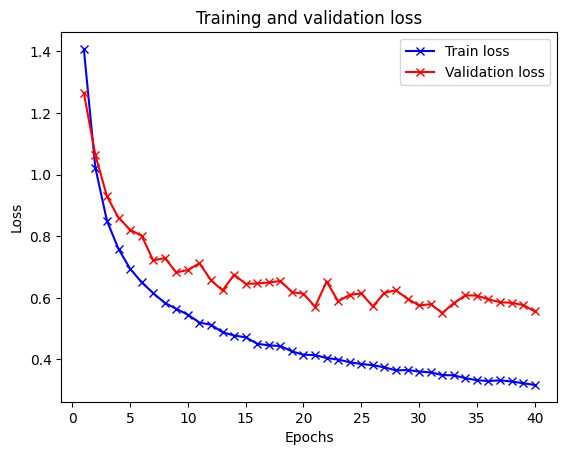

In [35]:
import matplotlib.pyplot as plt

# Define the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the train loss and val loss
plt.plot(epochs, train_loss, '-bx', label='Train loss')
plt.plot(epochs, validation_loss, '-rx', label='Validation loss')


# Set the title and labels for the graph
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()

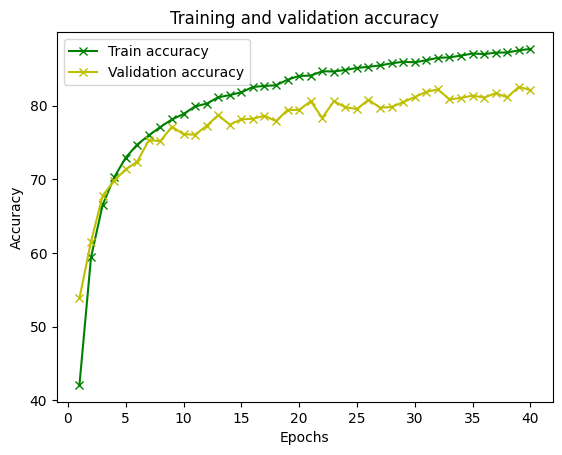

In [36]:
epochs = range(1, len(train_loss) + 1)
# Plot the train accuracy and val accuracy
plt.plot(epochs, train_accuracy, '-gx', label='Train accuracy')
plt.plot(epochs, validation_accuracy, '-yx', label='Validation accuracy')
# Set the title and labels for the graph
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()

In [37]:
# Evaluate the CNN on the test set
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = PandaNet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print the accuracy
print('Accuracy of the pre-trained CNN on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the pre-trained CNN on the 10000 test images: 82.6 %


# PandaNet2 using TanH and AdaDelta

In [38]:
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F

# Define the CNN architecture
class PandaNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1) #(depth of each conv2d,noof conv2d)
        self.conv2 = nn.Conv2d(64,128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 4 * 4,128)
        self.fc2 = nn.Linear(128,256)
        self.fc3 = nn.Linear(256, 10)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.pool(self.tanh(self.conv1(x))) #32*32
        x = self.pool(self.tanh(self.conv2(x))) #16*16
        x = self.pool(self.tanh(self.conv3(x))) #4*4
        x = x.view(-1, 256 * 4 * 4)
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)

# Create an instance of the CNN
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PandaNet = PandaNet().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adadelta(PandaNet.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)
print(PandaNet)

PandaNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (tanh): Tanh()
)


In [39]:
from tqdm import tqdm
import time

start_time = time.time()

train_loss = []
train_accuracy = []
validation_loss = []
validation_accuracy = []

early_stopping = EarlyStopping(tolerance=5, min_delta=10)

for epoch in tqdm(range(40),desc="Loading..."):
    correct = 0
    total = 0
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = PandaNet(images)
        loss = criterion(outputs, labels)
        
        #checking Training Accuracy
        with torch.no_grad():
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    #testing val_acuuracy after each epoch
    total_val = 0
    correct_val = 0
    with torch.no_grad():
        for im_val,label_val in val_loader:
            im_val, label_val = im_val.to(device), label_val.to(device)
            output_val = PandaNet(im_val)
            val_loss = criterion(output_val, label_val)
            _, predicted_val = torch.max(output_val.data, 1)
            total_val += label_val.size(0)
            correct_val += (predicted_val == label_val).sum().item()

            
    print ('Epoch {} | Training Loss {:.2f} | Training Accuracy {:.2f}% | Validation Loss  {:.2f}| Validation Accuracy {}%'.format(epoch+1,running_loss/782,(100 * correct / total),(val_loss.item()),(100*correct_val/total_val)))
        
    train_loss.append(running_loss/782)
    train_accuracy.append(100 * correct / total)
    validation_loss.append(val_loss.item())
    validation_accuracy.append(100*correct_val/total_val)
    
    # early stopping
    early_stopping(running_loss/782, val_loss.item())
    if early_stopping.early_stop:
      print('early stop')
      break
        
torch.save(PandaNet.state_dict(), 'PandaNet3.pth')
    
end_time = time.time()
# Calculate the execution time
execution_time = end_time - start_time
# Print the execution time in seconds
print("Training time:", execution_time, "seconds")

Loading...:   2%|▎         | 1/40 [00:08<05:14,  8.07s/it]

Epoch 1 | Training Loss 1.46 | Training Accuracy 40.82% | Validation Loss  1.58| Validation Accuracy 44.38%


Loading...:   5%|▌         | 2/40 [00:16<05:07,  8.09s/it]

Epoch 2 | Training Loss 1.16 | Training Accuracy 53.84% | Validation Loss  1.50| Validation Accuracy 47.22%


Loading...:   8%|▊         | 3/40 [00:24<04:55,  7.99s/it]

Epoch 3 | Training Loss 1.09 | Training Accuracy 57.30% | Validation Loss  1.46| Validation Accuracy 48.62%


Loading...:  10%|█         | 4/40 [00:32<04:50,  8.07s/it]

Epoch 4 | Training Loss 1.03 | Training Accuracy 59.43% | Validation Loss  1.38| Validation Accuracy 52.02%


Loading...:  12%|█▎        | 5/40 [00:40<04:43,  8.10s/it]

Epoch 5 | Training Loss 1.00 | Training Accuracy 60.58% | Validation Loss  1.17| Validation Accuracy 58.56%


Loading...:  15%|█▌        | 6/40 [00:48<04:33,  8.04s/it]

Epoch 6 | Training Loss 0.98 | Training Accuracy 61.59% | Validation Loss  1.24| Validation Accuracy 56.0%


Loading...:  18%|█▊        | 7/40 [00:56<04:26,  8.07s/it]

Epoch 7 | Training Loss 0.95 | Training Accuracy 62.64% | Validation Loss  1.25| Validation Accuracy 56.72%


Loading...:  20%|██        | 8/40 [01:04<04:19,  8.10s/it]

Epoch 8 | Training Loss 0.94 | Training Accuracy 63.31% | Validation Loss  1.18| Validation Accuracy 57.96%


Loading...:  22%|██▎       | 9/40 [01:12<04:10,  8.07s/it]

Epoch 9 | Training Loss 0.92 | Training Accuracy 63.61% | Validation Loss  1.08| Validation Accuracy 62.28%


Loading...:  25%|██▌       | 10/40 [01:20<04:01,  8.05s/it]

Epoch 10 | Training Loss 0.91 | Training Accuracy 63.99% | Validation Loss  1.17| Validation Accuracy 59.88%


Loading...:  28%|██▊       | 11/40 [01:28<03:53,  8.05s/it]

Epoch 11 | Training Loss 0.91 | Training Accuracy 64.73% | Validation Loss  1.18| Validation Accuracy 58.54%


Loading...:  30%|███       | 12/40 [01:36<03:45,  8.06s/it]

Epoch 12 | Training Loss 0.90 | Training Accuracy 64.72% | Validation Loss  1.07| Validation Accuracy 62.42%


Loading...:  32%|███▎      | 13/40 [01:44<03:38,  8.11s/it]

Epoch 13 | Training Loss 0.90 | Training Accuracy 65.32% | Validation Loss  1.18| Validation Accuracy 59.74%


Loading...:  35%|███▌      | 14/40 [01:53<03:31,  8.12s/it]

Epoch 14 | Training Loss 0.89 | Training Accuracy 65.11% | Validation Loss  1.22| Validation Accuracy 57.82%


Loading...:  38%|███▊      | 15/40 [02:01<03:22,  8.11s/it]

Epoch 15 | Training Loss 0.88 | Training Accuracy 65.39% | Validation Loss  1.08| Validation Accuracy 62.74%


Loading...:  40%|████      | 16/40 [02:09<03:14,  8.10s/it]

Epoch 16 | Training Loss 0.88 | Training Accuracy 65.59% | Validation Loss  1.10| Validation Accuracy 61.5%


Loading...:  42%|████▎     | 17/40 [02:17<03:06,  8.10s/it]

Epoch 17 | Training Loss 0.88 | Training Accuracy 65.49% | Validation Loss  1.12| Validation Accuracy 61.22%


Loading...:  45%|████▌     | 18/40 [02:25<02:59,  8.14s/it]

Epoch 18 | Training Loss 0.87 | Training Accuracy 65.85% | Validation Loss  1.02| Validation Accuracy 64.32%


Loading...:  48%|████▊     | 19/40 [02:33<02:50,  8.12s/it]

Epoch 19 | Training Loss 0.87 | Training Accuracy 66.14% | Validation Loss  1.15| Validation Accuracy 59.52%


Loading...:  50%|█████     | 20/40 [02:41<02:42,  8.11s/it]

Epoch 20 | Training Loss 0.86 | Training Accuracy 66.59% | Validation Loss  1.01| Validation Accuracy 64.24%


Loading...:  52%|█████▎    | 21/40 [02:49<02:33,  8.06s/it]

Epoch 21 | Training Loss 0.86 | Training Accuracy 66.07% | Validation Loss  1.16| Validation Accuracy 60.06%


Loading...:  55%|█████▌    | 22/40 [02:57<02:25,  8.10s/it]

Epoch 22 | Training Loss 0.86 | Training Accuracy 66.21% | Validation Loss  1.03| Validation Accuracy 63.58%


Loading...:  57%|█████▊    | 23/40 [03:06<02:18,  8.12s/it]

Epoch 23 | Training Loss 0.86 | Training Accuracy 66.56% | Validation Loss  1.03| Validation Accuracy 64.16%


Loading...:  60%|██████    | 24/40 [03:14<02:10,  8.16s/it]

Epoch 24 | Training Loss 0.85 | Training Accuracy 66.63% | Validation Loss  1.03| Validation Accuracy 64.06%


Loading...:  62%|██████▎   | 25/40 [03:22<02:01,  8.12s/it]

Epoch 25 | Training Loss 0.86 | Training Accuracy 66.45% | Validation Loss  1.07| Validation Accuracy 62.86%


Loading...:  65%|██████▌   | 26/40 [03:30<01:53,  8.11s/it]

Epoch 26 | Training Loss 0.85 | Training Accuracy 66.59% | Validation Loss  1.11| Validation Accuracy 61.36%


Loading...:  68%|██████▊   | 27/40 [03:38<01:45,  8.10s/it]

Epoch 27 | Training Loss 0.85 | Training Accuracy 66.76% | Validation Loss  1.05| Validation Accuracy 63.86%


Loading...:  70%|███████   | 28/40 [03:46<01:37,  8.09s/it]

Epoch 28 | Training Loss 0.85 | Training Accuracy 66.92% | Validation Loss  1.04| Validation Accuracy 63.6%


Loading...:  72%|███████▎  | 29/40 [03:54<01:29,  8.11s/it]

Epoch 29 | Training Loss 0.85 | Training Accuracy 66.92% | Validation Loss  1.08| Validation Accuracy 62.12%


Loading...:  75%|███████▌  | 30/40 [04:02<01:21,  8.13s/it]

Epoch 30 | Training Loss 0.85 | Training Accuracy 66.44% | Validation Loss  1.09| Validation Accuracy 62.9%


Loading...:  78%|███████▊  | 31/40 [04:11<01:13,  8.14s/it]

Epoch 31 | Training Loss 0.85 | Training Accuracy 66.68% | Validation Loss  1.15| Validation Accuracy 60.14%


Loading...:  80%|████████  | 32/40 [04:19<01:04,  8.12s/it]

Epoch 32 | Training Loss 0.85 | Training Accuracy 66.89% | Validation Loss  1.06| Validation Accuracy 62.2%


Loading...:  82%|████████▎ | 33/40 [04:27<00:56,  8.11s/it]

Epoch 33 | Training Loss 0.84 | Training Accuracy 67.10% | Validation Loss  1.06| Validation Accuracy 63.8%


Loading...:  85%|████████▌ | 34/40 [04:35<00:48,  8.09s/it]

Epoch 34 | Training Loss 0.85 | Training Accuracy 66.49% | Validation Loss  1.12| Validation Accuracy 60.64%


Loading...:  88%|████████▊ | 35/40 [04:43<00:40,  8.09s/it]

Epoch 35 | Training Loss 0.85 | Training Accuracy 66.59% | Validation Loss  1.19| Validation Accuracy 59.62%


Loading...:  90%|█████████ | 36/40 [04:51<00:32,  8.07s/it]

Epoch 36 | Training Loss 0.84 | Training Accuracy 67.10% | Validation Loss  1.09| Validation Accuracy 61.18%


Loading...:  92%|█████████▎| 37/40 [04:59<00:24,  8.14s/it]

Epoch 37 | Training Loss 0.84 | Training Accuracy 67.00% | Validation Loss  1.04| Validation Accuracy 63.66%


Loading...:  95%|█████████▌| 38/40 [05:07<00:16,  8.11s/it]

Epoch 38 | Training Loss 0.84 | Training Accuracy 67.07% | Validation Loss  1.02| Validation Accuracy 64.08%


Loading...:  98%|█████████▊| 39/40 [05:15<00:08,  8.08s/it]

Epoch 39 | Training Loss 0.85 | Training Accuracy 67.32% | Validation Loss  1.08| Validation Accuracy 63.08%


Loading...: 100%|██████████| 40/40 [05:24<00:00,  8.10s/it]

Epoch 40 | Training Loss 0.84 | Training Accuracy 67.06% | Validation Loss  1.02| Validation Accuracy 65.04%
Training time: 324.0200457572937 seconds


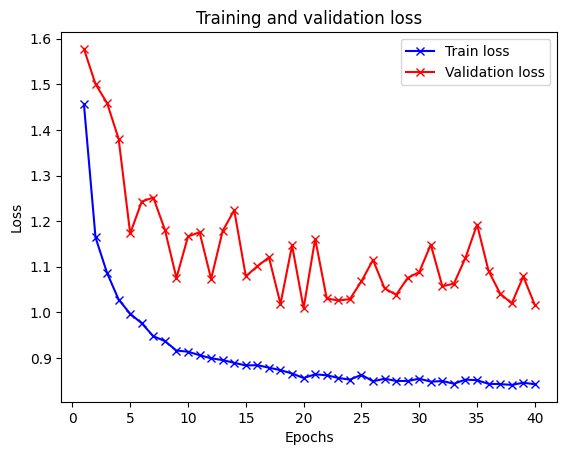

In [40]:
import matplotlib.pyplot as plt

# Define the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the train loss and val loss
plt.plot(epochs, train_loss, '-bx', label='Train loss')
plt.plot(epochs, validation_loss, '-rx', label='Validation loss')


# Set the title and labels for the graph
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()

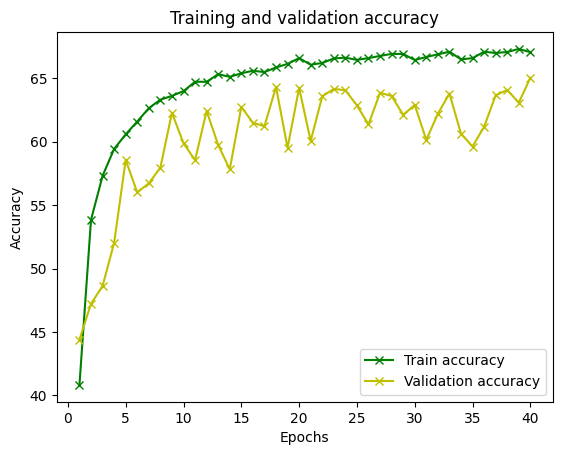

In [41]:
epochs = range(1, len(train_loss) + 1)
# Plot the train accuracy and val accuracy
plt.plot(epochs, train_accuracy, '-gx', label='Train accuracy')
plt.plot(epochs, validation_accuracy, '-yx', label='Validation accuracy')
# Set the title and labels for the graph
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()

In [42]:
# Evaluate the CNN on the test set
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = PandaNet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print the accuracy
print('Accuracy of the pre-trained CNN on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the pre-trained CNN on the 10000 test images: 65.51 %


# PandaNet3 using ReLU and SGD with momentum

In [77]:
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F

# Define the CNN architecture
class PandaNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1) #(depth of each conv2d,noof conv2d)
        self.conv2 = nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(128,256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.batch_norm1 = nn.BatchNorm2d(num_features=64)
        self.batch_norm2 = nn.BatchNorm2d(num_features=128)
        self.batch_norm3 = nn.BatchNorm2d(num_features=256)
        
        self.fc1 = nn.Linear(256 * 4 * 4,1024)
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x)) 
        x = self.pool(self.relu(self.conv2(x)))
        x = self.batch_norm1(x)
        x = self.relu(self.conv3(x))
        x = self.pool(self.relu(self.conv4(x)))
        x = self.batch_norm2(x)
        x = self.relu(self.conv5(x))
        x = self.pool(self.relu(self.conv6(x)))
        x = self.batch_norm3(x)
        
        x = x.view(-1, 256 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)

# Create an instance of the CNN
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PandaNet = PandaNet().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(PandaNet.parameters(), lr=0.001, momentum=0.9)
summary(PandaNet)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            18,496
├─Conv2d: 1-3                            73,856
├─Conv2d: 1-4                            147,584
├─Conv2d: 1-5                            295,168
├─Conv2d: 1-6                            590,080
├─MaxPool2d: 1-7                         --
├─BatchNorm2d: 1-8                       128
├─BatchNorm2d: 1-9                       256
├─BatchNorm2d: 1-10                      512
├─Linear: 1-11                           4,195,328
├─Linear: 1-12                           524,800
├─Linear: 1-13                           5,130
├─ReLU: 1-14                             --
Total params: 5,852,234
Trainable params: 5,852,234
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            18,496
├─Conv2d: 1-3                            73,856
├─Conv2d: 1-4                            147,584
├─Conv2d: 1-5                            295,168
├─Conv2d: 1-6                            590,080
├─MaxPool2d: 1-7                         --
├─BatchNorm2d: 1-8                       128
├─BatchNorm2d: 1-9                       256
├─BatchNorm2d: 1-10                      512
├─Linear: 1-11                           4,195,328
├─Linear: 1-12                           524,800
├─Linear: 1-13                           5,130
├─ReLU: 1-14                             --
Total params: 5,852,234
Trainable params: 5,852,234
Non-trainable params: 0

In [78]:
from tqdm import tqdm
import time

start_time = time.time()

train_loss = []
train_accuracy = []
validation_loss = []
validation_accuracy = []

early_stopping = EarlyStopping(tolerance=5, min_delta=10)

for epoch in tqdm(range(50),desc="Loading..."):
    correct = 0
    total = 0
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = PandaNet(images)
        loss = criterion(outputs, labels)
        
        #checking Training Accuracy
        with torch.no_grad():
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    #testing val_acuuracy after each epoch
    total_val = 0
    correct_val = 0
    with torch.no_grad():
        for im_val,label_val in val_loader:
            im_val, label_val = im_val.to(device), label_val.to(device)
            output_val = PandaNet(im_val)
            val_loss = criterion(output_val, label_val)
            _, predicted_val = torch.max(output_val.data, 1)
            total_val += label_val.size(0)
            correct_val += (predicted_val == label_val).sum().item()

            
    print ('Epoch {} | Training Loss {:.2f} | Training Accuracy {:.2f}% | Validation Loss  {:.2f}| Validation Accuracy {}%'.format(epoch+1,running_loss/782,(100 * correct / total),(val_loss.item()),(100*correct_val/total_val)))
        
    train_loss.append(running_loss/782)
    train_accuracy.append(100 * correct / total)
    validation_loss.append(val_loss.item())
    validation_accuracy.append(100*correct_val/total_val)
    
    # early stopping
    early_stopping(running_loss/782, val_loss.item())
    if early_stopping.early_stop:
      print('early stop')
      break
        
torch.save(PandaNet.state_dict(), 'PandaNet3.pth')
    
end_time = time.time()
# Calculate the execution time
execution_time = end_time - start_time
# Print the execution time in seconds
print("Training time:", execution_time, "seconds")

Loading...:   2%|▏         | 1/50 [00:30<25:17, 30.96s/it]

Epoch 1 | Training Loss 2.07 | Training Accuracy 10.02% | Validation Loss  2.30| Validation Accuracy 9.78%


Loading...:   4%|▍         | 2/50 [01:01<24:44, 30.93s/it]

Epoch 2 | Training Loss 2.07 | Training Accuracy 12.01% | Validation Loss  2.30| Validation Accuracy 10.8%


Loading...:   6%|▌         | 3/50 [01:32<24:12, 30.91s/it]

Epoch 3 | Training Loss 2.07 | Training Accuracy 12.55% | Validation Loss  2.30| Validation Accuracy 16.18%


Loading...:   8%|▊         | 4/50 [02:03<23:35, 30.76s/it]

Epoch 4 | Training Loss 2.01 | Training Accuracy 17.25% | Validation Loss  2.13| Validation Accuracy 23.12%


Loading...:  10%|█         | 5/50 [02:33<22:57, 30.62s/it]

Epoch 5 | Training Loss 1.82 | Training Accuracy 25.89% | Validation Loss  1.98| Validation Accuracy 28.14%


Loading...:  12%|█▏        | 6/50 [03:04<22:24, 30.55s/it]

Epoch 6 | Training Loss 1.72 | Training Accuracy 30.27% | Validation Loss  1.86| Validation Accuracy 29.76%


Loading...:  14%|█▍        | 7/50 [03:34<21:58, 30.67s/it]

Epoch 7 | Training Loss 1.62 | Training Accuracy 33.99% | Validation Loss  1.74| Validation Accuracy 36.22%


Loading...:  16%|█▌        | 8/50 [04:05<21:30, 30.72s/it]

Epoch 8 | Training Loss 1.54 | Training Accuracy 37.12% | Validation Loss  1.70| Validation Accuracy 38.38%


Loading...:  18%|█▊        | 9/50 [04:36<20:56, 30.66s/it]

Epoch 9 | Training Loss 1.49 | Training Accuracy 39.90% | Validation Loss  1.65| Validation Accuracy 39.78%


Loading...:  20%|██        | 10/50 [05:07<20:32, 30.81s/it]

Epoch 10 | Training Loss 1.44 | Training Accuracy 41.98% | Validation Loss  1.60| Validation Accuracy 41.94%


Loading...:  22%|██▏       | 11/50 [05:38<20:01, 30.82s/it]

Epoch 11 | Training Loss 1.39 | Training Accuracy 43.73% | Validation Loss  1.59| Validation Accuracy 41.8%


Loading...:  24%|██▍       | 12/50 [06:09<19:33, 30.87s/it]

Epoch 12 | Training Loss 1.35 | Training Accuracy 45.83% | Validation Loss  1.51| Validation Accuracy 45.72%


Loading...:  26%|██▌       | 13/50 [06:40<19:00, 30.84s/it]

Epoch 13 | Training Loss 1.30 | Training Accuracy 47.65% | Validation Loss  1.46| Validation Accuracy 46.78%


Loading...:  28%|██▊       | 14/50 [07:10<18:29, 30.82s/it]

Epoch 14 | Training Loss 1.26 | Training Accuracy 49.36% | Validation Loss  1.42| Validation Accuracy 49.2%


Loading...:  30%|███       | 15/50 [07:41<17:58, 30.81s/it]

Epoch 15 | Training Loss 1.22 | Training Accuracy 51.22% | Validation Loss  1.36| Validation Accuracy 50.62%


Loading...:  32%|███▏      | 16/50 [08:12<17:28, 30.84s/it]

Epoch 16 | Training Loss 1.18 | Training Accuracy 52.75% | Validation Loss  1.32| Validation Accuracy 52.22%


Loading...:  34%|███▍      | 17/50 [08:43<17:00, 30.92s/it]

Epoch 17 | Training Loss 1.14 | Training Accuracy 54.56% | Validation Loss  1.31| Validation Accuracy 52.82%


Loading...:  36%|███▌      | 18/50 [09:14<16:28, 30.88s/it]

Epoch 18 | Training Loss 1.11 | Training Accuracy 55.92% | Validation Loss  1.28| Validation Accuracy 54.6%


Loading...:  38%|███▊      | 19/50 [09:45<15:55, 30.82s/it]

Epoch 19 | Training Loss 1.07 | Training Accuracy 57.48% | Validation Loss  1.20| Validation Accuracy 56.98%


Loading...:  40%|████      | 20/50 [10:15<15:22, 30.74s/it]

Epoch 20 | Training Loss 1.04 | Training Accuracy 58.82% | Validation Loss  1.19| Validation Accuracy 57.1%


Loading...:  42%|████▏     | 21/50 [10:46<14:52, 30.79s/it]

Epoch 21 | Training Loss 0.99 | Training Accuracy 60.89% | Validation Loss  1.12| Validation Accuracy 59.84%


Loading...:  44%|████▍     | 22/50 [11:17<14:23, 30.85s/it]

Epoch 22 | Training Loss 0.95 | Training Accuracy 62.32% | Validation Loss  1.09| Validation Accuracy 59.86%


Loading...:  46%|████▌     | 23/50 [11:48<13:52, 30.84s/it]

Epoch 23 | Training Loss 0.92 | Training Accuracy 63.82% | Validation Loss  1.03| Validation Accuracy 63.12%


Loading...:  48%|████▊     | 24/50 [12:18<13:17, 30.67s/it]

Epoch 24 | Training Loss 0.88 | Training Accuracy 65.58% | Validation Loss  1.02| Validation Accuracy 63.8%


Loading...:  50%|█████     | 25/50 [12:49<12:46, 30.65s/it]

Epoch 25 | Training Loss 0.85 | Training Accuracy 66.71% | Validation Loss  1.01| Validation Accuracy 63.6%


Loading...:  52%|█████▏    | 26/50 [13:19<12:11, 30.49s/it]

Epoch 26 | Training Loss 0.82 | Training Accuracy 67.84% | Validation Loss  0.94| Validation Accuracy 66.54%


Loading...:  54%|█████▍    | 27/50 [13:50<11:43, 30.59s/it]

Epoch 27 | Training Loss 0.79 | Training Accuracy 69.12% | Validation Loss  0.93| Validation Accuracy 66.96%


Loading...:  56%|█████▌    | 28/50 [14:20<11:13, 30.64s/it]

Epoch 28 | Training Loss 0.76 | Training Accuracy 70.25% | Validation Loss  0.93| Validation Accuracy 66.64%


Loading...:  58%|█████▊    | 29/50 [14:51<10:42, 30.60s/it]

Epoch 29 | Training Loss 0.73 | Training Accuracy 71.39% | Validation Loss  0.92| Validation Accuracy 67.32%


Loading...:  60%|██████    | 30/50 [15:22<10:13, 30.69s/it]

Epoch 30 | Training Loss 0.71 | Training Accuracy 72.28% | Validation Loss  0.86| Validation Accuracy 69.62%


Loading...:  62%|██████▏   | 31/50 [15:53<09:45, 30.80s/it]

Epoch 31 | Training Loss 0.69 | Training Accuracy 73.08% | Validation Loss  0.84| Validation Accuracy 69.86%


Loading...:  64%|██████▍   | 32/50 [16:24<09:14, 30.83s/it]

Epoch 32 | Training Loss 0.67 | Training Accuracy 74.18% | Validation Loss  0.84| Validation Accuracy 70.8%


Loading...:  66%|██████▌   | 33/50 [16:55<08:43, 30.81s/it]

Epoch 33 | Training Loss 0.65 | Training Accuracy 74.75% | Validation Loss  0.85| Validation Accuracy 70.24%


Loading...:  68%|██████▊   | 34/50 [17:25<08:12, 30.77s/it]

Epoch 34 | Training Loss 0.63 | Training Accuracy 75.26% | Validation Loss  0.84| Validation Accuracy 70.46%


Loading...:  70%|███████   | 35/50 [17:56<07:40, 30.73s/it]

Epoch 35 | Training Loss 0.61 | Training Accuracy 76.31% | Validation Loss  0.80| Validation Accuracy 72.02%


Loading...:  72%|███████▏  | 36/50 [18:27<07:10, 30.77s/it]

Epoch 36 | Training Loss 0.59 | Training Accuracy 77.14% | Validation Loss  0.77| Validation Accuracy 72.76%


Loading...:  74%|███████▍  | 37/50 [18:57<06:38, 30.62s/it]

Epoch 37 | Training Loss 0.57 | Training Accuracy 77.97% | Validation Loss  0.75| Validation Accuracy 73.38%


Loading...:  76%|███████▌  | 38/50 [19:27<06:06, 30.53s/it]

Epoch 38 | Training Loss 0.55 | Training Accuracy 78.49% | Validation Loss  0.78| Validation Accuracy 73.02%


Loading...:  78%|███████▊  | 39/50 [19:58<05:35, 30.50s/it]

Epoch 39 | Training Loss 0.53 | Training Accuracy 79.30% | Validation Loss  0.74| Validation Accuracy 74.4%


Loading...:  80%|████████  | 40/50 [20:28<05:05, 30.55s/it]

Epoch 40 | Training Loss 0.51 | Training Accuracy 79.99% | Validation Loss  0.73| Validation Accuracy 75.14%


Loading...:  82%|████████▏ | 41/50 [20:59<04:34, 30.55s/it]

Epoch 41 | Training Loss 0.50 | Training Accuracy 80.84% | Validation Loss  0.72| Validation Accuracy 75.22%


Loading...:  84%|████████▍ | 42/50 [21:30<04:04, 30.56s/it]

Epoch 42 | Training Loss 0.48 | Training Accuracy 80.99% | Validation Loss  0.72| Validation Accuracy 75.92%


Loading...:  86%|████████▌ | 43/50 [22:00<03:32, 30.41s/it]

Epoch 43 | Training Loss 0.47 | Training Accuracy 81.86% | Validation Loss  0.71| Validation Accuracy 75.9%


Loading...:  88%|████████▊ | 44/50 [22:30<03:02, 30.35s/it]

Epoch 44 | Training Loss 0.45 | Training Accuracy 82.00% | Validation Loss  0.69| Validation Accuracy 76.56%


Loading...:  90%|█████████ | 45/50 [23:00<02:30, 30.16s/it]

Epoch 45 | Training Loss 0.44 | Training Accuracy 83.05% | Validation Loss  0.68| Validation Accuracy 76.86%


Loading...:  92%|█████████▏| 46/50 [23:30<02:00, 30.23s/it]

Epoch 46 | Training Loss 0.42 | Training Accuracy 83.49% | Validation Loss  0.66| Validation Accuracy 77.52%


Loading...:  94%|█████████▍| 47/50 [24:00<01:30, 30.25s/it]

Epoch 47 | Training Loss 0.41 | Training Accuracy 83.90% | Validation Loss  0.65| Validation Accuracy 78.56%


Loading...:  96%|█████████▌| 48/50 [24:31<01:00, 30.33s/it]

Epoch 48 | Training Loss 0.40 | Training Accuracy 84.60% | Validation Loss  0.67| Validation Accuracy 77.14%


Loading...:  98%|█████████▊| 49/50 [25:01<00:30, 30.44s/it]

Epoch 49 | Training Loss 0.38 | Training Accuracy 85.09% | Validation Loss  0.66| Validation Accuracy 78.04%


Loading...: 100%|██████████| 50/50 [25:32<00:00, 30.65s/it]

Epoch 50 | Training Loss 0.37 | Training Accuracy 85.69% | Validation Loss  0.67| Validation Accuracy 77.08%
Training time: 1532.5726475715637 seconds


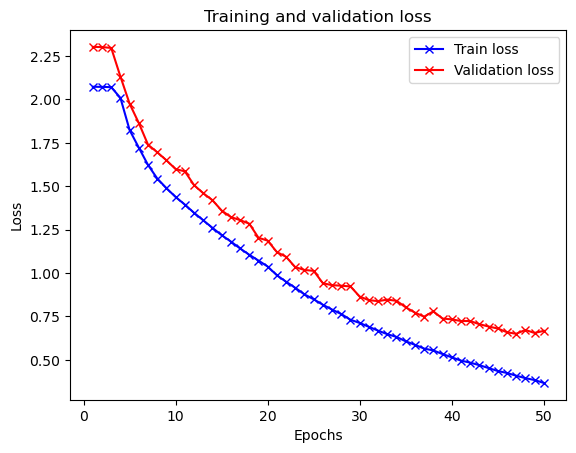

In [80]:
import matplotlib.pyplot as plt

# Define the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the train loss and val loss
plt.plot(epochs, train_loss, '-bx', label='Train loss')
plt.plot(epochs, validation_loss, '-rx', label='Validation loss')


# Set the title and labels for the graph
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()

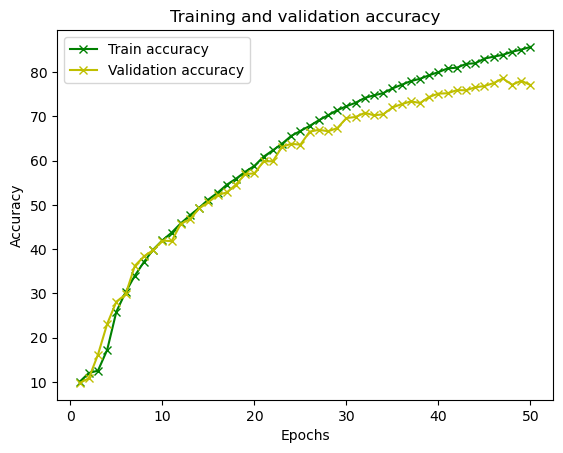

In [79]:
epochs = range(1, len(train_loss) + 1)
# Plot the train accuracy and val accuracy
plt.plot(epochs, train_accuracy, '-gx', label='Train accuracy')
plt.plot(epochs, validation_accuracy, '-yx', label='Validation accuracy')
# Set the title and labels for the graph
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()

In [81]:
# Evaluate the CNN on the test set
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = PandaNet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print the accuracy
print('Accuracy of the pre-trained CNN on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the pre-trained CNN on the 10000 test images: 77.95 %


# PandaNet3 with NAG and ReLU

In [11]:
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F

# Define the CNN architecture
class PandaNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1) #(depth of each conv2d,noof conv2d)
        self.conv2 = nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(128,256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.batch_norm1 = nn.BatchNorm2d(num_features=64)
        self.batch_norm2 = nn.BatchNorm2d(num_features=128)
        self.batch_norm3 = nn.BatchNorm2d(num_features=256)
        
        self.fc1 = nn.Linear(256 * 4 * 4,1024)
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x)) 
        x = self.pool(self.relu(self.conv2(x)))
        x = self.batch_norm1(x)
        x = self.relu(self.conv3(x))
        x = self.pool(self.relu(self.conv4(x)))
        x = self.batch_norm2(x)
        x = self.relu(self.conv5(x))
        x = self.pool(self.relu(self.conv6(x)))
        x = self.batch_norm3(x)
        
        x = x.view(-1, 256 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)

# Create an instance of the CNN
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PandaNet = PandaNet().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(PandaNet.parameters(), lr=0.001, momentum=0.9,nesterov=True)
summary(PandaNet)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            18,496
├─Conv2d: 1-3                            73,856
├─Conv2d: 1-4                            147,584
├─Conv2d: 1-5                            295,168
├─Conv2d: 1-6                            590,080
├─MaxPool2d: 1-7                         --
├─BatchNorm2d: 1-8                       128
├─BatchNorm2d: 1-9                       256
├─BatchNorm2d: 1-10                      512
├─Linear: 1-11                           4,195,328
├─Linear: 1-12                           524,800
├─Linear: 1-13                           5,130
├─ReLU: 1-14                             --
Total params: 5,852,234
Trainable params: 5,852,234
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            18,496
├─Conv2d: 1-3                            73,856
├─Conv2d: 1-4                            147,584
├─Conv2d: 1-5                            295,168
├─Conv2d: 1-6                            590,080
├─MaxPool2d: 1-7                         --
├─BatchNorm2d: 1-8                       128
├─BatchNorm2d: 1-9                       256
├─BatchNorm2d: 1-10                      512
├─Linear: 1-11                           4,195,328
├─Linear: 1-12                           524,800
├─Linear: 1-13                           5,130
├─ReLU: 1-14                             --
Total params: 5,852,234
Trainable params: 5,852,234
Non-trainable params: 0

In [14]:
from tqdm import tqdm
import time

start_time = time.time()

train_loss = []
train_accuracy = []
validation_loss = []
validation_accuracy = []

early_stopping = EarlyStopping(tolerance=5, min_delta=10)

for epoch in tqdm(range(50),desc="Loading..."):
    correct = 0
    total = 0
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = PandaNet(images)
        loss = criterion(outputs, labels)
        
        #checking Training Accuracy
        with torch.no_grad():
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    #testing val_acuuracy after each epoch
    total_val = 0
    correct_val = 0
    with torch.no_grad():
        for im_val,label_val in val_loader:
            im_val, label_val = im_val.to(device), label_val.to(device)
            output_val = PandaNet(im_val)
            val_loss = criterion(output_val, label_val)
            _, predicted_val = torch.max(output_val.data, 1)
            total_val += label_val.size(0)
            correct_val += (predicted_val == label_val).sum().item()

            
    print ('Epoch {} | Training Loss {:.2f} | Training Accuracy {:.2f}% | Validation Loss  {:.2f}| Validation Accuracy {}%'.format(epoch+1,running_loss/782,(100 * correct / total),(val_loss.item()),(100*correct_val/total_val)))
        
    train_loss.append(running_loss/782)
    train_accuracy.append(100 * correct / total)
    validation_loss.append(val_loss.item())
    validation_accuracy.append(100*correct_val/total_val)
    
    # early stopping
    early_stopping(running_loss/782, val_loss.item())
    if early_stopping.early_stop:
      print('early stop')
      break
        
torch.save(PandaNet.state_dict(), 'PandaNet7_NAG.pth')
    
end_time = time.time()
# Calculate the execution time
execution_time = end_time - start_time
# Print the execution time in seconds
print("Training time:", execution_time, "seconds")

Loading...:   2%|▏         | 1/50 [00:27<22:33, 27.61s/it]

Epoch 1 | Training Loss 2.07 | Training Accuracy 10.03% | Validation Loss  2.30| Validation Accuracy 9.96%


Loading...:   4%|▍         | 2/50 [00:50<19:59, 25.00s/it]

Epoch 2 | Training Loss 2.07 | Training Accuracy 10.59% | Validation Loss  2.30| Validation Accuracy 10.46%


Loading...:   6%|▌         | 3/50 [01:14<19:01, 24.29s/it]

Epoch 3 | Training Loss 2.07 | Training Accuracy 10.92% | Validation Loss  2.30| Validation Accuracy 14.9%


Loading...:   8%|▊         | 4/50 [01:37<18:27, 24.08s/it]

Epoch 4 | Training Loss 2.07 | Training Accuracy 14.47% | Validation Loss  2.30| Validation Accuracy 18.36%


Loading...:  10%|█         | 5/50 [02:00<17:45, 23.67s/it]

Epoch 5 | Training Loss 2.06 | Training Accuracy 16.95% | Validation Loss  2.24| Validation Accuracy 17.34%


Loading...:  12%|█▏        | 6/50 [02:23<17:05, 23.30s/it]

Epoch 6 | Training Loss 1.86 | Training Accuracy 23.98% | Validation Loss  2.00| Validation Accuracy 26.62%


Loading...:  14%|█▍        | 7/50 [02:46<16:44, 23.36s/it]

Epoch 7 | Training Loss 1.70 | Training Accuracy 28.95% | Validation Loss  1.88| Validation Accuracy 29.96%


Loading...:  16%|█▌        | 8/50 [03:09<16:12, 23.14s/it]

Epoch 8 | Training Loss 1.62 | Training Accuracy 32.39% | Validation Loss  1.77| Validation Accuracy 33.3%


Loading...:  18%|█▊        | 9/50 [03:31<15:36, 22.85s/it]

Epoch 9 | Training Loss 1.52 | Training Accuracy 37.09% | Validation Loss  1.67| Validation Accuracy 37.32%


Loading...:  20%|██        | 10/50 [03:54<15:10, 22.76s/it]

Epoch 10 | Training Loss 1.44 | Training Accuracy 41.08% | Validation Loss  1.66| Validation Accuracy 39.74%


Loading...:  22%|██▏       | 11/50 [04:16<14:44, 22.69s/it]

Epoch 11 | Training Loss 1.38 | Training Accuracy 43.86% | Validation Loss  1.51| Validation Accuracy 43.5%


Loading...:  24%|██▍       | 12/50 [04:38<14:14, 22.48s/it]

Epoch 12 | Training Loss 1.32 | Training Accuracy 46.19% | Validation Loss  1.52| Validation Accuracy 44.06%


Loading...:  26%|██▌       | 13/50 [05:01<13:47, 22.38s/it]

Epoch 13 | Training Loss 1.28 | Training Accuracy 47.88% | Validation Loss  1.43| Validation Accuracy 47.5%


Loading...:  28%|██▊       | 14/50 [05:23<13:23, 22.31s/it]

Epoch 14 | Training Loss 1.24 | Training Accuracy 49.87% | Validation Loss  1.51| Validation Accuracy 45.56%


Loading...:  30%|███       | 15/50 [05:45<13:04, 22.42s/it]

Epoch 15 | Training Loss 1.20 | Training Accuracy 51.35% | Validation Loss  1.32| Validation Accuracy 52.24%


Loading...:  32%|███▏      | 16/50 [06:07<12:35, 22.23s/it]

Epoch 16 | Training Loss 1.17 | Training Accuracy 53.22% | Validation Loss  1.36| Validation Accuracy 50.8%


Loading...:  34%|███▍      | 17/50 [06:29<12:12, 22.18s/it]

Epoch 17 | Training Loss 1.13 | Training Accuracy 54.81% | Validation Loss  1.26| Validation Accuracy 54.48%


Loading...:  36%|███▌      | 18/50 [06:52<11:52, 22.26s/it]

Epoch 18 | Training Loss 1.10 | Training Accuracy 56.01% | Validation Loss  1.36| Validation Accuracy 51.1%


Loading...:  38%|███▊      | 19/50 [07:13<11:25, 22.10s/it]

Epoch 19 | Training Loss 1.06 | Training Accuracy 57.66% | Validation Loss  1.37| Validation Accuracy 51.44%


Loading...:  40%|████      | 20/50 [07:36<11:04, 22.14s/it]

Epoch 20 | Training Loss 1.02 | Training Accuracy 59.35% | Validation Loss  1.17| Validation Accuracy 58.08%


Loading...:  42%|████▏     | 21/50 [07:58<10:39, 22.04s/it]

Epoch 21 | Training Loss 0.99 | Training Accuracy 60.84% | Validation Loss  1.18| Validation Accuracy 58.78%


Loading...:  44%|████▍     | 22/50 [08:19<10:12, 21.89s/it]

Epoch 22 | Training Loss 0.95 | Training Accuracy 62.38% | Validation Loss  1.17| Validation Accuracy 58.48%


Loading...:  46%|████▌     | 23/50 [08:41<09:52, 21.94s/it]

Epoch 23 | Training Loss 0.92 | Training Accuracy 63.60% | Validation Loss  1.07| Validation Accuracy 61.1%


Loading...:  48%|████▊     | 24/50 [09:04<09:35, 22.12s/it]

Epoch 24 | Training Loss 0.89 | Training Accuracy 65.00% | Validation Loss  1.05| Validation Accuracy 62.32%


Loading...:  50%|█████     | 25/50 [09:26<09:17, 22.30s/it]

Epoch 25 | Training Loss 0.85 | Training Accuracy 66.81% | Validation Loss  1.04| Validation Accuracy 62.64%


Loading...:  52%|█████▏    | 26/50 [09:49<08:59, 22.48s/it]

Epoch 26 | Training Loss 0.82 | Training Accuracy 67.73% | Validation Loss  1.06| Validation Accuracy 63.4%


Loading...:  54%|█████▍    | 27/50 [10:12<08:35, 22.43s/it]

Epoch 27 | Training Loss 0.79 | Training Accuracy 68.79% | Validation Loss  0.96| Validation Accuracy 67.06%


Loading...:  56%|█████▌    | 28/50 [10:34<08:11, 22.35s/it]

Epoch 28 | Training Loss 0.77 | Training Accuracy 70.14% | Validation Loss  0.96| Validation Accuracy 66.36%


Loading...:  58%|█████▊    | 29/50 [10:55<07:45, 22.17s/it]

Epoch 29 | Training Loss 0.74 | Training Accuracy 71.32% | Validation Loss  0.94| Validation Accuracy 66.26%


Loading...:  60%|██████    | 30/50 [11:18<07:22, 22.13s/it]

Epoch 30 | Training Loss 0.72 | Training Accuracy 72.13% | Validation Loss  0.88| Validation Accuracy 68.92%


Loading...:  62%|██████▏   | 31/50 [11:40<07:02, 22.21s/it]

Epoch 31 | Training Loss 0.69 | Training Accuracy 73.24% | Validation Loss  0.84| Validation Accuracy 69.84%


Loading...:  64%|██████▍   | 32/50 [12:02<06:37, 22.07s/it]

Epoch 32 | Training Loss 0.66 | Training Accuracy 74.43% | Validation Loss  0.82| Validation Accuracy 70.34%


Loading...:  66%|██████▌   | 33/50 [12:23<06:10, 21.81s/it]

Epoch 33 | Training Loss 0.64 | Training Accuracy 74.98% | Validation Loss  0.83| Validation Accuracy 70.82%


Loading...:  68%|██████▊   | 34/50 [12:45<05:50, 21.89s/it]

Epoch 34 | Training Loss 0.62 | Training Accuracy 76.02% | Validation Loss  0.75| Validation Accuracy 73.32%


Loading...:  70%|███████   | 35/50 [13:07<05:29, 21.94s/it]

Epoch 35 | Training Loss 0.60 | Training Accuracy 76.67% | Validation Loss  0.75| Validation Accuracy 74.2%


Loading...:  72%|███████▏  | 36/50 [13:29<05:06, 21.86s/it]

Epoch 36 | Training Loss 0.58 | Training Accuracy 77.51% | Validation Loss  0.74| Validation Accuracy 73.52%


Loading...:  74%|███████▍  | 37/50 [13:51<04:44, 21.90s/it]

Epoch 37 | Training Loss 0.56 | Training Accuracy 78.23% | Validation Loss  0.68| Validation Accuracy 76.08%


Loading...:  76%|███████▌  | 38/50 [14:13<04:24, 22.07s/it]

Epoch 38 | Training Loss 0.54 | Training Accuracy 78.84% | Validation Loss  0.70| Validation Accuracy 74.9%


Loading...:  78%|███████▊  | 39/50 [14:35<04:00, 21.85s/it]

Epoch 39 | Training Loss 0.52 | Training Accuracy 79.70% | Validation Loss  0.68| Validation Accuracy 75.92%


Loading...:  80%|████████  | 40/50 [14:57<03:39, 21.95s/it]

Epoch 40 | Training Loss 0.51 | Training Accuracy 80.19% | Validation Loss  0.77| Validation Accuracy 73.24%


Loading...:  82%|████████▏ | 41/50 [15:19<03:17, 21.95s/it]

Epoch 41 | Training Loss 0.49 | Training Accuracy 80.86% | Validation Loss  0.66| Validation Accuracy 77.26%


Loading...:  84%|████████▍ | 42/50 [15:40<02:55, 21.91s/it]

Epoch 42 | Training Loss 0.48 | Training Accuracy 81.36% | Validation Loss  0.64| Validation Accuracy 77.42%


Loading...:  86%|████████▌ | 43/50 [16:02<02:32, 21.76s/it]

Epoch 43 | Training Loss 0.46 | Training Accuracy 81.91% | Validation Loss  0.67| Validation Accuracy 77.6%


Loading...:  88%|████████▊ | 44/50 [16:23<02:10, 21.70s/it]

Epoch 44 | Training Loss 0.45 | Training Accuracy 82.31% | Validation Loss  0.63| Validation Accuracy 78.24%


Loading...:  90%|█████████ | 45/50 [16:45<01:48, 21.71s/it]

Epoch 45 | Training Loss 0.43 | Training Accuracy 83.19% | Validation Loss  0.65| Validation Accuracy 77.42%


Loading...:  92%|█████████▏| 46/50 [17:07<01:26, 21.61s/it]

Epoch 46 | Training Loss 0.42 | Training Accuracy 83.66% | Validation Loss  0.63| Validation Accuracy 77.72%


Loading...:  94%|█████████▍| 47/50 [17:28<01:04, 21.66s/it]

Epoch 47 | Training Loss 0.41 | Training Accuracy 84.03% | Validation Loss  0.63| Validation Accuracy 79.12%


Loading...:  96%|█████████▌| 48/50 [17:50<00:43, 21.65s/it]

Epoch 48 | Training Loss 0.39 | Training Accuracy 84.63% | Validation Loss  0.68| Validation Accuracy 77.82%


Loading...:  98%|█████████▊| 49/50 [18:11<00:21, 21.41s/it]

Epoch 49 | Training Loss 0.38 | Training Accuracy 84.99% | Validation Loss  0.59| Validation Accuracy 80.14%


Loading...: 100%|██████████| 50/50 [18:32<00:00, 22.25s/it]

Epoch 50 | Training Loss 0.37 | Training Accuracy 85.41% | Validation Loss  0.57| Validation Accuracy 80.74%
Training time: 1112.5222828388214 seconds


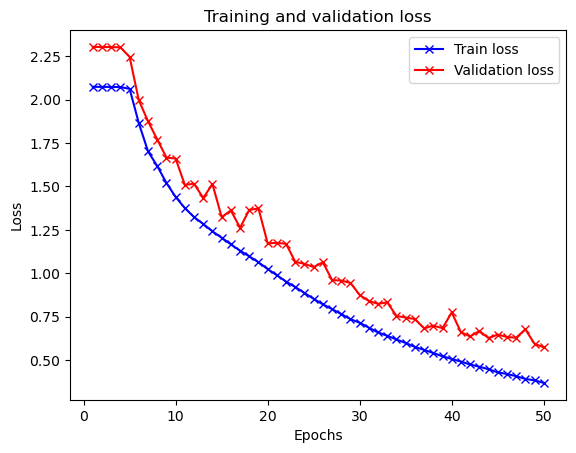

In [15]:
import matplotlib.pyplot as plt

# Define the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the train loss and val loss
plt.plot(epochs, train_loss, '-bx', label='Train loss')
plt.plot(epochs, validation_loss, '-rx', label='Validation loss')


# Set the title and labels for the graph
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()

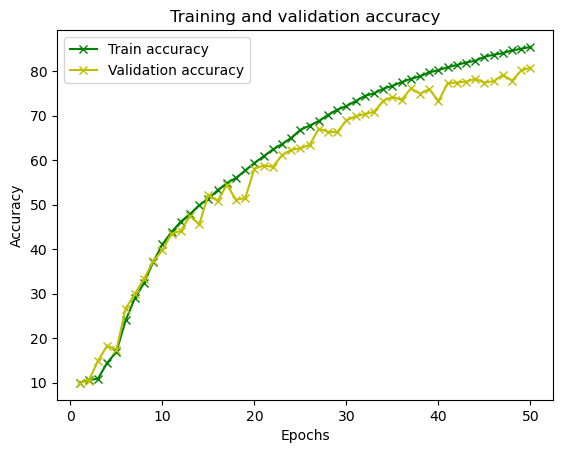

In [16]:
epochs = range(1, len(train_loss) + 1)
# Plot the train accuracy and val accuracy
plt.plot(epochs, train_accuracy, '-gx', label='Train accuracy')
plt.plot(epochs, validation_accuracy, '-yx', label='Validation accuracy')
# Set the title and labels for the graph
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()

In [17]:
# Evaluate the CNN on the test set
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = PandaNet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print the accuracy
print('Accuracy of the pre-trained CNN on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the pre-trained CNN on the 10000 test images: 80.46 %


# PandaNet3 with AdaDelta and ReLU

In [20]:
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F

# Define the CNN architecture
class PandaNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1) #(depth of each conv2d,noof conv2d)
        self.conv2 = nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(128,256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.batch_norm1 = nn.BatchNorm2d(num_features=64)
        self.batch_norm2 = nn.BatchNorm2d(num_features=128)
        self.batch_norm3 = nn.BatchNorm2d(num_features=256)
        
        self.fc1 = nn.Linear(256 * 4 * 4,1024)
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x)) 
        x = self.pool(self.relu(self.conv2(x)))
        x = self.batch_norm1(x)
        x = self.relu(self.conv3(x))
        x = self.pool(self.relu(self.conv4(x)))
        x = self.batch_norm2(x)
        x = self.relu(self.conv5(x))
        x = self.pool(self.relu(self.conv6(x)))
        x = self.batch_norm3(x)
        
        x = x.view(-1, 256 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)

# Create an instance of the CNN
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PandaNet = PandaNet().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adadelta(PandaNet.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)
summary(PandaNet)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            18,496
├─Conv2d: 1-3                            73,856
├─Conv2d: 1-4                            147,584
├─Conv2d: 1-5                            295,168
├─Conv2d: 1-6                            590,080
├─MaxPool2d: 1-7                         --
├─BatchNorm2d: 1-8                       128
├─BatchNorm2d: 1-9                       256
├─BatchNorm2d: 1-10                      512
├─Linear: 1-11                           4,195,328
├─Linear: 1-12                           524,800
├─Linear: 1-13                           5,130
├─ReLU: 1-14                             --
Total params: 5,852,234
Trainable params: 5,852,234
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            18,496
├─Conv2d: 1-3                            73,856
├─Conv2d: 1-4                            147,584
├─Conv2d: 1-5                            295,168
├─Conv2d: 1-6                            590,080
├─MaxPool2d: 1-7                         --
├─BatchNorm2d: 1-8                       128
├─BatchNorm2d: 1-9                       256
├─BatchNorm2d: 1-10                      512
├─Linear: 1-11                           4,195,328
├─Linear: 1-12                           524,800
├─Linear: 1-13                           5,130
├─ReLU: 1-14                             --
Total params: 5,852,234
Trainable params: 5,852,234
Non-trainable params: 0

In [21]:
from tqdm import tqdm
import time

start_time = time.time()

train_loss = []
train_accuracy = []
validation_loss = []
validation_accuracy = []

early_stopping = EarlyStopping(tolerance=5, min_delta=10)

for epoch in tqdm(range(50),desc="Loading..."):
    correct = 0
    total = 0
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = PandaNet(images)
        loss = criterion(outputs, labels)
        
        #checking Training Accuracy
        with torch.no_grad():
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    #testing val_acuuracy after each epoch
    total_val = 0
    correct_val = 0
    with torch.no_grad():
        for im_val,label_val in val_loader:
            im_val, label_val = im_val.to(device), label_val.to(device)
            output_val = PandaNet(im_val)
            val_loss = criterion(output_val, label_val)
            _, predicted_val = torch.max(output_val.data, 1)
            total_val += label_val.size(0)
            correct_val += (predicted_val == label_val).sum().item()

            
    print ('Epoch {} | Training Loss {:.2f} | Training Accuracy {:.2f}% | Validation Loss  {:.2f}| Validation Accuracy {}%'.format(epoch+1,running_loss/782,(100 * correct / total),(val_loss.item()),(100*correct_val/total_val)))
        
    train_loss.append(running_loss/782)
    train_accuracy.append(100 * correct / total)
    validation_loss.append(val_loss.item())
    validation_accuracy.append(100*correct_val/total_val)
    
    # early stopping
    early_stopping(running_loss/782, val_loss.item())
    if early_stopping.early_stop:
      print('early stop')
      break
        
torch.save(PandaNet.state_dict(), 'PandaNet7_NAG.pth')
    
end_time = time.time()
# Calculate the execution time
execution_time = end_time - start_time
# Print the execution time in seconds
print("Training time:", execution_time, "seconds")

Loading...:   2%|▏         | 1/50 [00:22<18:13, 22.31s/it]

Epoch 1 | Training Loss 1.76 | Training Accuracy 26.44% | Validation Loss  1.99| Validation Accuracy 31.24%


Loading...:   4%|▍         | 2/50 [00:44<17:45, 22.20s/it]

Epoch 2 | Training Loss 1.30 | Training Accuracy 47.06% | Validation Loss  1.89| Validation Accuracy 36.98%


Loading...:   6%|▌         | 3/50 [01:06<17:28, 22.31s/it]

Epoch 3 | Training Loss 1.02 | Training Accuracy 60.23% | Validation Loss  1.50| Validation Accuracy 54.5%


Loading...:   8%|▊         | 4/50 [01:29<17:14, 22.48s/it]

Epoch 4 | Training Loss 0.86 | Training Accuracy 66.98% | Validation Loss  1.03| Validation Accuracy 65.92%


Loading...:  10%|█         | 5/50 [01:51<16:44, 22.31s/it]

Epoch 5 | Training Loss 0.76 | Training Accuracy 71.35% | Validation Loss  1.41| Validation Accuracy 53.2%


Loading...:  12%|█▏        | 6/50 [02:14<16:26, 22.41s/it]

Epoch 6 | Training Loss 0.68 | Training Accuracy 74.40% | Validation Loss  0.78| Validation Accuracy 73.56%


Loading...:  14%|█▍        | 7/50 [02:36<16:06, 22.48s/it]

Epoch 7 | Training Loss 0.63 | Training Accuracy 76.33% | Validation Loss  0.82| Validation Accuracy 74.4%


Loading...:  16%|█▌        | 8/50 [02:59<15:43, 22.47s/it]

Epoch 8 | Training Loss 0.60 | Training Accuracy 77.64% | Validation Loss  0.83| Validation Accuracy 74.28%


Loading...:  18%|█▊        | 9/50 [03:21<15:18, 22.39s/it]

Epoch 9 | Training Loss 0.58 | Training Accuracy 78.65% | Validation Loss  0.78| Validation Accuracy 74.92%


Loading...:  20%|██        | 10/50 [03:44<15:02, 22.57s/it]

Epoch 10 | Training Loss 0.55 | Training Accuracy 80.05% | Validation Loss  0.78| Validation Accuracy 74.94%


Loading...:  22%|██▏       | 11/50 [04:07<14:45, 22.70s/it]

Epoch 11 | Training Loss 0.53 | Training Accuracy 80.76% | Validation Loss  0.98| Validation Accuracy 71.36%


Loading...:  24%|██▍       | 12/50 [04:29<14:17, 22.57s/it]

Epoch 12 | Training Loss 0.51 | Training Accuracy 81.44% | Validation Loss  0.80| Validation Accuracy 74.72%


Loading...:  26%|██▌       | 13/50 [04:52<13:52, 22.50s/it]

Epoch 13 | Training Loss 0.49 | Training Accuracy 82.07% | Validation Loss  0.87| Validation Accuracy 76.2%


Loading...:  28%|██▊       | 14/50 [05:14<13:31, 22.53s/it]

Epoch 14 | Training Loss 0.48 | Training Accuracy 82.66% | Validation Loss  0.84| Validation Accuracy 71.48%


Loading...:  30%|███       | 15/50 [05:37<13:10, 22.58s/it]

Epoch 15 | Training Loss 0.46 | Training Accuracy 83.24% | Validation Loss  0.76| Validation Accuracy 76.12%


Loading...:  32%|███▏      | 16/50 [05:59<12:44, 22.48s/it]

Epoch 16 | Training Loss 0.46 | Training Accuracy 83.60% | Validation Loss  0.87| Validation Accuracy 76.58%


Loading...:  34%|███▍      | 17/50 [06:22<12:24, 22.55s/it]

Epoch 17 | Training Loss 0.44 | Training Accuracy 84.36% | Validation Loss  0.84| Validation Accuracy 79.08%


Loading...:  36%|███▌      | 18/50 [06:45<12:03, 22.61s/it]

Epoch 18 | Training Loss 0.44 | Training Accuracy 84.48% | Validation Loss  0.77| Validation Accuracy 79.92%


Loading...:  38%|███▊      | 19/50 [07:07<11:37, 22.49s/it]

Epoch 19 | Training Loss 0.42 | Training Accuracy 84.73% | Validation Loss  0.75| Validation Accuracy 77.6%


Loading...:  40%|████      | 20/50 [07:30<11:16, 22.55s/it]

Epoch 20 | Training Loss 0.42 | Training Accuracy 85.23% | Validation Loss  0.90| Validation Accuracy 77.42%


Loading...:  42%|████▏     | 21/50 [07:52<10:53, 22.53s/it]

Epoch 21 | Training Loss 0.40 | Training Accuracy 85.75% | Validation Loss  0.69| Validation Accuracy 80.62%


Loading...:  44%|████▍     | 22/50 [08:15<10:32, 22.58s/it]

Epoch 22 | Training Loss 0.40 | Training Accuracy 85.88% | Validation Loss  0.83| Validation Accuracy 83.12%


Loading...:  46%|████▌     | 23/50 [08:37<10:04, 22.40s/it]

Epoch 23 | Training Loss 0.39 | Training Accuracy 86.22% | Validation Loss  0.94| Validation Accuracy 76.4%


Loading...:  48%|████▊     | 24/50 [08:59<09:44, 22.47s/it]

Epoch 24 | Training Loss 0.38 | Training Accuracy 86.61% | Validation Loss  0.71| Validation Accuracy 77.66%


Loading...:  50%|█████     | 25/50 [09:22<09:21, 22.45s/it]

Epoch 25 | Training Loss 0.38 | Training Accuracy 86.80% | Validation Loss  0.89| Validation Accuracy 75.06%


Loading...:  52%|█████▏    | 26/50 [09:44<08:55, 22.31s/it]

Epoch 26 | Training Loss 0.37 | Training Accuracy 86.92% | Validation Loss  1.37| Validation Accuracy 75.72%


Loading...:  54%|█████▍    | 27/50 [10:06<08:36, 22.45s/it]

Epoch 27 | Training Loss 0.36 | Training Accuracy 87.33% | Validation Loss  1.04| Validation Accuracy 79.62%


Loading...:  56%|█████▌    | 28/50 [10:29<08:13, 22.42s/it]

Epoch 28 | Training Loss 0.36 | Training Accuracy 87.48% | Validation Loss  0.63| Validation Accuracy 82.06%


Loading...:  58%|█████▊    | 29/50 [10:51<07:48, 22.29s/it]

Epoch 29 | Training Loss 0.35 | Training Accuracy 88.08% | Validation Loss  1.35| Validation Accuracy 79.72%


Loading...:  60%|██████    | 30/50 [11:13<07:27, 22.36s/it]

Epoch 30 | Training Loss 0.35 | Training Accuracy 88.09% | Validation Loss  0.70| Validation Accuracy 81.2%


Loading...:  62%|██████▏   | 31/50 [11:36<07:06, 22.46s/it]

Epoch 31 | Training Loss 0.34 | Training Accuracy 88.16% | Validation Loss  0.63| Validation Accuracy 82.98%


Loading...:  64%|██████▍   | 32/50 [11:59<06:45, 22.54s/it]

Epoch 32 | Training Loss 0.34 | Training Accuracy 88.48% | Validation Loss  1.11| Validation Accuracy 76.54%


Loading...:  66%|██████▌   | 33/50 [12:21<06:19, 22.35s/it]

Epoch 33 | Training Loss 0.34 | Training Accuracy 88.35% | Validation Loss  0.76| Validation Accuracy 77.48%


Loading...:  68%|██████▊   | 34/50 [12:43<05:59, 22.47s/it]

Epoch 34 | Training Loss 0.34 | Training Accuracy 88.56% | Validation Loss  0.67| Validation Accuracy 83.16%


Loading...:  70%|███████   | 35/50 [13:06<05:37, 22.52s/it]

Epoch 35 | Training Loss 0.34 | Training Accuracy 88.45% | Validation Loss  0.62| Validation Accuracy 82.3%


Loading...:  72%|███████▏  | 36/50 [13:28<05:13, 22.37s/it]

Epoch 36 | Training Loss 0.34 | Training Accuracy 88.63% | Validation Loss  0.73| Validation Accuracy 83.52%


Loading...:  74%|███████▍  | 37/50 [13:51<04:52, 22.46s/it]

Epoch 37 | Training Loss 0.32 | Training Accuracy 88.98% | Validation Loss  0.60| Validation Accuracy 84.12%


Loading...:  76%|███████▌  | 38/50 [14:13<04:30, 22.52s/it]

Epoch 38 | Training Loss 0.33 | Training Accuracy 89.08% | Validation Loss  0.72| Validation Accuracy 81.24%


Loading...:  78%|███████▊  | 39/50 [14:36<04:06, 22.44s/it]

Epoch 39 | Training Loss 0.32 | Training Accuracy 89.20% | Validation Loss  0.82| Validation Accuracy 83.96%


Loading...:  80%|████████  | 40/50 [14:57<03:41, 22.18s/it]

Epoch 40 | Training Loss 0.32 | Training Accuracy 89.21% | Validation Loss  1.18| Validation Accuracy 74.22%


Loading...:  82%|████████▏ | 41/50 [15:19<03:19, 22.18s/it]

Epoch 41 | Training Loss 0.32 | Training Accuracy 89.36% | Validation Loss  0.84| Validation Accuracy 77.3%


Loading...:  84%|████████▍ | 42/50 [15:42<02:57, 22.20s/it]

Epoch 42 | Training Loss 0.32 | Training Accuracy 89.37% | Validation Loss  0.57| Validation Accuracy 84.94%


Loading...:  86%|████████▌ | 43/50 [16:03<02:34, 22.05s/it]

Epoch 43 | Training Loss 0.31 | Training Accuracy 89.51% | Validation Loss  0.68| Validation Accuracy 83.52%


Loading...:  88%|████████▊ | 44/50 [16:26<02:13, 22.19s/it]

Epoch 44 | Training Loss 0.31 | Training Accuracy 89.75% | Validation Loss  0.79| Validation Accuracy 81.16%


Loading...:  90%|█████████ | 45/50 [16:48<01:51, 22.28s/it]

Epoch 45 | Training Loss 0.31 | Training Accuracy 89.81% | Validation Loss  1.15| Validation Accuracy 83.44%


Loading...:  92%|█████████▏| 46/50 [17:10<01:28, 22.20s/it]

Epoch 46 | Training Loss 0.31 | Training Accuracy 89.84% | Validation Loss  1.16| Validation Accuracy 77.86%


Loading...:  94%|█████████▍| 47/50 [17:32<01:06, 22.18s/it]

Epoch 47 | Training Loss 0.31 | Training Accuracy 89.76% | Validation Loss  1.02| Validation Accuracy 83.8%


Loading...:  96%|█████████▌| 48/50 [17:55<00:44, 22.31s/it]

Epoch 48 | Training Loss 0.31 | Training Accuracy 89.86% | Validation Loss  0.62| Validation Accuracy 84.56%


Loading...:  98%|█████████▊| 49/50 [18:18<00:22, 22.43s/it]

Epoch 49 | Training Loss 0.30 | Training Accuracy 90.00% | Validation Loss  1.06| Validation Accuracy 77.7%


Loading...: 100%|██████████| 50/50 [18:40<00:00, 22.41s/it]

Epoch 50 | Training Loss 0.29 | Training Accuracy 90.40% | Validation Loss  1.01| Validation Accuracy 78.36%
Training time: 1120.3554804325104 seconds


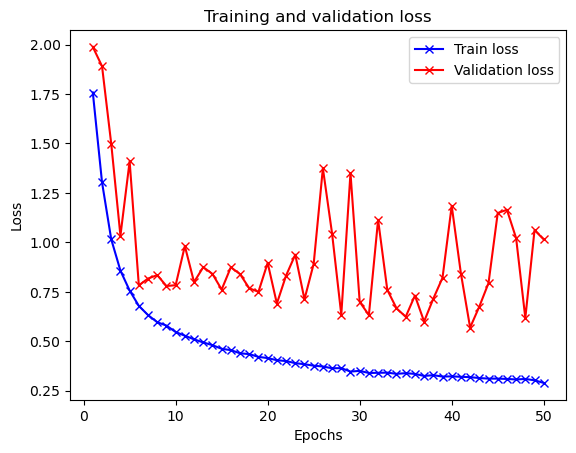

In [22]:
import matplotlib.pyplot as plt

# Define the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the train loss and val loss
plt.plot(epochs, train_loss, '-bx', label='Train loss')
plt.plot(epochs, validation_loss, '-rx', label='Validation loss')


# Set the title and labels for the graph
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()

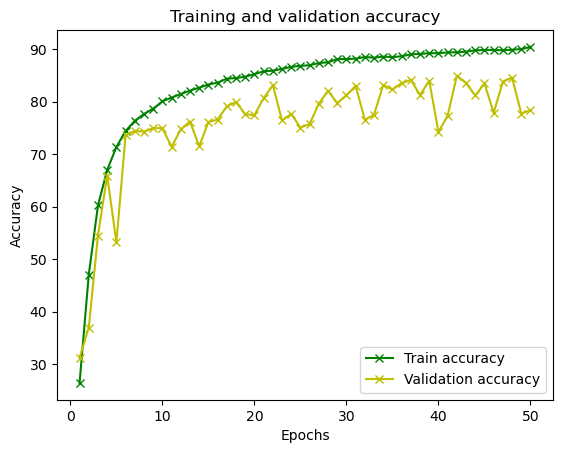

In [23]:
epochs = range(1, len(train_loss) + 1)
# Plot the train accuracy and val accuracy
plt.plot(epochs, train_accuracy, '-gx', label='Train accuracy')
plt.plot(epochs, validation_accuracy, '-yx', label='Validation accuracy')
# Set the title and labels for the graph
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()

In [24]:
# Evaluate the CNN on the test set
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = PandaNet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print the accuracy
print('Accuracy of the pre-trained CNN on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the pre-trained CNN on the 10000 test images: 78.57 %


# PandaNet3 with AdaGrad and ReLU

In [26]:
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F

# Define the CNN architecture
class PandaNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1) #(depth of each conv2d,noof conv2d)
        self.conv2 = nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(128,256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.batch_norm1 = nn.BatchNorm2d(num_features=64)
        self.batch_norm2 = nn.BatchNorm2d(num_features=128)
        self.batch_norm3 = nn.BatchNorm2d(num_features=256)
        
        self.fc1 = nn.Linear(256 * 4 * 4,1024)
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x)) 
        x = self.pool(self.relu(self.conv2(x)))
        x = self.batch_norm1(x)
        x = self.relu(self.conv3(x))
        x = self.pool(self.relu(self.conv4(x)))
        x = self.batch_norm2(x)
        x = self.relu(self.conv5(x))
        x = self.pool(self.relu(self.conv6(x)))
        x = self.batch_norm3(x)
        
        x = x.view(-1, 256 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)

# Create an instance of the CNN
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PandaNet = PandaNet().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(PandaNet.parameters(), lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10)
summary(PandaNet)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            18,496
├─Conv2d: 1-3                            73,856
├─Conv2d: 1-4                            147,584
├─Conv2d: 1-5                            295,168
├─Conv2d: 1-6                            590,080
├─MaxPool2d: 1-7                         --
├─BatchNorm2d: 1-8                       128
├─BatchNorm2d: 1-9                       256
├─BatchNorm2d: 1-10                      512
├─Linear: 1-11                           4,195,328
├─Linear: 1-12                           524,800
├─Linear: 1-13                           5,130
├─ReLU: 1-14                             --
Total params: 5,852,234
Trainable params: 5,852,234
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            18,496
├─Conv2d: 1-3                            73,856
├─Conv2d: 1-4                            147,584
├─Conv2d: 1-5                            295,168
├─Conv2d: 1-6                            590,080
├─MaxPool2d: 1-7                         --
├─BatchNorm2d: 1-8                       128
├─BatchNorm2d: 1-9                       256
├─BatchNorm2d: 1-10                      512
├─Linear: 1-11                           4,195,328
├─Linear: 1-12                           524,800
├─Linear: 1-13                           5,130
├─ReLU: 1-14                             --
Total params: 5,852,234
Trainable params: 5,852,234
Non-trainable params: 0

In [27]:
from tqdm import tqdm
import time

start_time = time.time()

train_loss = []
train_accuracy = []
validation_loss = []
validation_accuracy = []

early_stopping = EarlyStopping(tolerance=5, min_delta=10)

for epoch in tqdm(range(50),desc="Loading..."):
    correct = 0
    total = 0
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = PandaNet(images)
        loss = criterion(outputs, labels)
        
        #checking Training Accuracy
        with torch.no_grad():
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    #testing val_acuuracy after each epoch
    total_val = 0
    correct_val = 0
    with torch.no_grad():
        for im_val,label_val in val_loader:
            im_val, label_val = im_val.to(device), label_val.to(device)
            output_val = PandaNet(im_val)
            val_loss = criterion(output_val, label_val)
            _, predicted_val = torch.max(output_val.data, 1)
            total_val += label_val.size(0)
            correct_val += (predicted_val == label_val).sum().item()

            
    print ('Epoch {} | Training Loss {:.2f} | Training Accuracy {:.2f}% | Validation Loss  {:.2f}| Validation Accuracy {}%'.format(epoch+1,running_loss/782,(100 * correct / total),(val_loss.item()),(100*correct_val/total_val)))
        
    train_loss.append(running_loss/782)
    train_accuracy.append(100 * correct / total)
    validation_loss.append(val_loss.item())
    validation_accuracy.append(100*correct_val/total_val)
    
    # early stopping
    early_stopping(running_loss/782, val_loss.item())
    if early_stopping.early_stop:
      print('early stop')
      break
        
torch.save(PandaNet.state_dict(), 'PandaNet7_NAG.pth')
    
end_time = time.time()
# Calculate the execution time
execution_time = end_time - start_time
# Print the execution time in seconds
print("Training time:", execution_time, "seconds")

Loading...:   2%|▏         | 1/50 [00:21<17:57, 22.00s/it]

Epoch 1 | Training Loss 9.38 | Training Accuracy 30.67% | Validation Loss  2.09| Validation Accuracy 27.96%


Loading...:   4%|▍         | 2/50 [00:44<17:47, 22.25s/it]

Epoch 2 | Training Loss 1.35 | Training Accuracy 44.75% | Validation Loss  1.51| Validation Accuracy 44.12%


Loading...:   6%|▌         | 3/50 [01:06<17:24, 22.22s/it]

Epoch 3 | Training Loss 1.22 | Training Accuracy 50.40% | Validation Loss  1.46| Validation Accuracy 47.36%


Loading...:   8%|▊         | 4/50 [01:28<16:50, 21.97s/it]

Epoch 4 | Training Loss 1.14 | Training Accuracy 54.16% | Validation Loss  1.30| Validation Accuracy 52.62%


Loading...:  10%|█         | 5/50 [01:50<16:31, 22.04s/it]

Epoch 5 | Training Loss 1.07 | Training Accuracy 57.07% | Validation Loss  1.26| Validation Accuracy 53.42%


Loading...:  12%|█▏        | 6/50 [02:12<16:11, 22.08s/it]

Epoch 6 | Training Loss 1.01 | Training Accuracy 59.70% | Validation Loss  1.28| Validation Accuracy 54.12%


Loading...:  14%|█▍        | 7/50 [02:34<15:46, 22.02s/it]

Epoch 7 | Training Loss 0.95 | Training Accuracy 62.04% | Validation Loss  1.23| Validation Accuracy 55.72%


Loading...:  16%|█▌        | 8/50 [02:55<15:17, 21.85s/it]

Epoch 8 | Training Loss 0.91 | Training Accuracy 63.73% | Validation Loss  1.18| Validation Accuracy 58.76%


Loading...:  18%|█▊        | 9/50 [03:18<15:00, 21.95s/it]

Epoch 9 | Training Loss 0.86 | Training Accuracy 65.78% | Validation Loss  1.19| Validation Accuracy 58.6%


Loading...:  20%|██        | 10/50 [03:40<14:39, 21.99s/it]

Epoch 10 | Training Loss 0.82 | Training Accuracy 67.36% | Validation Loss  0.98| Validation Accuracy 64.76%


Loading...:  22%|██▏       | 11/50 [04:01<14:10, 21.82s/it]

Epoch 11 | Training Loss 0.79 | Training Accuracy 68.80% | Validation Loss  0.97| Validation Accuracy 65.24%


Loading...:  24%|██▍       | 12/50 [04:23<13:52, 21.91s/it]

Epoch 12 | Training Loss 0.75 | Training Accuracy 70.05% | Validation Loss  0.99| Validation Accuracy 64.84%


Loading...:  26%|██▌       | 13/50 [04:46<13:36, 22.06s/it]

Epoch 13 | Training Loss 0.72 | Training Accuracy 71.35% | Validation Loss  0.95| Validation Accuracy 66.48%


Loading...:  28%|██▊       | 14/50 [05:07<13:10, 21.97s/it]

Epoch 14 | Training Loss 0.70 | Training Accuracy 72.49% | Validation Loss  1.00| Validation Accuracy 64.54%


Loading...:  30%|███       | 15/50 [05:29<12:49, 22.00s/it]

Epoch 15 | Training Loss 0.67 | Training Accuracy 73.30% | Validation Loss  0.98| Validation Accuracy 65.54%


Loading...:  32%|███▏      | 16/50 [05:52<12:29, 22.03s/it]

Epoch 16 | Training Loss 0.65 | Training Accuracy 74.33% | Validation Loss  1.09| Validation Accuracy 62.46%


Loading...:  34%|███▍      | 17/50 [06:14<12:08, 22.07s/it]

Epoch 17 | Training Loss 0.63 | Training Accuracy 75.10% | Validation Loss  0.89| Validation Accuracy 69.12%


Loading...:  36%|███▌      | 18/50 [06:35<11:41, 21.92s/it]

Epoch 18 | Training Loss 0.61 | Training Accuracy 75.83% | Validation Loss  0.96| Validation Accuracy 67.86%


Loading...:  38%|███▊      | 19/50 [06:57<11:20, 21.97s/it]

Epoch 19 | Training Loss 0.59 | Training Accuracy 76.76% | Validation Loss  0.95| Validation Accuracy 67.44%


Loading...:  40%|████      | 20/50 [07:20<11:02, 22.07s/it]

Epoch 20 | Training Loss 0.58 | Training Accuracy 77.02% | Validation Loss  0.94| Validation Accuracy 67.2%


Loading...:  42%|████▏     | 21/50 [07:41<10:37, 21.97s/it]

Epoch 21 | Training Loss 0.56 | Training Accuracy 77.97% | Validation Loss  0.91| Validation Accuracy 68.66%


Loading...:  44%|████▍     | 22/50 [08:04<10:16, 22.03s/it]

Epoch 22 | Training Loss 0.54 | Training Accuracy 78.76% | Validation Loss  0.86| Validation Accuracy 70.3%


Loading...:  46%|████▌     | 23/50 [08:26<09:57, 22.12s/it]

Epoch 23 | Training Loss 0.52 | Training Accuracy 79.54% | Validation Loss  0.77| Validation Accuracy 73.44%


Loading...:  48%|████▊     | 24/50 [08:48<09:32, 22.02s/it]

Epoch 24 | Training Loss 0.51 | Training Accuracy 79.78% | Validation Loss  0.75| Validation Accuracy 73.8%


Loading...:  50%|█████     | 25/50 [09:10<09:11, 22.08s/it]

Epoch 25 | Training Loss 0.50 | Training Accuracy 80.69% | Validation Loss  0.70| Validation Accuracy 75.56%


Loading...:  52%|█████▏    | 26/50 [09:32<08:51, 22.15s/it]

Epoch 26 | Training Loss 0.48 | Training Accuracy 81.07% | Validation Loss  0.76| Validation Accuracy 74.34%


Loading...:  54%|█████▍    | 27/50 [09:54<08:29, 22.14s/it]

Epoch 27 | Training Loss 0.47 | Training Accuracy 81.62% | Validation Loss  0.74| Validation Accuracy 74.56%


Loading...:  56%|█████▌    | 28/50 [10:16<08:04, 22.01s/it]

Epoch 28 | Training Loss 0.46 | Training Accuracy 81.99% | Validation Loss  0.74| Validation Accuracy 74.3%


Loading...:  58%|█████▊    | 29/50 [10:38<07:43, 22.06s/it]

Epoch 29 | Training Loss 0.45 | Training Accuracy 82.40% | Validation Loss  0.92| Validation Accuracy 69.34%


Loading...:  60%|██████    | 30/50 [11:00<07:22, 22.12s/it]

Epoch 30 | Training Loss 0.43 | Training Accuracy 83.16% | Validation Loss  0.78| Validation Accuracy 74.66%


Loading...:  62%|██████▏   | 31/50 [11:22<06:58, 22.04s/it]

Epoch 31 | Training Loss 0.42 | Training Accuracy 83.43% | Validation Loss  0.82| Validation Accuracy 72.26%


Loading...:  64%|██████▍   | 32/50 [11:45<06:38, 22.15s/it]

Epoch 32 | Training Loss 0.42 | Training Accuracy 83.85% | Validation Loss  0.73| Validation Accuracy 74.84%


Loading...:  66%|██████▌   | 33/50 [12:07<06:16, 22.17s/it]

Epoch 33 | Training Loss 0.41 | Training Accuracy 84.03% | Validation Loss  0.67| Validation Accuracy 76.66%


Loading...:  68%|██████▊   | 34/50 [12:29<05:52, 22.01s/it]

Epoch 34 | Training Loss 0.39 | Training Accuracy 84.60% | Validation Loss  0.79| Validation Accuracy 73.28%


Loading...:  70%|███████   | 35/50 [12:51<05:31, 22.12s/it]

Epoch 35 | Training Loss 0.39 | Training Accuracy 84.78% | Validation Loss  0.83| Validation Accuracy 72.9%


Loading...:  72%|███████▏  | 36/50 [13:13<05:10, 22.15s/it]

Epoch 36 | Training Loss 0.37 | Training Accuracy 85.28% | Validation Loss  0.73| Validation Accuracy 75.92%


Loading...:  74%|███████▍  | 37/50 [13:36<04:48, 22.23s/it]

Epoch 37 | Training Loss 0.37 | Training Accuracy 85.51% | Validation Loss  0.75| Validation Accuracy 75.16%


Loading...:  76%|███████▌  | 38/50 [13:57<04:24, 22.04s/it]

Epoch 38 | Training Loss 0.35 | Training Accuracy 86.12% | Validation Loss  0.78| Validation Accuracy 74.34%


Loading...:  78%|███████▊  | 39/50 [14:19<04:03, 22.12s/it]

Epoch 39 | Training Loss 0.34 | Training Accuracy 86.42% | Validation Loss  0.70| Validation Accuracy 76.7%


Loading...:  80%|████████  | 40/50 [14:42<03:40, 22.09s/it]

Epoch 40 | Training Loss 0.34 | Training Accuracy 86.70% | Validation Loss  0.80| Validation Accuracy 74.14%


Loading...:  82%|████████▏ | 41/50 [15:03<03:17, 21.94s/it]

Epoch 41 | Training Loss 0.33 | Training Accuracy 87.17% | Validation Loss  0.67| Validation Accuracy 78.14%


Loading...:  84%|████████▍ | 42/50 [15:26<02:56, 22.09s/it]

Epoch 42 | Training Loss 0.32 | Training Accuracy 87.40% | Validation Loss  0.69| Validation Accuracy 77.98%


Loading...:  86%|████████▌ | 43/50 [15:48<02:35, 22.23s/it]

Epoch 43 | Training Loss 0.31 | Training Accuracy 87.96% | Validation Loss  0.70| Validation Accuracy 77.56%


Loading...:  88%|████████▊ | 44/50 [16:10<02:12, 22.03s/it]

Epoch 44 | Training Loss 0.30 | Training Accuracy 88.05% | Validation Loss  0.77| Validation Accuracy 75.46%


Loading...:  90%|█████████ | 45/50 [16:32<01:50, 22.05s/it]

Epoch 45 | Training Loss 0.29 | Training Accuracy 88.51% | Validation Loss  0.81| Validation Accuracy 75.48%


Loading...:  92%|█████████▏| 46/50 [16:54<01:28, 22.08s/it]

Epoch 46 | Training Loss 0.29 | Training Accuracy 88.90% | Validation Loss  0.71| Validation Accuracy 77.28%


Loading...:  94%|█████████▍| 47/50 [17:16<01:06, 22.04s/it]

Epoch 47 | Training Loss 0.28 | Training Accuracy 88.96% | Validation Loss  0.67| Validation Accuracy 78.22%


Loading...:  96%|█████████▌| 48/50 [17:37<00:43, 21.89s/it]

Epoch 48 | Training Loss 0.27 | Training Accuracy 89.27% | Validation Loss  0.69| Validation Accuracy 77.96%


Loading...:  98%|█████████▊| 49/50 [17:59<00:21, 21.93s/it]

Epoch 49 | Training Loss 0.27 | Training Accuracy 89.66% | Validation Loss  0.74| Validation Accuracy 76.96%


Loading...: 100%|██████████| 50/50 [18:22<00:00, 22.05s/it]

Epoch 50 | Training Loss 0.26 | Training Accuracy 89.90% | Validation Loss  0.73| Validation Accuracy 77.94%
Training time: 1102.4900753498077 seconds


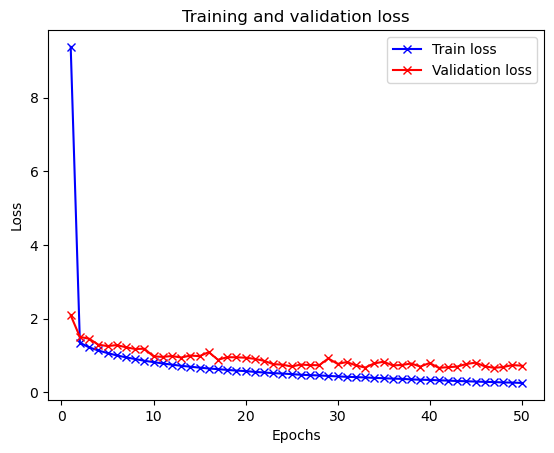

In [28]:
import matplotlib.pyplot as plt

# Define the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the train loss and val loss
plt.plot(epochs, train_loss, '-bx', label='Train loss')
plt.plot(epochs, validation_loss, '-rx', label='Validation loss')


# Set the title and labels for the graph
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()

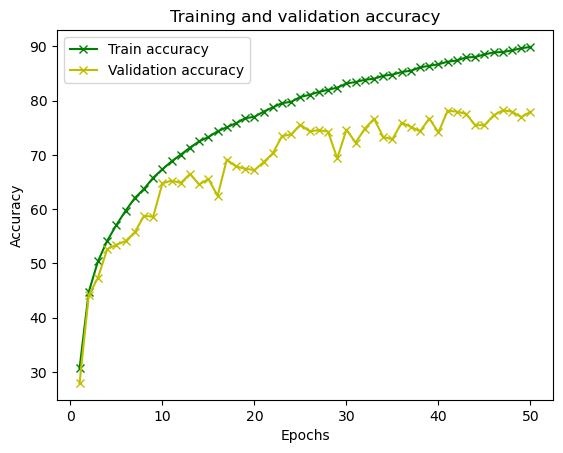

In [29]:
epochs = range(1, len(train_loss) + 1)
# Plot the train accuracy and val accuracy
plt.plot(epochs, train_accuracy, '-gx', label='Train accuracy')
plt.plot(epochs, validation_accuracy, '-yx', label='Validation accuracy')
# Set the title and labels for the graph
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()

In [30]:
# Evaluate the CNN on the test set
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = PandaNet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print the accuracy
print('Accuracy of the pre-trained CNN on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the pre-trained CNN on the 10000 test images: 77.27 %


# PandaNet3 with RMS_Prop and ReLU

In [33]:
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F

# Define the CNN architecture
class PandaNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1) #(depth of each conv2d,noof conv2d)
        self.conv2 = nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(128,256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.batch_norm1 = nn.BatchNorm2d(num_features=64)
        self.batch_norm2 = nn.BatchNorm2d(num_features=128)
        self.batch_norm3 = nn.BatchNorm2d(num_features=256)
        
        self.fc1 = nn.Linear(256 * 4 * 4,1024)
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x)) 
        x = self.pool(self.relu(self.conv2(x)))
        x = self.batch_norm1(x)
        x = self.relu(self.conv3(x))
        x = self.pool(self.relu(self.conv4(x)))
        x = self.batch_norm2(x)
        x = self.relu(self.conv5(x))
        x = self.pool(self.relu(self.conv6(x)))
        x = self.batch_norm3(x)
        
        x = x.view(-1, 256 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)

# Create an instance of the CNN
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PandaNet = PandaNet().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.RMSprop(PandaNet.parameters(), lr=0.001)
summary(PandaNet)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            18,496
├─Conv2d: 1-3                            73,856
├─Conv2d: 1-4                            147,584
├─Conv2d: 1-5                            295,168
├─Conv2d: 1-6                            590,080
├─MaxPool2d: 1-7                         --
├─BatchNorm2d: 1-8                       128
├─BatchNorm2d: 1-9                       256
├─BatchNorm2d: 1-10                      512
├─Linear: 1-11                           4,195,328
├─Linear: 1-12                           524,800
├─Linear: 1-13                           5,130
├─ReLU: 1-14                             --
Total params: 5,852,234
Trainable params: 5,852,234
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            18,496
├─Conv2d: 1-3                            73,856
├─Conv2d: 1-4                            147,584
├─Conv2d: 1-5                            295,168
├─Conv2d: 1-6                            590,080
├─MaxPool2d: 1-7                         --
├─BatchNorm2d: 1-8                       128
├─BatchNorm2d: 1-9                       256
├─BatchNorm2d: 1-10                      512
├─Linear: 1-11                           4,195,328
├─Linear: 1-12                           524,800
├─Linear: 1-13                           5,130
├─ReLU: 1-14                             --
Total params: 5,852,234
Trainable params: 5,852,234
Non-trainable params: 0

In [34]:
from tqdm import tqdm
import time

start_time = time.time()

train_loss = []
train_accuracy = []
validation_loss = []
validation_accuracy = []

early_stopping = EarlyStopping(tolerance=5, min_delta=10)

for epoch in tqdm(range(50),desc="Loading..."):
    correct = 0
    total = 0
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = PandaNet(images)
        loss = criterion(outputs, labels)
        
        #checking Training Accuracy
        with torch.no_grad():
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    #testing val_acuuracy after each epoch
    total_val = 0
    correct_val = 0
    with torch.no_grad():
        for im_val,label_val in val_loader:
            im_val, label_val = im_val.to(device), label_val.to(device)
            output_val = PandaNet(im_val)
            val_loss = criterion(output_val, label_val)
            _, predicted_val = torch.max(output_val.data, 1)
            total_val += label_val.size(0)
            correct_val += (predicted_val == label_val).sum().item()

            
    print ('Epoch {} | Training Loss {:.2f} | Training Accuracy {:.2f}% | Validation Loss  {:.2f}| Validation Accuracy {}%'.format(epoch+1,running_loss/782,(100 * correct / total),(val_loss.item()),(100*correct_val/total_val)))
        
    train_loss.append(running_loss/782)
    train_accuracy.append(100 * correct / total)
    validation_loss.append(val_loss.item())
    validation_accuracy.append(100*correct_val/total_val)
    
    # early stopping
    early_stopping(running_loss/782, val_loss.item())
    if early_stopping.early_stop:
      print('early stop')
      break
        
torch.save(PandaNet.state_dict(), 'PandaNet7_NAG.pth')
    
end_time = time.time()
# Calculate the execution time
execution_time = end_time - start_time
# Print the execution time in seconds
print("Training time:", execution_time, "seconds")

Loading...:   2%|▏         | 1/50 [00:22<18:16, 22.37s/it]

Epoch 1 | Training Loss 3.32 | Training Accuracy 26.46% | Validation Loss  2.37| Validation Accuracy 28.0%


Loading...:   4%|▍         | 2/50 [00:44<17:44, 22.17s/it]

Epoch 2 | Training Loss 1.34 | Training Accuracy 45.97% | Validation Loss  1.48| Validation Accuracy 46.54%


Loading...:   6%|▌         | 3/50 [01:05<17:07, 21.86s/it]

Epoch 3 | Training Loss 1.06 | Training Accuracy 57.72% | Validation Loss  1.38| Validation Accuracy 51.4%


Loading...:   8%|▊         | 4/50 [01:27<16:48, 21.92s/it]

Epoch 4 | Training Loss 0.86 | Training Accuracy 66.18% | Validation Loss  1.14| Validation Accuracy 60.62%


Loading...:  10%|█         | 5/50 [01:49<16:27, 21.95s/it]

Epoch 5 | Training Loss 0.74 | Training Accuracy 71.56% | Validation Loss  3.30| Validation Accuracy 33.96%


Loading...:  12%|█▏        | 6/50 [02:11<15:58, 21.79s/it]

Epoch 6 | Training Loss 0.65 | Training Accuracy 74.89% | Validation Loss  1.42| Validation Accuracy 57.68%


Loading...:  14%|█▍        | 7/50 [02:33<15:40, 21.88s/it]

Epoch 7 | Training Loss 0.60 | Training Accuracy 77.24% | Validation Loss  0.92| Validation Accuracy 69.12%


Loading...:  16%|█▌        | 8/50 [02:55<15:22, 21.95s/it]

Epoch 8 | Training Loss 0.55 | Training Accuracy 78.85% | Validation Loss  0.68| Validation Accuracy 76.64%


Loading...:  18%|█▊        | 9/50 [03:17<14:56, 21.86s/it]

Epoch 9 | Training Loss 0.52 | Training Accuracy 80.05% | Validation Loss  0.80| Validation Accuracy 73.02%


Loading...:  20%|██        | 10/50 [03:39<14:37, 21.95s/it]

Epoch 10 | Training Loss 0.49 | Training Accuracy 81.27% | Validation Loss  1.10| Validation Accuracy 65.6%


Loading...:  22%|██▏       | 11/50 [04:01<14:18, 22.02s/it]

Epoch 11 | Training Loss 0.46 | Training Accuracy 82.24% | Validation Loss  0.93| Validation Accuracy 74.34%


Loading...:  24%|██▍       | 12/50 [04:23<13:59, 22.09s/it]

Epoch 12 | Training Loss 0.45 | Training Accuracy 82.98% | Validation Loss  0.91| Validation Accuracy 71.48%


Loading...:  26%|██▌       | 13/50 [04:45<13:32, 21.95s/it]

Epoch 13 | Training Loss 0.43 | Training Accuracy 83.94% | Validation Loss  0.78| Validation Accuracy 76.42%


Loading...:  28%|██▊       | 14/50 [05:07<13:13, 22.04s/it]

Epoch 14 | Training Loss 0.41 | Training Accuracy 84.37% | Validation Loss  0.72| Validation Accuracy 77.14%


Loading...:  30%|███       | 15/50 [05:29<12:53, 22.10s/it]

Epoch 15 | Training Loss 0.40 | Training Accuracy 84.92% | Validation Loss  0.60| Validation Accuracy 81.62%


Loading...:  32%|███▏      | 16/50 [05:51<12:27, 21.98s/it]

Epoch 16 | Training Loss 0.39 | Training Accuracy 85.18% | Validation Loss  0.88| Validation Accuracy 74.56%


Loading...:  34%|███▍      | 17/50 [06:13<12:08, 22.07s/it]

Epoch 17 | Training Loss 0.37 | Training Accuracy 85.92% | Validation Loss  0.78| Validation Accuracy 76.58%


Loading...:  36%|███▌      | 18/50 [06:36<11:48, 22.13s/it]

Epoch 18 | Training Loss 0.37 | Training Accuracy 86.18% | Validation Loss  1.67| Validation Accuracy 62.1%


Loading...:  38%|███▊      | 19/50 [06:57<11:23, 22.03s/it]

Epoch 19 | Training Loss 0.36 | Training Accuracy 86.66% | Validation Loss  0.66| Validation Accuracy 79.62%


Loading...:  40%|████      | 20/50 [07:20<11:03, 22.10s/it]

Epoch 20 | Training Loss 0.35 | Training Accuracy 86.68% | Validation Loss  0.60| Validation Accuracy 79.82%


Loading...:  42%|████▏     | 21/50 [07:42<10:39, 22.06s/it]

Epoch 21 | Training Loss 0.35 | Training Accuracy 86.95% | Validation Loss  0.53| Validation Accuracy 83.08%


Loading...:  44%|████▍     | 22/50 [08:04<10:15, 21.99s/it]

Epoch 22 | Training Loss 0.33 | Training Accuracy 87.60% | Validation Loss  0.69| Validation Accuracy 77.98%


Loading...:  46%|████▌     | 23/50 [08:25<09:49, 21.84s/it]

Epoch 23 | Training Loss 0.33 | Training Accuracy 87.75% | Validation Loss  0.99| Validation Accuracy 73.2%


Loading...:  48%|████▊     | 24/50 [08:47<09:29, 21.90s/it]

Epoch 24 | Training Loss 0.32 | Training Accuracy 87.98% | Validation Loss  0.53| Validation Accuracy 82.46%


Loading...:  50%|█████     | 25/50 [09:09<09:08, 21.93s/it]

Epoch 25 | Training Loss 0.31 | Training Accuracy 88.25% | Validation Loss  0.69| Validation Accuracy 76.76%


Loading...:  52%|█████▏    | 26/50 [09:31<08:43, 21.82s/it]

Epoch 26 | Training Loss 0.31 | Training Accuracy 88.34% | Validation Loss  0.66| Validation Accuracy 78.26%


Loading...:  54%|█████▍    | 27/50 [09:53<08:25, 21.99s/it]

Epoch 27 | Training Loss 0.30 | Training Accuracy 88.74% | Validation Loss  0.63| Validation Accuracy 82.7%


Loading...:  56%|█████▌    | 28/50 [10:15<08:04, 22.04s/it]

Epoch 28 | Training Loss 0.29 | Training Accuracy 89.20% | Validation Loss  0.63| Validation Accuracy 80.86%


Loading...:  58%|█████▊    | 29/50 [10:37<07:39, 21.88s/it]

Epoch 29 | Training Loss 0.30 | Training Accuracy 89.10% | Validation Loss  0.60| Validation Accuracy 82.72%


Loading...:  60%|██████    | 30/50 [10:59<07:20, 22.00s/it]

Epoch 30 | Training Loss 0.29 | Training Accuracy 89.23% | Validation Loss  1.05| Validation Accuracy 73.72%


Loading...:  62%|██████▏   | 31/50 [11:21<06:58, 22.03s/it]

Epoch 31 | Training Loss 0.28 | Training Accuracy 89.52% | Validation Loss  1.02| Validation Accuracy 74.28%


Loading...:  64%|██████▍   | 32/50 [11:43<06:36, 22.01s/it]

Epoch 32 | Training Loss 0.28 | Training Accuracy 89.64% | Validation Loss  0.57| Validation Accuracy 83.36%


Loading...:  66%|██████▌   | 33/50 [12:05<06:11, 21.86s/it]

Epoch 33 | Training Loss 0.26 | Training Accuracy 90.04% | Validation Loss  0.65| Validation Accuracy 83.88%


Loading...:  68%|██████▊   | 34/50 [12:27<05:52, 22.03s/it]

Epoch 34 | Training Loss 0.62 | Training Accuracy 86.52% | Validation Loss  0.57| Validation Accuracy 82.84%


Loading...:  70%|███████   | 35/50 [12:49<05:31, 22.08s/it]

Epoch 35 | Training Loss 0.25 | Training Accuracy 90.70% | Validation Loss  0.56| Validation Accuracy 83.0%


Loading...:  72%|███████▏  | 36/50 [13:11<05:07, 21.95s/it]

Epoch 36 | Training Loss 0.26 | Training Accuracy 90.28% | Validation Loss  0.46| Validation Accuracy 85.5%


Loading...:  74%|███████▍  | 37/50 [13:33<04:46, 22.06s/it]

Epoch 37 | Training Loss 0.25 | Training Accuracy 90.60% | Validation Loss  0.72| Validation Accuracy 82.54%


Loading...:  76%|███████▌  | 38/50 [13:56<04:26, 22.19s/it]

Epoch 38 | Training Loss 0.26 | Training Accuracy 90.51% | Validation Loss  0.69| Validation Accuracy 81.66%


Loading...:  78%|███████▊  | 39/50 [14:17<04:02, 22.07s/it]

Epoch 39 | Training Loss 0.24 | Training Accuracy 90.94% | Validation Loss  0.66| Validation Accuracy 80.8%


Loading...:  80%|████████  | 40/50 [14:40<03:41, 22.10s/it]

Epoch 40 | Training Loss 0.24 | Training Accuracy 91.10% | Validation Loss  0.63| Validation Accuracy 84.12%


Loading...:  82%|████████▏ | 41/50 [15:02<03:18, 22.08s/it]

Epoch 41 | Training Loss 0.25 | Training Accuracy 90.74% | Validation Loss  0.63| Validation Accuracy 81.08%


Loading...:  84%|████████▍ | 42/50 [15:24<02:56, 22.07s/it]

Epoch 42 | Training Loss 0.23 | Training Accuracy 91.18% | Validation Loss  0.63| Validation Accuracy 82.8%


Loading...:  86%|████████▌ | 43/50 [15:45<02:33, 21.90s/it]

Epoch 43 | Training Loss 0.27 | Training Accuracy 90.70% | Validation Loss  0.63| Validation Accuracy 81.96%


Loading...:  88%|████████▊ | 44/50 [16:07<02:11, 21.91s/it]

Epoch 44 | Training Loss 0.22 | Training Accuracy 91.72% | Validation Loss  0.76| Validation Accuracy 80.34%


Loading...:  90%|█████████ | 45/50 [16:29<01:50, 22.05s/it]

Epoch 45 | Training Loss 0.23 | Training Accuracy 91.67% | Validation Loss  0.54| Validation Accuracy 83.12%


Loading...:  92%|█████████▏| 46/50 [16:51<01:27, 21.89s/it]

Epoch 46 | Training Loss 0.22 | Training Accuracy 91.74% | Validation Loss  0.75| Validation Accuracy 80.44%


Loading...:  94%|█████████▍| 47/50 [17:13<01:05, 21.95s/it]

Epoch 47 | Training Loss 0.23 | Training Accuracy 91.67% | Validation Loss  0.51| Validation Accuracy 85.96%


Loading...:  96%|█████████▌| 48/50 [17:35<00:44, 22.02s/it]

Epoch 48 | Training Loss 0.23 | Training Accuracy 91.67% | Validation Loss  1.28| Validation Accuracy 75.58%


Loading...:  98%|█████████▊| 49/50 [17:57<00:21, 21.85s/it]

Epoch 49 | Training Loss 0.21 | Training Accuracy 92.03% | Validation Loss  1.16| Validation Accuracy 72.66%


Loading...: 100%|██████████| 50/50 [18:19<00:00, 21.98s/it]

Epoch 50 | Training Loss 0.22 | Training Accuracy 92.12% | Validation Loss  0.62| Validation Accuracy 84.04%
Training time: 1099.297334909439 seconds


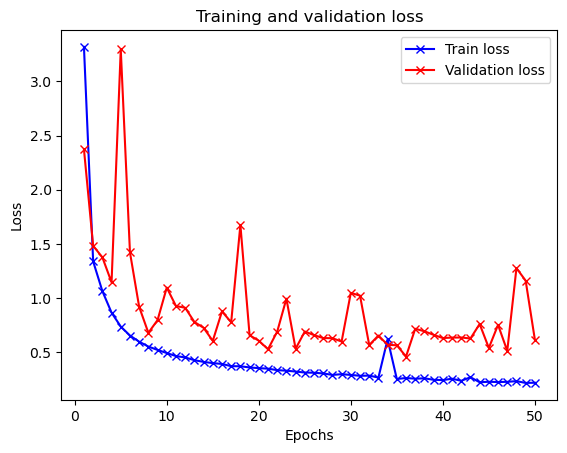

In [35]:
import matplotlib.pyplot as plt

# Define the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the train loss and val loss
plt.plot(epochs, train_loss, '-bx', label='Train loss')
plt.plot(epochs, validation_loss, '-rx', label='Validation loss')


# Set the title and labels for the graph
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()

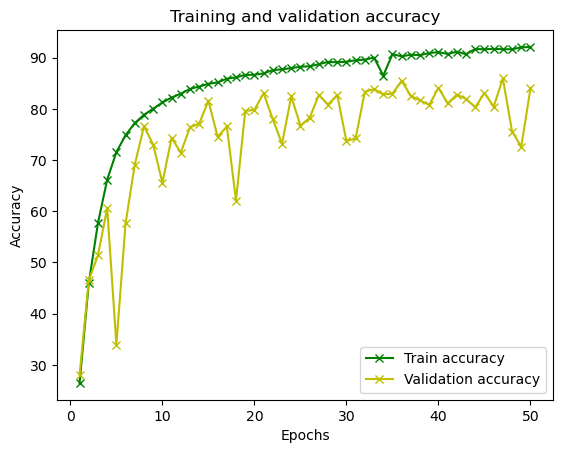

In [36]:
epochs = range(1, len(train_loss) + 1)
# Plot the train accuracy and val accuracy
plt.plot(epochs, train_accuracy, '-gx', label='Train accuracy')
plt.plot(epochs, validation_accuracy, '-yx', label='Validation accuracy')
# Set the title and labels for the graph
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()

In [37]:
# Evaluate the CNN on the test set
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = PandaNet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print the accuracy
print('Accuracy of the pre-trained CNN on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the pre-trained CNN on the 10000 test images: 84.67 %


# PandaNet3 with Adam and ReLU

In [10]:
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F

# Define the CNN architecture
class PandaNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1) #(depth of each conv2d,noof conv2d)
        self.conv2 = nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(128,256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.batch_norm1 = nn.BatchNorm2d(num_features=64)
        self.batch_norm2 = nn.BatchNorm2d(num_features=128)
        self.batch_norm3 = nn.BatchNorm2d(num_features=256)
        
        self.fc1 = nn.Linear(256 * 4 * 4,1024)
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x)) 
        x = self.pool(self.relu(self.conv2(x)))
        x = self.batch_norm1(x)
        x = self.relu(self.conv3(x))
        x = self.pool(self.relu(self.conv4(x)))
        x = self.batch_norm2(x)
        x = self.relu(self.conv5(x))
        x = self.pool(self.relu(self.conv6(x)))
        x = self.batch_norm3(x)
        
        x = x.view(-1, 256 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)

# Create an instance of the CNN
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PandaNet = PandaNet().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(PandaNet.parameters(), lr=0.001)
summary(PandaNet)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            18,496
├─Conv2d: 1-3                            73,856
├─Conv2d: 1-4                            147,584
├─Conv2d: 1-5                            295,168
├─Conv2d: 1-6                            590,080
├─MaxPool2d: 1-7                         --
├─BatchNorm2d: 1-8                       128
├─BatchNorm2d: 1-9                       256
├─BatchNorm2d: 1-10                      512
├─Linear: 1-11                           4,195,328
├─Linear: 1-12                           524,800
├─Linear: 1-13                           5,130
├─ReLU: 1-14                             --
Total params: 5,852,234
Trainable params: 5,852,234
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            18,496
├─Conv2d: 1-3                            73,856
├─Conv2d: 1-4                            147,584
├─Conv2d: 1-5                            295,168
├─Conv2d: 1-6                            590,080
├─MaxPool2d: 1-7                         --
├─BatchNorm2d: 1-8                       128
├─BatchNorm2d: 1-9                       256
├─BatchNorm2d: 1-10                      512
├─Linear: 1-11                           4,195,328
├─Linear: 1-12                           524,800
├─Linear: 1-13                           5,130
├─ReLU: 1-14                             --
Total params: 5,852,234
Trainable params: 5,852,234
Non-trainable params: 0

In [11]:
from tqdm import tqdm
import time

start_time = time.time()

train_loss = []
train_accuracy = []
validation_loss = []
validation_accuracy = []

early_stopping = EarlyStopping(tolerance=5, min_delta=10)

for epoch in tqdm(range(50),desc="Loading..."):
    correct = 0
    total = 0
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = PandaNet(images)
        loss = criterion(outputs, labels)
        
        #checking Training Accuracy
        with torch.no_grad():
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    #testing val_acuuracy after each epoch
    total_val = 0
    correct_val = 0
    with torch.no_grad():
        for im_val,label_val in val_loader:
            im_val, label_val = im_val.to(device), label_val.to(device)
            output_val = PandaNet(im_val)
            val_loss = criterion(output_val, label_val)
            _, predicted_val = torch.max(output_val.data, 1)
            total_val += label_val.size(0)
            correct_val += (predicted_val == label_val).sum().item()

            
    print ('Epoch {} | Training Loss {:.2f} | Training Accuracy {:.2f}% | Validation Loss  {:.2f}| Validation Accuracy {}%'.format(epoch+1,running_loss/782,(100 * correct / total),(val_loss.item()),(100*correct_val/total_val)))
        
    train_loss.append(running_loss/782)
    train_accuracy.append(100 * correct / total)
    validation_loss.append(val_loss.item())
    validation_accuracy.append(100*correct_val/total_val)
    
    # early stopping
    early_stopping(running_loss/782, val_loss.item())
    if early_stopping.early_stop:
      print('early stop')
      break
        
torch.save(PandaNet.state_dict(), 'PandaNet7_NAG.pth')
    
end_time = time.time()
# Calculate the execution time
execution_time = end_time - start_time
# Print the execution time in seconds
print("Training time:", execution_time, "seconds")

Loading...:   2%|▏         | 1/50 [00:27<22:30, 27.55s/it]

Epoch 1 | Training Loss 1.54 | Training Accuracy 34.92% | Validation Loss  1.45| Validation Accuracy 47.52%


Loading...:   4%|▍         | 2/50 [00:53<21:30, 26.88s/it]

Epoch 2 | Training Loss 1.08 | Training Accuracy 56.44% | Validation Loss  1.12| Validation Accuracy 59.54%


Loading...:   6%|▌         | 3/50 [01:16<19:23, 24.75s/it]

Epoch 3 | Training Loss 0.85 | Training Accuracy 66.22% | Validation Loss  0.91| Validation Accuracy 68.04%


Loading...:   8%|▊         | 4/50 [01:38<18:05, 23.61s/it]

Epoch 4 | Training Loss 0.71 | Training Accuracy 72.02% | Validation Loss  0.82| Validation Accuracy 72.1%


Loading...:  10%|█         | 5/50 [01:59<17:03, 22.75s/it]

Epoch 5 | Training Loss 0.63 | Training Accuracy 75.47% | Validation Loss  0.79| Validation Accuracy 73.48%


Loading...:  12%|█▏        | 6/50 [02:21<16:27, 22.43s/it]

Epoch 6 | Training Loss 0.58 | Training Accuracy 77.76% | Validation Loss  0.68| Validation Accuracy 77.02%


Loading...:  14%|█▍        | 7/50 [02:42<15:53, 22.18s/it]

Epoch 7 | Training Loss 0.53 | Training Accuracy 79.50% | Validation Loss  0.65| Validation Accuracy 77.28%


Loading...:  16%|█▌        | 8/50 [03:04<15:24, 22.02s/it]

Epoch 8 | Training Loss 0.50 | Training Accuracy 80.60% | Validation Loss  0.66| Validation Accuracy 77.44%


Loading...:  18%|█▊        | 9/50 [03:26<15:04, 22.06s/it]

Epoch 9 | Training Loss 0.47 | Training Accuracy 81.87% | Validation Loss  0.60| Validation Accuracy 79.58%


Loading...:  20%|██        | 10/50 [03:48<14:39, 21.98s/it]

Epoch 10 | Training Loss 0.45 | Training Accuracy 82.70% | Validation Loss  0.58| Validation Accuracy 80.04%


Loading...:  22%|██▏       | 11/50 [04:09<14:10, 21.80s/it]

Epoch 11 | Training Loss 0.42 | Training Accuracy 83.62% | Validation Loss  0.58| Validation Accuracy 80.18%


Loading...:  24%|██▍       | 12/50 [04:31<13:51, 21.89s/it]

Epoch 12 | Training Loss 0.41 | Training Accuracy 84.18% | Validation Loss  0.60| Validation Accuracy 80.16%


Loading...:  26%|██▌       | 13/50 [04:53<13:32, 21.96s/it]

Epoch 13 | Training Loss 0.40 | Training Accuracy 84.82% | Validation Loss  0.62| Validation Accuracy 79.64%


Loading...:  28%|██▊       | 14/50 [05:15<13:09, 21.92s/it]

Epoch 14 | Training Loss 0.38 | Training Accuracy 85.39% | Validation Loss  0.54| Validation Accuracy 81.92%


Loading...:  30%|███       | 15/50 [05:36<12:37, 21.65s/it]

Epoch 15 | Training Loss 0.37 | Training Accuracy 85.77% | Validation Loss  0.60| Validation Accuracy 80.1%


Loading...:  32%|███▏      | 16/50 [05:58<12:16, 21.65s/it]

Epoch 16 | Training Loss 0.35 | Training Accuracy 86.46% | Validation Loss  0.58| Validation Accuracy 80.54%


Loading...:  34%|███▍      | 17/50 [06:19<11:52, 21.58s/it]

Epoch 17 | Training Loss 0.35 | Training Accuracy 86.73% | Validation Loss  0.54| Validation Accuracy 82.98%


Loading...:  36%|███▌      | 18/50 [06:40<11:25, 21.41s/it]

Epoch 18 | Training Loss 0.33 | Training Accuracy 87.30% | Validation Loss  0.56| Validation Accuracy 82.22%


Loading...:  38%|███▊      | 19/50 [07:03<11:10, 21.63s/it]

Epoch 19 | Training Loss 0.33 | Training Accuracy 87.54% | Validation Loss  0.57| Validation Accuracy 81.56%


Loading...:  40%|████      | 20/50 [07:25<10:54, 21.82s/it]

Epoch 20 | Training Loss 0.32 | Training Accuracy 87.82% | Validation Loss  0.54| Validation Accuracy 82.82%


Loading...:  42%|████▏     | 21/50 [07:46<10:25, 21.58s/it]

Epoch 21 | Training Loss 0.31 | Training Accuracy 88.21% | Validation Loss  0.54| Validation Accuracy 82.5%


Loading...:  44%|████▍     | 22/50 [08:08<10:07, 21.70s/it]

Epoch 22 | Training Loss 0.30 | Training Accuracy 88.45% | Validation Loss  0.54| Validation Accuracy 83.3%


Loading...:  46%|████▌     | 23/50 [08:30<09:46, 21.73s/it]

Epoch 23 | Training Loss 0.29 | Training Accuracy 88.60% | Validation Loss  0.56| Validation Accuracy 82.22%


Loading...:  48%|████▊     | 24/50 [08:51<09:21, 21.59s/it]

Epoch 24 | Training Loss 0.29 | Training Accuracy 88.89% | Validation Loss  0.53| Validation Accuracy 83.4%


Loading...:  50%|█████     | 25/50 [09:12<08:58, 21.55s/it]

Epoch 25 | Training Loss 0.28 | Training Accuracy 89.49% | Validation Loss  0.50| Validation Accuracy 84.32%


Loading...:  52%|█████▏    | 26/50 [09:34<08:40, 21.67s/it]

Epoch 26 | Training Loss 0.27 | Training Accuracy 89.58% | Validation Loss  0.50| Validation Accuracy 84.44%


Loading...:  54%|█████▍    | 27/50 [09:56<08:16, 21.59s/it]

Epoch 27 | Training Loss 0.27 | Training Accuracy 89.53% | Validation Loss  0.53| Validation Accuracy 83.26%


Loading...:  56%|█████▌    | 28/50 [10:18<07:57, 21.69s/it]

Epoch 28 | Training Loss 0.26 | Training Accuracy 90.15% | Validation Loss  0.52| Validation Accuracy 84.26%


Loading...:  58%|█████▊    | 29/50 [10:39<07:35, 21.69s/it]

Epoch 29 | Training Loss 0.26 | Training Accuracy 90.21% | Validation Loss  0.52| Validation Accuracy 84.18%


Loading...:  60%|██████    | 30/50 [11:01<07:13, 21.66s/it]

Epoch 30 | Training Loss 0.25 | Training Accuracy 90.46% | Validation Loss  0.54| Validation Accuracy 84.78%


Loading...:  62%|██████▏   | 31/50 [11:23<06:52, 21.69s/it]

Epoch 31 | Training Loss 0.25 | Training Accuracy 90.62% | Validation Loss  0.55| Validation Accuracy 83.76%


Loading...:  64%|██████▍   | 32/50 [11:44<06:30, 21.71s/it]

Epoch 32 | Training Loss 0.24 | Training Accuracy 90.84% | Validation Loss  0.51| Validation Accuracy 84.3%


Loading...:  66%|██████▌   | 33/50 [12:05<06:05, 21.49s/it]

Epoch 33 | Training Loss 0.24 | Training Accuracy 91.12% | Validation Loss  0.57| Validation Accuracy 83.74%


Loading...:  68%|██████▊   | 34/50 [12:27<05:45, 21.59s/it]

Epoch 34 | Training Loss 0.23 | Training Accuracy 91.12% | Validation Loss  0.52| Validation Accuracy 83.88%


Loading...:  70%|███████   | 35/50 [12:49<05:24, 21.62s/it]

Epoch 35 | Training Loss 0.22 | Training Accuracy 91.55% | Validation Loss  0.57| Validation Accuracy 83.78%


Loading...:  72%|███████▏  | 36/50 [13:11<05:02, 21.63s/it]

Epoch 36 | Training Loss 0.22 | Training Accuracy 91.45% | Validation Loss  0.56| Validation Accuracy 84.06%


Loading...:  74%|███████▍  | 37/50 [13:32<04:40, 21.55s/it]

Epoch 37 | Training Loss 0.22 | Training Accuracy 91.84% | Validation Loss  0.53| Validation Accuracy 84.54%


Loading...:  76%|███████▌  | 38/50 [13:54<04:19, 21.60s/it]

Epoch 38 | Training Loss 0.21 | Training Accuracy 92.02% | Validation Loss  0.55| Validation Accuracy 84.92%


Loading...:  78%|███████▊  | 39/50 [14:15<03:57, 21.61s/it]

Epoch 39 | Training Loss 0.21 | Training Accuracy 91.96% | Validation Loss  0.54| Validation Accuracy 84.5%


Loading...:  80%|████████  | 40/50 [14:36<03:34, 21.46s/it]

Epoch 40 | Training Loss 0.21 | Training Accuracy 92.22% | Validation Loss  0.49| Validation Accuracy 84.7%


Loading...:  82%|████████▏ | 41/50 [14:58<03:14, 21.58s/it]

Epoch 41 | Training Loss 0.20 | Training Accuracy 92.47% | Validation Loss  0.51| Validation Accuracy 84.88%


Loading...:  84%|████████▍ | 42/50 [15:20<02:53, 21.64s/it]

Epoch 42 | Training Loss 0.20 | Training Accuracy 92.35% | Validation Loss  0.52| Validation Accuracy 85.1%


Loading...:  86%|████████▌ | 43/50 [15:41<02:29, 21.36s/it]

Epoch 43 | Training Loss 0.19 | Training Accuracy 92.83% | Validation Loss  0.52| Validation Accuracy 85.38%


Loading...:  88%|████████▊ | 44/50 [16:02<02:08, 21.34s/it]

Epoch 44 | Training Loss 0.20 | Training Accuracy 92.63% | Validation Loss  0.55| Validation Accuracy 84.42%


Loading...:  90%|█████████ | 45/50 [16:23<01:46, 21.33s/it]

Epoch 45 | Training Loss 0.18 | Training Accuracy 93.06% | Validation Loss  0.54| Validation Accuracy 84.92%


Loading...:  92%|█████████▏| 46/50 [16:45<01:25, 21.29s/it]

Epoch 46 | Training Loss 0.19 | Training Accuracy 92.74% | Validation Loss  0.62| Validation Accuracy 84.44%


Loading...:  94%|█████████▍| 47/50 [17:06<01:04, 21.46s/it]

Epoch 47 | Training Loss 0.18 | Training Accuracy 93.26% | Validation Loss  0.50| Validation Accuracy 85.84%


Loading...:  96%|█████████▌| 48/50 [17:28<00:43, 21.52s/it]

Epoch 48 | Training Loss 0.18 | Training Accuracy 93.30% | Validation Loss  0.53| Validation Accuracy 85.44%


Loading...:  98%|█████████▊| 49/50 [17:49<00:21, 21.45s/it]

Epoch 49 | Training Loss 0.18 | Training Accuracy 93.38% | Validation Loss  0.53| Validation Accuracy 84.7%


Loading...: 100%|██████████| 50/50 [18:11<00:00, 21.83s/it]

Epoch 50 | Training Loss 0.17 | Training Accuracy 93.45% | Validation Loss  0.53| Validation Accuracy 85.32%
Training time: 1091.6049053668976 seconds


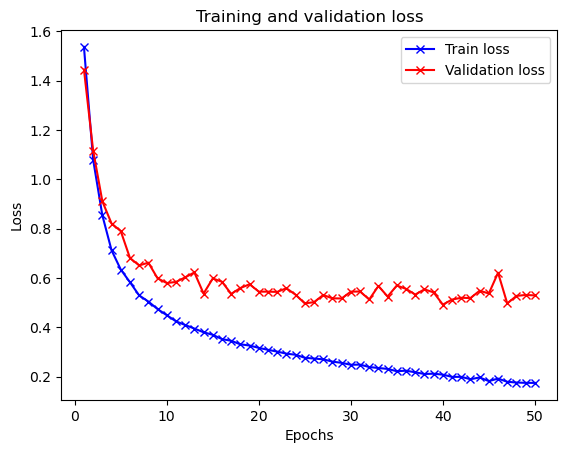

In [12]:
import matplotlib.pyplot as plt

# Define the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the train loss and val loss
plt.plot(epochs, train_loss, '-bx', label='Train loss')
plt.plot(epochs, validation_loss, '-rx', label='Validation loss')


# Set the title and labels for the graph
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()

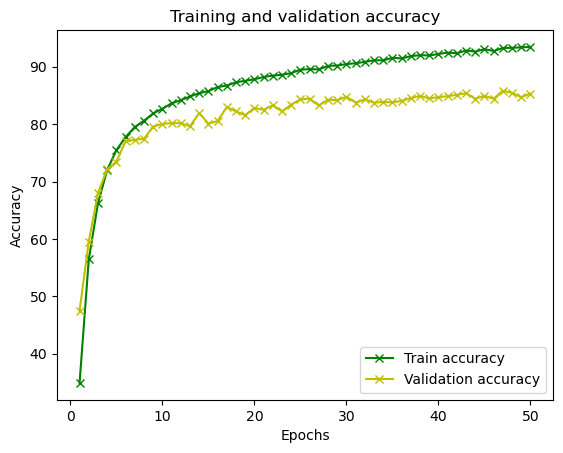

In [13]:
epochs = range(1, len(train_loss) + 1)
# Plot the train accuracy and val accuracy
plt.plot(epochs, train_accuracy, '-gx', label='Train accuracy')
plt.plot(epochs, validation_accuracy, '-yx', label='Validation accuracy')
# Set the title and labels for the graph
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()

In [14]:
# Evaluate the CNN on the test set
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = PandaNet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print the accuracy
print('Accuracy of the pre-trained CNN on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the pre-trained CNN on the 10000 test images: 85.81 %
